### LSE Data Analytics Online Career Accelerator

# DA201: Diagnostic Analysis using Python

# 

## Prepared by: Yuliya Pauzunova

# 

# Background/context of the business scenario

Business problem: Design and implement a financial and operational strategy to ensure NHS infrastructure and resources match population capacity

Analytical problem: Identify utilisation trends in the NHS network to inform the decision-making process around NHS budget allotment and operational efficiency

The project will aim to address the following analytical objectives/questions:
1) Assess the full capacity and actual utilisation of existing infrastructure and resources.
2) Identify utilisation trends and patterns and possible reasons for this.
3) Recommend potential measures to reduce or eliminate identified inefficiencies. 
ies 


#

# Data pre-processing

### 1. Prepare workstation

In [5]:
# Import the necessary libraries.
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import *
from matplotlib.ticker import FuncFormatter

# other
import requests
import bs4
from bs4 import BeautifulSoup
import re
from datetime import datetime
import holidays

In [25]:
""" Import the datasets:
 - actual_duration.csv data set as ad.
 - appointments_regional.csv data set as ar.
 - national_categories.xlsx data set as nc.
 - tweets.csv data set as tw."""
ad = pd.read_csv('actual_duration.csv')
ar1 = pd.read_csv('appointments_regional_1.csv')
ar2 = pd.read_csv('appointments_regional_2.csv')
ar = pd.concat([ar1, ar2], ignore_index=True)
nc1 = pd.read_excel('national_categories_1.xlsx')
nc2 = pd.read_excel('national_categories_2.xlsx')
nc = pd.concat([nc1, nc2], ignore_index=True)
tw = pd.read_csv('tweets.csv')

In [12]:
# Set the plot style as white.
sns.set_style('white')

### 2. User-defined functions

In [14]:
"""
The `is_holiday(date)` function evaluates whether a specified date is a holiday or a working day in England.

Arguments:
    date (datetime): A date object in the datetime format.

Returns:
    str: Returns 'holiday' if the date is a weekend or a recognised public holiday, 
         otherwise returns 'working'.
"""

def is_holiday(date):
    if date.weekday() >= 5 or date in holidays.CountryHoliday('GB', prov='ENG'):
        return 'holiday'
    else:
        return 'working'

In [15]:
"""
The `weighted_average()` function calculates the weighted average of a specified column in a DataFrame, grouped by one or more dimensions.

Parameters:
    source_df (pd.DataFrame): The input DataFrame containing the data for transformation.
    col_to_weight (str): The name of the column for which the weighted average is calculated.
    dimensions_to_gr_by (list of str): The column names used to group the data.
    wa_col_name (str): The name of the column to store the weighted average in the output DataFrame.
    col_to_weight_by (str, optional): The column used to weight `col_to_weight`. Defaults to 'count_of_appointments'.

Returns:
    pd.DataFrame: A transformed DataFrame with an additional column (`wa_col_name`) containing the weighted average values.
"""

def weighted_average(source_df, col_to_weight, dimensions_to_gr_by, wa_col_name, col_to_weight_by = 'count_of_appointments'):
    # Prepare a list of column names for final groupby operations
    col_to_gr_by_fin = dimensions_to_gr_by.copy()
    
    # Extend the list of groupby columns for intermediary calculations
    dimensions_to_gr_by.append(col_to_weight)
    col_to_gr_by_int = dimensions_to_gr_by.copy()
    
    # Further extend the list for subsetting during interim calculations 
    dimensions_to_gr_by.append(col_to_weight_by)
    col_to_subset = dimensions_to_gr_by.copy()
    
    # Subset the DataFrame and group by interim dimensions to perform initial calculations
    source_df = source_df[col_to_subset].groupby(by=col_to_gr_by_int, dropna=False).sum().reset_index()
    
    # Calculate the weighted sum and prepare for final groupby operations
    source_df['tech_sum_time'] = source_df[col_to_weight] * source_df[col_to_weight_by]
    source_df.drop(col_to_weight, axis=1, inplace=True)
    source_df = source_df.groupby(by=col_to_gr_by_fin, dropna=False).sum().reset_index()
    
    # Calculate the weighted average and add the results to the output column
    source_df[wa_col_name] = source_df['tech_sum_time'] / source_df[col_to_weight_by]
    source_df.drop('tech_sum_time', axis=1, inplace=True)

    # reset variables 
    col_to_subset = []
    col_to_gr_by_int = []
    col_to_gr_by_fin= []
    
    # Return the final transformed DataFrame
    return source_df

In [16]:
"""
The 'col_name_analysis()' function analyses and summarises the frequency of unique values in a specified column ('col_name') 
across four datasets: 'ad', 'ar', 'nc', and 'tw'.

Parameters:
    col_name (str): The name of the column to analyse.

Returns:
    pd.DataFrame: A DataFrame containing the frequency of each unique value in 'col_name' for each dataset. 
                  If 'col_name' is not present in a dataset, the corresponding frequencies are filled with NaN.
"""

def col_name_analysis(col_name):
    # create a list of unique 'col_name' values based on the four datasets
    l = []
    if col_name in ad.columns:
        l = l + list(ad[col_name].unique())
    if col_name in ar.columns:
        l = l + list(ar[col_name].unique())
    if col_name in nc.columns:
        l = l + list(nc[col_name].unique())
    if col_name in tw.columns:
        l = l + list(tw[col_name].unique())
    l = list(set(l))
    
    # Populate frequency data for each dataset
    # If 'col_name' exists in the dataset, calculate the frequency of its unique values
    # Otherwise, create a Series with NaN values for the unique values     
    if col_name in ad.columns:
        ad_c = ad.groupby(by=col_name).count().iloc[:,0:1]
    else:
        ad_c = pd.Series(data= np.nan * len(l), index=l)
    if col_name in ar.columns:
        ar_c = ar.groupby(by=col_name).count().iloc[:,0:1]
    else:
        ar_c = pd.Series(data= np.nan * len(l), index=l)
    if col_name in nc.columns:
        nc_c = nc.groupby(by=col_name).count().iloc[:,0:1]
    else:
        nc_c = pd.Series(data= np.nan * len(l), index=l)
    if col_name in tw.columns:
        tw_c = tw.groupby(by=col_name).count().iloc[:,0:1]
    else:
        tw_c = pd.Series(data= np.nan * len(l), index=l)

    # Combine frequency data into a DataFrame 
    freq_df = pd.concat([ad_c, ar_c, nc_c, tw_c], axis=1)
    freq_df.columns = ['ad', 'ar', 'nc', 'tw']
  
    return freq_df

### 3. Sense-check DataFrames (PRE-CLEANING)

**Observations:**

1. There are missing values identified in the tw data set. Potentially, subject to further analysis.
2. There are 21604 duplicate values in the ar data set. No action is taken (see comments in the relevant section below).
3. Appointment_date field in ad is an object. Converted to datetime See **Data cleaning** section below
4. The 'appointment_date' field reconciles with the 'appointment_month' in nc. Since ar and nc DFs have the 'appointment_month' field, to ease the analysis we decided to add 'appointment_month' field to ad DF to improve comparability. See **Data cleaning** section below

##### Basic sense-check

In [20]:
# Sense-check the new DataFrames to determine the column names
print(ad.columns)
print(ar.columns)
print(nc.columns)
print(tw.columns)

Index(['sub_icb_location_code', 'sub_icb_location_ons_code',
       'sub_icb_location_name', 'icb_ons_code', 'region_ons_code',
       'appointment_date', 'actual_duration', 'count_of_appointments'],
      dtype='object')
Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments'],
      dtype='object')
Index(['appointment_date', 'icb_ons_code', 'sub_icb_location_name',
       'service_setting', 'context_type', 'national_category',
       'count_of_appointments', 'appointment_month'],
      dtype='object')
Index(['tweet_id', 'tweet_full_text', 'tweet_entities',
       'tweet_entities_hashtags', 'tweet_metadata', 'tweet_retweet_count',
       'tweet_favorite_count', 'tweet_favorited', 'tweet_retweeted',
       'tweet_lang'],
      dtype='object')


In [21]:
# Sense-check the new DataFrames to determine number of rows and columns
print(ad.shape)
print(ar.shape)
print(nc.shape)
print(tw.shape)

(137793, 8)
(596821, 7)
(817394, 8)
(1174, 10)


In [22]:
# Sense-check the new DataFrames to determine the data types
print(ad.dtypes)
print(ar.dtypes)
print(nc.dtypes)
print(tw.dtypes)

sub_icb_location_code        object
sub_icb_location_ons_code    object
sub_icb_location_name        object
icb_ons_code                 object
region_ons_code              object
appointment_date             object
actual_duration              object
count_of_appointments         int64
dtype: object
icb_ons_code                         object
appointment_month                    object
appointment_status                   object
hcp_type                             object
appointment_mode                     object
time_between_book_and_appointment    object
count_of_appointments                 int64
dtype: object
appointment_date         datetime64[ns]
icb_ons_code                     object
sub_icb_location_name            object
service_setting                  object
context_type                     object
national_category                object
count_of_appointments             int64
appointment_month                object
dtype: object
tweet_id                    int64
tweet_fu

In [23]:
# Sense-check the new DataFrames to determine the number of missing values.
print(ad.isnull().sum().sum())
print(ar.isnull().sum().sum())
print(nc.isnull().sum().sum())
print(tw.isnull().sum().sum())

0
0
0
167


In [24]:
# Sense-check the missing values in tw DataFrame in more detail.
tw.isnull().sum()

tweet_id                     0
tweet_full_text              0
tweet_entities               0
tweet_entities_hashtags    167
tweet_metadata               0
tweet_retweet_count          0
tweet_favorite_count         0
tweet_favorited              0
tweet_retweeted              0
tweet_lang                   0
dtype: int64

In [25]:
# Determine the descriptive statistics of each DataFrame.
print(ad.describe())
print(ar.describe())
print(nc.describe())
print(tw.describe())

       count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.000000
25%               194.000000
50%               696.000000
75%              1621.000000
max             15400.000000
       count_of_appointments
count          596821.000000
mean             1244.601857
std              5856.887042
min                 1.000000
25%                 7.000000
50%                47.000000
75%               308.000000
max            211265.000000
                    appointment_date  count_of_appointments
count                         817394          817394.000000
mean   2022-01-16 00:50:35.860796160             362.183684
min              2021-08-01 00:00:00               1.000000
25%              2021-10-25 00:00:00               7.000000
50%              2022-01-18 00:00:00              25.000000
75%              2022-04-07 00:00:00             128.000000
max              2022-06-30 00:00:00           16590.00000

In [26]:
# Determine the metadata of each DataFrame.
print(ad.info())
print(ar.info())
print(nc.info())
print(tw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                    

##### Identify common fields (with count)

In [28]:
# Count unique values in each column for each of the data sets 
ad_unique_counts = ad.nunique()
ar_unique_counts = ar.nunique()
nc_unique_counts = nc.nunique()
tw_unique_counts = tw.nunique()

# summarise findings
unique_counts_pre = pd.concat([ad_unique_counts, ar_unique_counts, nc_unique_counts, tw_unique_counts], axis=1)
unique_counts_pre.rename(columns={0: "ad", 1: "ar", 2: "nc", 3: "tw"}, inplace=True)
unique_counts_pre.sort_index()

# view the output
print(unique_counts_pre)

                                       ad       ar      nc      tw
sub_icb_location_code               106.0      NaN     NaN     NaN
sub_icb_location_ons_code           106.0      NaN     NaN     NaN
sub_icb_location_name               106.0      NaN   106.0     NaN
icb_ons_code                         42.0     42.0    42.0     NaN
region_ons_code                       7.0      NaN     NaN     NaN
appointment_date                    212.0      NaN   334.0     NaN
actual_duration                       7.0      NaN     NaN     NaN
count_of_appointments              7611.0  22807.0  9957.0     NaN
appointment_month                     NaN     30.0    11.0     NaN
appointment_status                    NaN      3.0     NaN     NaN
hcp_type                              NaN      3.0     NaN     NaN
appointment_mode                      NaN      5.0     NaN     NaN
time_between_book_and_appointment     NaN      8.0     NaN     NaN
service_setting                       NaN      NaN     5.0    

In [29]:
# export the unique_counts_pre DataFrame to .csv
#unique_counts_pre.to_csv('unique_counts_pre.csv')

### 4. Data cleaning & transformation

In [31]:
# Cast ad['appointment_date'] to datetime
ad['appointment_date'] = ad['appointment_date'].astype('datetime64[ns]')
ad.dtypes

sub_icb_location_code                object
sub_icb_location_ons_code            object
sub_icb_location_name                object
icb_ons_code                         object
region_ons_code                      object
appointment_date             datetime64[ns]
actual_duration                      object
count_of_appointments                 int64
dtype: object

In [32]:
# Add the 'appointment_month' field to ad, equal to 'appointment_date' in the 'yyyy-%m' format
ad['appointment_month'] = ad.appointment_date.dt.year.astype(str) + '-' + ad.appointment_date.dt.strftime('%m').astype(str)
ad.dtypes

sub_icb_location_code                object
sub_icb_location_ons_code            object
sub_icb_location_name                object
icb_ons_code                         object
region_ons_code                      object
appointment_date             datetime64[ns]
actual_duration                      object
count_of_appointments                 int64
appointment_month                    object
dtype: object

In [33]:
# Change the data type of 'object' fields to string in all data sources for ease of visualisation.

# ad dataset 
ad['sub_icb_location_code'] = ad['sub_icb_location_code'].astype('string')
ad['sub_icb_location_ons_code'] = ad['sub_icb_location_ons_code'].astype('string')
ad['sub_icb_location_name'] = ad['sub_icb_location_name'].astype('string')
ad['icb_ons_code'] = ad['icb_ons_code'].astype('string')
ad['region_ons_code'] = ad['region_ons_code'].astype('string')
ad['actual_duration'] = ad['actual_duration'].astype('string')
ad['appointment_month'] = ad['appointment_month'].astype('string')

# ar dataset 
ar['icb_ons_code'] = ar['icb_ons_code'].astype('string')
ar['appointment_month'] = ar['appointment_month'].astype('string')
ar['appointment_status'] = ar['appointment_status'].astype('string')
ar['hcp_type'] = ar['hcp_type'].astype('string')
ar['appointment_mode'] = ar['appointment_mode'].astype('string')
ar['time_between_book_and_appointment'] = ar['time_between_book_and_appointment'].astype('string')

# nc dataset 
nc['icb_ons_code'] = nc['icb_ons_code'].astype('string')
nc['sub_icb_location_name'] = nc['sub_icb_location_name'].astype('string')
nc['service_setting'] = nc['service_setting'].astype('string')
nc['context_type'] = nc['context_type'].astype('string')
nc['national_category'] = nc['national_category'].astype('string')
nc['appointment_month'] = nc['appointment_month'].astype('string')

In [34]:
# Add region_ons_code to nc and ar applying ad mapping. 

# Create the icb_region_pairs_unique DataFrame
icb_region_pairs_unique = ad[['icb_ons_code', 'region_ons_code']].groupby(by=['icb_ons_code', 'region_ons_code']).sum().sort_values('region_ons_code')

# Create a dictionary with 'icb_ons_code':'region_ons_code' key:value pairs 
icb_region_mapping = icb_region_pairs_unique.reset_index(level=-1).to_dict()['region_ons_code']

# create the 'region_ons_code' column in the nc and ar DataFrames and populate it applying icb_region_mapping
nc['region_ons_code'] = nc['icb_ons_code'].map(icb_region_mapping)
ar['region_ons_code'] = ar['icb_ons_code'].map(icb_region_mapping)

# sense check the output 
print(nc.region_ons_code.unique())
print(ar.region_ons_code.nunique())
print(ad.region_ons_code.nunique())

['E40000012' 'E40000010' 'E40000011' 'E40000007' 'E40000005' 'E40000006'
 'E40000003']
7
7


In [35]:
# Add the 'day_of_week' column to nc and ad
nc['day_of_week'] = nc['appointment_date'].dt.day_name().astype('string')
ad['day_of_week'] = ad['appointment_date'].dt.day_name().astype('string')

In [36]:
# Add appointment_status_est column to ar and populate it assuming Unknown is 100% DNA (based on waiting time vs attendance analysis)

# Create a dictionary with mapping
appointment_status_est_mapping = {'Attended': 'Attended_est',
                                  'DNA': 'DNA_est',
                                  'Unknown': 'DNA_est'}

# Create the 'appointment_status_est' column in the ar DataFrame and populate it applying appointment_status_est_mapping
ar['appointment_status_est'] = ar['appointment_status'].map(appointment_status_est_mapping)

# sense check the output 
print(ar.appointment_status_est.unique())

['Attended_est' 'DNA_est']


In [37]:
# Add time_between_book_and_appointment_n column to ar and populate it with numeric values

# Create a dictionary with 'time_between_book_and_appointment':'time_between_book_and_appointment_n' key:value pairs
# value in the key:value pairs is equal to the middle of the range indicated in the keys
# 'More than 28 Days' is mapped as 28, as no details are available (The numeric value is underestimeted). 
# 'Unknown / Data Quality' is equal to 'More than 28 Days'.
time_between_book_and_appointment_to_n_mapping = {'1 Day': 1,
                                                  '15  to 21 Days': 18,
                                                  '2 to 7 Days': 4.5,
                                                  '22  to 28 Days': 25,
                                                  '8  to 14 Days': 11,
                                                  'More than 28 Days': 28,
                                                  'Same Day': 0,
                                                  'Unknown / Data Quality': 28}

# Create the 'time_between_book_and_appointment_n' column in the ar DataFrame and populate it applying time_between_book_and_appointment_to_n_mapping
ar['time_between_book_and_appointment_n'] = ar['time_between_book_and_appointment'].map(time_between_book_and_appointment_to_n_mapping)

# sense check the output 
print(ar.time_between_book_and_appointment_n.unique())
ar[['time_between_book_and_appointment', 'time_between_book_and_appointment_n', 'count_of_appointments']]\
.groupby(by=['time_between_book_and_appointment', 'time_between_book_and_appointment_n'], dropna=False).sum()

[ 1.  18.   4.5 25.  11.  28.   0. ]


count_of_appointments
time_between_book_and_appointment time_between_book_and_appointment_n                       
1 Day                             1.0                                               67716097
15  to 21 Days                    18.0                                              42710574
2 to 7 Days                       4.5                                              153794531
22  to 28 Days                    25.0                                              25536541
8  to 14 Days                     11.0                                              86846519
More than 28 Days                 28.0                                              23050987
Same Day                          0.0                                              342747171
Unknown / Data Quality            28.0                                                402105

In [38]:
# Add actual_duration_n column to ad and populate it with numeric values

# Create a dictionary with 'actual_duration':'actual_duration_n' key:value pairs
# value in the key:value pairs is equal to the middle of the range indicated in the keys 
# 'Unknown / Data Quality' is populated based on a weighted average of all other categories 'actual_duration_n' of 14 (rounded).
actual_duration_to_n_mapping = {'1-5 Minutes': 3,
                                '11-15 Minutes': 13,
                                '16-20 Minutes': 18,
                                '21-30 Minutes': 25.5,
                                '31-60 Minutes': 45.5,
                                '6-10 Minutes': 8,
                                'Unknown / Data Quality': 14}

# Create the 'actual_duration_n' column in the ad DataFrame and populate it applying actual_duration_to_n_mapping
ad['actual_duration_n'] = ad['actual_duration'].map(actual_duration_to_n_mapping)

# sense check the output 
print(ad.actual_duration_n.unique())
ad[['actual_duration', 'actual_duration_n', 'count_of_appointments']].groupby(by=['actual_duration', 'actual_duration_n'], dropna=False).sum()

[45.5 25.5  8.  14.  18.  13.   3. ]


count_of_appointments
actual_duration        actual_duration_n                       
1-5 Minutes            3.0                             28600865
11-15 Minutes          13.0                            25160882
16-20 Minutes          18.0                            16004247
21-30 Minutes          25.5                            15026365
31-60 Minutes          45.5                             9103432
6-10 Minutes           8.0                             33800815
Unknown / Data Quality 14.0                            40284086

In [39]:
# Add time_between_book_and_appointment_est column to ar

# Create a dictionary with 'time_between_book_and_appointment':'time_between_book_and_appointment_est' key:value pairs
time_between_book_and_appointment_est_mapping = {'1 Day': '1 Day',
                                                  '15  to 21 Days': '15  to 21 Days',
                                                  '2 to 7 Days': '2 to 7 Days',
                                                  '22  to 28 Days': '22  to 28 Days',
                                                  '8  to 14 Days': '8  to 14 Days',
                                                  'More than 28 Days': 'More than 28 Days',
                                                  'Same Day': 'Same Day',
                                                  'Unknown / Data Quality': 'More than 28 Days'}

# Create the 'time_between_book_and_appointment_est' column in the ar DataFrame and populate it applying time_between_book_and_appointment_est_mapping
ar['time_between_book_and_appointment_est'] = ar['time_between_book_and_appointment'].map(time_between_book_and_appointment_est_mapping)

# sense check the output 
print(ar.time_between_book_and_appointment_est.unique())
ar[['time_between_book_and_appointment', 'time_between_book_and_appointment_est', 'time_between_book_and_appointment_n', 'count_of_appointments']]\
.groupby(by=['time_between_book_and_appointment', 'time_between_book_and_appointment_est', 'time_between_book_and_appointment_n'], dropna=False).sum()

['1 Day' '15  to 21 Days' '2 to 7 Days' '22  to 28 Days' '8  to 14 Days'
 'More than 28 Days' 'Same Day']


count_of_appointments
time_between_book_and_appointment time_between_book_and_appointment_est time_between_book_and_appointment_n                       
1 Day                             1 Day                                 1.0                                               67716097
15  to 21 Days                    15  to 21 Days                        18.0                                              42710574
2 to 7 Days                       2 to 7 Days                           4.5                                              153794531
22  to 28 Days                    22  to 28 Days                        25.0                                              25536541
8  to 14 Days                     8  to 14 Days                         11.0                                              86846519
More than 28 Days                 More than 28 Days                     28.0                                              23050987
Same Day                          Same Day                              0.0                                              342747171
Unknown / Data Quality            More than 28 Days                     28.0                                                402105

In [40]:
# Add time_between_book_and_appointment_gr column to ar 

# Create a dictionary with 'time_between_book_and_appointment':'time_between_book_and_appointment_gr' key:value pairs
time_between_book_and_appointment_gr_mapping = {'1 Day': 'Up to 7 days',
                                                  '15  to 21 Days': '8+ days',
                                                  '2 to 7 Days': 'Up to 7 days',
                                                  '22  to 28 Days': '8+ days',
                                                  '8  to 14 Days': '8+ days',
                                                  'More than 28 Days': '8+ days',
                                                  'Same Day': 'Up to 7 days',
                                                  'Unknown / Data Quality': '8+ days'}

# Create the 'time_between_book_and_appointment_gr' column in the ar DataFrame and populate it applying time_between_book_and_appointment_gr_mapping
ar['time_between_book_and_appointment_gr'] = ar['time_between_book_and_appointment'].map(time_between_book_and_appointment_gr_mapping)

# sense check the output 
print(ar.time_between_book_and_appointment_gr.unique())
ar[['time_between_book_and_appointment', 'time_between_book_and_appointment_est', 'time_between_book_and_appointment_gr', 'time_between_book_and_appointment_n', 'count_of_appointments']]\
.groupby(by=['time_between_book_and_appointment', 'time_between_book_and_appointment_est', 'time_between_book_and_appointment_gr', 'time_between_book_and_appointment_n'], dropna=False).sum().sort_values(by='time_between_book_and_appointment_n')

['Up to 7 days' '8+ days']


count_of_appointments
time_between_book_and_appointment time_between_book_and_appointment_est time_between_book_and_appointment_gr time_between_book_and_appointment_n                       
Same Day                          Same Day                              Up to 7 days                         0.0                                              342747171
1 Day                             1 Day                                 Up to 7 days                         1.0                                               67716097
2 to 7 Days                       2 to 7 Days                           Up to 7 days                         4.5                                              153794531
8  to 14 Days                     8  to 14 Days                         8+ days                              11.0                                              86846519
15  to 21 Days                    15  to 21 Days                        8+ days                              18.0                                              42710574
22  to 28 Days                    22  to 28 Days                        8+ days                              25.0                                              25536541
More than 28 Days                 More than 28 Days                     8+ days                              28.0                                              23050987
Unknown / Data Quality            More than 28 Days                     8+ days                              28.0                                                402105

In [41]:
# Add region_ons_name to nc, ar and ad applying ad mapping. 
# https://geoportal.statistics.gov.uk/datasets/2bca16d4f8e4426d80137213fce90bbd_0/explore

# Create a dictionary with 'region_ons_code':'region_ons_name' key:value pairs 
region_mapping = {'E40000003': 'London',
                  'E40000005': 'South East',
                  'E40000006': 'South West',
                  'E40000007': 'East of England',
                  'E40000010': 'North West',
                  'E40000011': 'Midlands',
                  'E40000012': 'North East and Yorkshire'}

# create the 'region_ons_name' column in the nc, ar and ad DataFrames and populate it applying region_mapping
nc['region_ons_name'] = nc['region_ons_code'].map(region_mapping)
ar['region_ons_name'] = ar['region_ons_code'].map(region_mapping)
ad['region_ons_name'] = ad['region_ons_code'].map(region_mapping)

# sense check the output 
print(nc.region_ons_name.nunique())
print(ar.region_ons_name.nunique())
print(ad.region_ons_name.nunique())

7
7
7


In [42]:
# Create the 'day_of_week_type' column in the nc and ad DataFrames and populate it applying is_holiday user-defined function
nc['day_of_week_type'] = nc.appointment_date.apply(is_holiday)
ad['day_of_week_type'] = ad.appointment_date.apply(is_holiday)

# sense-check the result
nc.day_of_week_type.unique()

array(['working', 'holiday'], dtype=object)

In [43]:
# Add appointment_mode_expl to ar applying mapping. 

# Create a dictionary with 'appointment_mode':'appointment_mode_expl' key:value pairs 
appointment_mode_expl_mapping = {'Face-to-Face': 'Face-to-Face',
                            'Home Visit': 'Other',
                            'Telephone': 'Telephone',
                            'Unknown': 'Other',
                            'Video/Online': 'Other'}

# create the 'region_ons_name_expl' column in the ar DataFrame and populate it applying appointment_mode_expl_mapping
ar['appointment_mode_expl'] = ar['appointment_mode'].map(appointment_mode_expl_mapping)

# sense check the output 
print(ar.appointment_mode_expl.nunique())

3


In [44]:
# Add national_category_expl column to nc and populate it with new mapping

# Create a dictionary with 'national_category':'national_category_expl' key:value pairs
national_category_mapping = {'General Consultation Routine': 'General Consultation Routine',
                             'General Consultation Acute': 'General Consultation Acute',
                             'Clinical Triage': 'Other',
                             'Planned Clinics': 'Other',
                             'Inconsistent Mapping': 'Unknown',
                             'Planned Clinical Procedure': 'Planned Clinical Procedure',
                             'Unmapped': 'Other',
                             'Unplanned Clinical Activity': 'Other',
                             'Home Visit': 'Other',
                             'Structured Medication Review': 'Other',
                             'Service provided by organisation external to the practice': 'Other',
                             'Patient contact during Care Home Round': 'Other',
                             'Care Home Visit': 'Other',
                             'Social Prescribing Service': 'Other',
                             'Walk-in': 'Other',
                             'Care Home Needs Assessment & Personalised Care and Support Planning': 'Other',
                             'Non-contractual chargeable work': 'Other',
                             'Group Consultation and Group Education': 'Other'}


# Create the 'national_category_expl' column in the nc DataFrame and populate it applying national_category_mapping
nc['national_category_expl'] = nc['national_category'].map(national_category_mapping)

# sense check the output 
print(nc.national_category_expl.unique())

['Other' 'General Consultation Acute' 'Planned Clinical Procedure'
 'Unknown' 'General Consultation Routine']


In [45]:
# Change the data type of the remaining 'object' fields to string / int in all data sources for ease of visualisation.

# ad dataset 
ad['region_ons_name'] = ad['region_ons_name'].astype('string')
ad['day_of_week_type'] = ad['day_of_week_type'].astype('string')
ad['actual_duration_n'] = ad['actual_duration_n'].astype(np.int64)


# ar dataset 
ar['region_ons_code'] = ar['region_ons_code'].astype('string')
ar['region_ons_name'] = ar['region_ons_name'].astype('string')
ar['appointment_mode_expl'] = ar['appointment_mode_expl'].astype('string')
ar['time_between_book_and_appointment_n'] = ar['time_between_book_and_appointment_n'].astype(np.int64)


# nc dataset 
nc['region_ons_name'] = nc['region_ons_name'].astype('string')
nc['region_ons_code'] = nc['region_ons_code'].astype('string')
nc['day_of_week_type'] = nc['day_of_week_type'].astype('string')
nc['national_category_expl'] = nc['national_category_expl'].astype('string')

### 5. Sense-check (post-cleaning)

**Observations:**

1. There are missing values identified in the tw data set. Potentially, subject to further analysis.
2. There are 21604 duplicate values in the ar data set. No action is taken (see comments in the relevant section below).
4. The 'appointment_date' field reconciles with the 'appointment_month' in nc. Since ar and nc DFs have the 'appointment_month' field, to ease the analysis we decided to add 'appointment_month' field to ad DF to improve comparability. See **Data cleaning** section above

#### 5.1 Basic sense-check

In [49]:
# Sense-check the new DataFrames to determine the column names
print(ad.columns)
print(ar.columns)
print(nc.columns)
print(tw.columns)

Index(['sub_icb_location_code', 'sub_icb_location_ons_code',
       'sub_icb_location_name', 'icb_ons_code', 'region_ons_code',
       'appointment_date', 'actual_duration', 'count_of_appointments',
       'appointment_month', 'day_of_week', 'actual_duration_n',
       'region_ons_name', 'day_of_week_type'],
      dtype='object')
Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments', 'region_ons_code', 'appointment_status_est',
       'time_between_book_and_appointment_n',
       'time_between_book_and_appointment_est',
       'time_between_book_and_appointment_gr', 'region_ons_name',
       'appointment_mode_expl'],
      dtype='object')
Index(['appointment_date', 'icb_ons_code', 'sub_icb_location_name',
       'service_setting', 'context_type', 'national_category',
       'count_of_appointments', 'appointment_month', 'region_ons_code',
       'day_of_week', 'region_o

In [50]:
# Sense-check the new DataFrames to determine number of rows and columns
print(ad.shape)
print(ar.shape)
print(nc.shape)
print(tw.shape)

(137793, 13)
(596821, 14)
(817394, 13)
(1174, 10)


'actual_duration_n' and 'time_between_book_and_appointment_n' type is 'object' as both contain np.NA values where no data is available. Potentially to populate with averages.

In [52]:
# Sense-check the new DataFrames to determine the data types
print(ad.dtypes)
print(ar.dtypes)
print(nc.dtypes)
print(tw.dtypes)

sub_icb_location_code        string[python]
sub_icb_location_ons_code    string[python]
sub_icb_location_name        string[python]
icb_ons_code                 string[python]
region_ons_code              string[python]
appointment_date             datetime64[ns]
actual_duration              string[python]
count_of_appointments                 int64
appointment_month            string[python]
day_of_week                  string[python]
actual_duration_n                     int64
region_ons_name              string[python]
day_of_week_type             string[python]
dtype: object
icb_ons_code                             string[python]
appointment_month                        string[python]
appointment_status                       string[python]
hcp_type                                 string[python]
appointment_mode                         string[python]
time_between_book_and_appointment        string[python]
count_of_appointments                             int64
region_ons_code       

In [53]:
# Sense-check the new DataFrames to determine the number of missing values.
print(ad.isnull().sum().sum())
print(ar.isnull().sum().sum())
print(nc.isnull().sum().sum())
print(tw.isnull().sum().sum())

0
0
0
167


In [54]:
# Sense-check the missing values in tw DataFrame in more detail.
tw.isnull().sum()

tweet_id                     0
tweet_full_text              0
tweet_entities               0
tweet_entities_hashtags    167
tweet_metadata               0
tweet_retweet_count          0
tweet_favorite_count         0
tweet_favorited              0
tweet_retweeted              0
tweet_lang                   0
dtype: int64

In [55]:
# Determine the descriptive statistics (e.g. df.describe()) of each DataFrame.
print(ad.describe())
print(ar.describe())
print(nc.describe())
print(tw.describe())

                    appointment_date  count_of_appointments  actual_duration_n
count                         137793          137793.000000      137793.000000
mean   2022-03-16 19:31:17.868977664            1219.080011          17.817073
min              2021-12-01 00:00:00               1.000000           3.000000
25%              2022-01-25 00:00:00             194.000000           8.000000
50%              2022-03-16 00:00:00             696.000000          14.000000
75%              2022-05-09 00:00:00            1621.000000          25.000000
max              2022-06-30 00:00:00           15400.000000          45.000000
std                              NaN            1546.902956          12.680421
       count_of_appointments  time_between_book_and_appointment_n
count          596821.000000                        596821.000000
mean             1244.601857                            11.843561
std              5856.887042                            10.756032
min                 1.000

In [56]:
# Determine the metadata (e.g. df.info()) of each DataFrame.
print(ad.info())
print(ar.info())
print(nc.info())
print(tw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   sub_icb_location_code      137793 non-null  string        
 1   sub_icb_location_ons_code  137793 non-null  string        
 2   sub_icb_location_name      137793 non-null  string        
 3   icb_ons_code               137793 non-null  string        
 4   region_ons_code            137793 non-null  string        
 5   appointment_date           137793 non-null  datetime64[ns]
 6   actual_duration            137793 non-null  string        
 7   count_of_appointments      137793 non-null  int64         
 8   appointment_month          137793 non-null  string        
 9   day_of_week                137793 non-null  string        
 10  actual_duration_n          137793 non-null  int64         
 11  region_ons_name            137793 non-null  string  

#### 5.2 Identify common fields (with count)

In [58]:
# Count unique values in each column for each of the data sets 
ad_unique_counts = ad.nunique()
ar_unique_counts = ar.nunique()
nc_unique_counts = nc.nunique()
tw_unique_counts = tw.nunique()

# summarise findings
unique_counts = pd.concat([ad_unique_counts, ar_unique_counts, nc_unique_counts, tw_unique_counts], axis=1)
unique_counts.rename(columns={0: "ad", 1: "ar", 2: "nc", 3: "tw"}, inplace=True)
unique_counts.sort_index()

# view the output
print(unique_counts)

                                           ad       ar      nc      tw
sub_icb_location_code                   106.0      NaN     NaN     NaN
sub_icb_location_ons_code               106.0      NaN     NaN     NaN
sub_icb_location_name                   106.0      NaN   106.0     NaN
icb_ons_code                             42.0     42.0    42.0     NaN
region_ons_code                           7.0      7.0     7.0     NaN
appointment_date                        212.0      NaN   334.0     NaN
actual_duration                           7.0      NaN     NaN     NaN
count_of_appointments                  7611.0  22807.0  9957.0     NaN
appointment_month                         7.0     30.0    11.0     NaN
day_of_week                               7.0      NaN     7.0     NaN
actual_duration_n                         7.0      NaN     NaN     NaN
region_ons_name                           7.0      7.0     7.0     NaN
day_of_week_type                          2.0      NaN     2.0     NaN
appoin

In [59]:
# export the unique_counts DataFrame to .csv
#unique_counts.to_csv('unique_counts.csv')

#### 5.3 Check whether 'appointment_date' reconciles with 'appointment_month' in nc

In [61]:
# Convert 'appointment_date' to the 'yyyy-%m' format, matching 'appointment_month'
ap_m_calc = nc.appointment_date.dt.year.astype(str) + '-' + nc.appointment_date.dt.strftime('%m').astype(str)

# Return True if 'appointment_date' equals 'appointment_month'
nc['appointment_month'].astype(object).equals(ap_m_calc)

True

#### 5.4 Check whether 'icb_ons_code' is a subset of 'region_ons_code' in ad

**Observation:**

'icb_ons_code' is a subset of 'region_ons_code' in ad DataFrame.

In [64]:
# Determine the number of unique values in the 'icb_ons_code' 
icb_unique_count = ad.icb_ons_code.nunique()

# View the output
icb_unique_count

42

In [65]:
# Create the icb_region_pairs_unique DataFrame
icb_region_pairs_unique = ad[['icb_ons_code', 'region_ons_code']].groupby(by=['icb_ons_code', 'region_ons_code']).sum()

# View the output
icb_region_pairs_unique

Empty DataFrame
Columns: []
Index: [(E54000008, E40000010), (E54000010, E40000011), (E54000011, E40000011), (E54000013, E40000011), (E54000015, E40000011), (E54000018, E40000011), (E54000019, E40000011), (E54000022, E40000007), (E54000023, E40000007), (E54000024, E40000007), (E54000025, E40000007), (E54000026, E40000007), (E54000027, E40000003), (E54000028, E40000003), (E54000029, E40000003), (E54000030, E40000003), (E54000031, E40000003), (E54000032, E40000005), (E54000034, E40000005), (E54000036, E40000006), (E54000037, E40000006), (E54000038, E40000006), (E54000039, E40000006), (E54000040, E40000006), (E54000041, E40000006), (E54000042, E40000005), (E54000043, E40000006), (E54000044, E40000005), (E54000048, E40000010), (E54000050, E40000012), (E54000051, E40000012), (E54000052, E40000005), (E54000053, E40000005), (E54000054, E40000012), (E54000055, E40000011), (E54000056, E40000007), (E54000057, E40000010), (E54000058, E40000011), (E54000059, E40000011), (E54000060, E40000011), (E54000061, E40000012), (E54000062, E40000011)]

In [66]:
# Determine the number of unique 'icb_ons_code' 'region_ons_code' pairs
icb_region_pairs_unique_count = icb_region_pairs_unique.shape[0]

# View the output
icb_region_pairs_unique_count

42

In [67]:
# Returns True if 'icb_region_pairs_unique_count' equals 'icb_unique_count'
icb_region_pairs_unique_count == icb_unique_count

True

#### 5.5 The 'count_of_appointments' field reconciliation across the three datasets (nd, ar and nc)

**Observation:**


-  'nc_s' =  'ar_s'
- 'ar_att_s' = 'ad_s'

In [70]:
# Determine the 'number of appointments per month' as per the nc dataset 
nc_col = nc[['appointment_month', 'count_of_appointments']].groupby(by='appointment_month').sum()

# Rename columns (dataset_sum)
nc_col.columns = ['nc_s']

# View the output
nc_col.tail(1)

nc_s
appointment_month          
2022-06            25828078

In [71]:
# Determine the 'number of appointments per month' by appointment status as per the ar dataset 
ar_col = ar[['appointment_month', 'count_of_appointments', 'appointment_status']]\
        .groupby(by=['appointment_month', 'appointment_status']).sum().unstack()

# Drop a level from a multi-level column index in ar_col
ar_col.columns = ar_col.columns.droplevel()

# Rename columns (dataset_appstatus_sum)
ar_col.columns = ['ar_att_s', 'ar_dna_s', 'ar_unk_s']

# Determine the total 'number of appointments per month' as the sum of 'number of appointments per month' by appointment status 
ar_col['ar_s'] = ar_col.apply(sum, axis=1)

# View the output
ar_col.tail(1)

ar_att_s  ar_dna_s  ar_unk_s      ar_s
appointment_month                                        
2022-06            23715317   1167790    944971  25828078

In [72]:
# Determine the 'number of appointments per month' as per the ad dataset 
ad_col = ad[['appointment_month', 'count_of_appointments']].groupby(by='appointment_month').sum()

# Rename columns (dataset_sum)
ad_col.columns = ['ad_s']

# View the output
ad_col.tail(1)

ad_s
appointment_month          
2022-06            23715317

In [73]:
# merge the three dfs
sum_rec = pd.merge(nc_col, ar_col, left_index=True, right_index=True, how='outer')
sum_rec = pd.merge(sum_rec, ad_col, left_index=True, right_index=True, how='outer')

# View the output.
sum_rec.tail(1)

nc_s  ar_att_s  ar_dna_s  ar_unk_s      ar_s  \
appointment_month                                                       
2022-06            25828078.0  23715317   1167790    944971  25828078   

                         ad_s  
appointment_month              
2022-06            23715317.0

In [74]:
"""Reconcile the ad, ar and nc dataframes:
   
   Field 'Check_1' compares the following figures: 
   - the total 'number of appointments per month' as per the ad dataset
   - the total 'number of appointments per month' with appointment_status 'Attended' as per the ar dataset.

   Field 'Check_2' compares the following figures: 
   - the total 'number of appointments per month' as per the nc dataset
   - the total 'number of appointments per month' as per the ar dataset.
   """

# Create a new column named 'Check_1' in the sum_rec pd.df and populate it with the difference between the 'ar_att_s' and 'ad_s' columns.
sum_rec['Check_1'] = sum_rec['ar_att_s'] - sum_rec['ad_s']

# Create a new column named 'Check_2' in the sum_rec pd.df and populate it with the difference between the 'nc_s' and 'ar_s' columns.
sum_rec['Check_2'] = sum_rec['nc_s'] - sum_rec['ar_s']

# View the output
sum_rec.tail()

nc_s  ar_att_s  ar_dna_s  ar_unk_s      ar_s  \
appointment_month                                                       
2022-02            25355260.0  23351939   1076658    926663  25355260   
2022-03            29595038.0  27170002   1289888   1135148  29595038   
2022-04            23913060.0  21948814   1045455    918791  23913060   
2022-05            27495508.0  25343941   1199518    952049  27495508   
2022-06            25828078.0  23715317   1167790    944971  25828078   

                         ad_s  Check_1  Check_2  
appointment_month                                
2022-02            23351939.0      0.0      0.0  
2022-03            27170002.0      0.0      0.0  
2022-04            21948814.0      0.0      0.0  
2022-05            25343941.0      0.0      0.0  
2022-06            23715317.0      0.0      0.0

In [75]:
# Calculate the sum of the differences
sum_rec[['Check_1','Check_2']].sum()

Check_1    0.0
Check_2    0.0
dtype: float64

In [76]:
# View the full dataframe
sum_rec

nc_s  ar_att_s  ar_dna_s  ar_unk_s      ar_s  \
appointment_month                                                       
2020-01                   NaN  24538291   1298269   1362736  27199296   
2020-02                   NaN  21640067   1215154   1249400  24104621   
2020-03                   NaN  20718865   1166314   2168289  24053468   
2020-04                   NaN  13982824    478766   1546291  16007881   
2020-05                   NaN  14962850    449057   1005305  16417212   
2020-06                   NaN  18943022    594382   1153401  20690805   
2020-07                   NaN  20606888    698327   1186222  22491437   
2020-08                   NaN  18438932    669462   1042126  20150520   
2020-09                   NaN  23988492   1145971   1579792  26714255   
2020-10                   NaN  25529275   1358138   1414519  28301932   
2020-11                   NaN  23072059   1021408    968135  25061602   
2020-12                   NaN  21592221    996416    947299  23535936   
2021-01                   NaN  20645718    899833    946518  22492069   
2021-02                   NaN  20736205    804659    858705  22399569   
2021-03                   NaN  25289991    964719    970714  27225424   
2021-04                   NaN  22056413    893723    929796  23879932   
2021-05                   NaN  21779605    878219    850571  23508395   
2021-06                   NaN  24815463   1030367    938352  26784182   
2021-07                   NaN  23761001   1029665    948553  25739219   
2021-08            23852171.0  22081765    949137    821269  23852171   
2021-09            28522501.0  25757066   1321348   1444087  28522501   
2021-10            30303834.0  27170506   1565624   1567704  30303834   
2021-11            30405070.0  27667665   1428087   1309318  30405070   
2021-12            25140776.0  22853483   1198866   1088427  25140776   
2022-01            25635474.0  23597196   1076013    962265  25635474   
2022-02            25355260.0  23351939   1076658    926663  25355260   
2022-03            29595038.0  27170002   1289888   1135148  29595038   
2022-04            23913060.0  21948814   1045455    918791  23913060   
2022-05            27495508.0  25343941   1199518    952049  27495508   
2022-06            25828078.0  23715317   1167790    944971  25828078   

                         ad_s  Check_1  Check_2  
appointment_month                                
2020-01                   NaN      NaN      NaN  
2020-02                   NaN      NaN      NaN  
2020-03                   NaN      NaN      NaN  
2020-04                   NaN      NaN      NaN  
2020-05                   NaN      NaN      NaN  
2020-06                   NaN      NaN      NaN  
2020-07                   NaN      NaN      NaN  
2020-08                   NaN      NaN      NaN  
2020-09                   NaN      NaN      NaN  
2020-10                   NaN      NaN      NaN  
2020-11                   NaN      NaN      NaN  
2020-12                   NaN      NaN      NaN  
2021-01                   NaN      NaN      NaN  
2021-02                   NaN      NaN      NaN  
2021-03                   NaN      NaN      NaN  
2021-04                   NaN      NaN      NaN  
2021-05                   NaN      NaN      NaN  
2021-06                   NaN      NaN      NaN  
2021-07                   NaN      NaN      NaN  
2021-08                   NaN      NaN      0.0  
2021-09                   NaN      NaN      0.0  
2021-10                   NaN      NaN      0.0  
2021-11                   NaN      NaN      0.0  
2021-12            22853483.0      0.0      0.0  
2022-01            23597196.0      0.0      0.0  
2022-02            23351939.0      0.0      0.0  
2022-03            27170002.0      0.0      0.0  
2022-04            21948814.0      0.0      0.0  
2022-05            25343941.0      0.0      0.0  
2022-06            23715317.0      0.0      0.0

In [77]:
# export the sum_rec DataFrame to .csv
sum_rec.to_csv('sum_rec.csv')

#### 5.6 The 'count_of_appointments' field reconciliation across the three datasets (nd, ar and nc) by month & icb_ons_code

In [79]:
# Determine the 'number of appointments per month' as per the nc dataset 
nc_app_m_icb = nc[['appointment_month', 'count_of_appointments', 'icb_ons_code']].groupby(by=['appointment_month', 'icb_ons_code']).sum()

# Rename columns (dataset_sum)
nc_app_m_icb.columns = ['nc_s']

# View the output
nc_app_m_icb.tail(5)

nc_s
appointment_month icb_ons_code        
2022-06           E54000058     495201
                  E54000059     336328
                  E54000060     537509
                  E54000061     648462
                  E54000062     622301

In [80]:
# Determine the 'number of appointments per month' by appointment status as per the ar dataset 
ar_app_m_icb = ar[['appointment_month', 'count_of_appointments', 'appointment_status', 'icb_ons_code']]\
        .groupby(by=['appointment_month', 'icb_ons_code', 'appointment_status']).sum().unstack(level=-1)
ar_app_m_icb

count_of_appointments               
appointment_status                          Attended    DNA Unknown
appointment_month icb_ons_code                                     
2020-01           E54000008                  1076386  63134   53562
                  E54000010                   433319  21154   20819
                  E54000011                   224715  10409    9155
                  E54000013                   358516  16151   21452
                  E54000015                   509096  26528   30397
...                                              ...    ...     ...
2022-06           E54000058                   459252  16631   19318
                  E54000059                   316792  10369    9167
                  E54000060                   497064  22911   17534
                  E54000061                   596650  28581   23231
                  E54000062                   560465  36898   24938

[1260 rows x 3 columns]

In [81]:
# Determine the 'number of appointments per month' by appointment status as per the ar dataset 
ar_app_m_icb = ar[['appointment_month', 'count_of_appointments', 'appointment_status', 'icb_ons_code']]\
        .groupby(by=['appointment_month', 'icb_ons_code', 'appointment_status']).sum().unstack(level=-1)

# Drop a level from a multi-level column index in ar_col
ar_app_m_icb.columns = ar_app_m_icb.columns.droplevel()

# Rename columns (dataset_appstatus_sum)
ar_app_m_icb.columns = ['ar_att_s', 'ar_dna_s', 'ar_unk_s']

# Determine the total 'number of appointments per month' as the sum of 'number of appointments per month' by appointment status 
ar_app_m_icb['ar_s'] = ar_app_m_icb.apply(sum, axis=1)

# View the output
ar_app_m_icb.tail(1)

ar_att_s  ar_dna_s  ar_unk_s    ar_s
appointment_month icb_ons_code                                      
2022-06           E54000062       560465     36898     24938  622301

In [82]:
# Determine the 'number of appointments per month' as per the ad dataset 
ad_app_m_icb = ad[['appointment_month', 'count_of_appointments', 'icb_ons_code']].groupby(by=['appointment_month', 'icb_ons_code']).sum()

# Rename columns (dataset_sum)
ad_app_m_icb.columns = ['ad_s']

# View the output
ad_app_m_icb.tail(1)

ad_s
appointment_month icb_ons_code        
2022-06           E54000062     560465

In [83]:
# merge the three dfs
app_m_icb_rec = pd.merge(nc_app_m_icb, ar_app_m_icb, left_index=True, right_index=True, how='outer')
app_m_icb_rec = pd.merge(app_m_icb_rec, ad_app_m_icb, left_index=True, right_index=True, how='outer')

# View the output.
app_m_icb_rec.tail(1)

nc_s  ar_att_s  ar_dna_s  ar_unk_s  \
appointment_month icb_ons_code                                           
2022-06           E54000062     622301.0    560465     36898     24938   

                                  ar_s      ad_s  
appointment_month icb_ons_code                    
2022-06           E54000062     622301  560465.0

In [84]:
"""Reconcile the ad, ar and nc dataframes:
   
   Field 'Check_1' compares the following figures: 
   - the total 'number of appointments per month' as per the ad dataset
   - the total 'number of appointments per month' with appointment_status 'Attended' as per the ar dataset.

   Field 'Check_2' compares the following figures: 
   - the total 'number of appointments per month' as per the nc dataset
   - the total 'number of appointments per month' as per the ar dataset.
   """

# Create a new column named 'Check_1' in the app_m_icb_rec pd.df and populate it with the difference between the 'ar_att_s' and 'ad_s' columns.
app_m_icb_rec['Check_1'] = app_m_icb_rec['ar_att_s'] - app_m_icb_rec['ad_s']

# Create a new column named 'Check_2' in the app_m_icb_rec pd.df and populate it with the difference between the 'nc_s' and 'ar_s' columns.
app_m_icb_rec['Check_2'] = app_m_icb_rec['nc_s'] - app_m_icb_rec['ar_s']

# reset index
app_m_icb_rec = app_m_icb_rec.reset_index()

# View the output
app_m_icb_rec.tail()

appointment_month icb_ons_code      nc_s  ar_att_s  ar_dna_s  ar_unk_s  \
1255           2022-06    E54000058  495201.0    459252     16631     19318   
1256           2022-06    E54000059  336328.0    316792     10369      9167   
1257           2022-06    E54000060  537509.0    497064     22911     17534   
1258           2022-06    E54000061  648462.0    596650     28581     23231   
1259           2022-06    E54000062  622301.0    560465     36898     24938   

        ar_s      ad_s  Check_1  Check_2  
1255  495201  459252.0      0.0      0.0  
1256  336328  316792.0      0.0      0.0  
1257  537509  497064.0      0.0      0.0  
1258  648462  596650.0      0.0      0.0  
1259  622301  560465.0      0.0      0.0

In [85]:
# Calculate the sum of the differences
app_m_icb_rec[['Check_1','Check_2']].sum()

Check_1    0.0
Check_2    0.0
dtype: float64

In [86]:
# View the full dataframe
app_m_icb_rec

appointment_month icb_ons_code      nc_s  ar_att_s  ar_dna_s  ar_unk_s  \
0              2020-01    E54000008       NaN   1076386     63134     53562   
1              2020-01    E54000010       NaN    433319     21154     20819   
2              2020-01    E54000011       NaN    224715     10409      9155   
3              2020-01    E54000013       NaN    358516     16151     21452   
4              2020-01    E54000015       NaN    509096     26528     30397   
...                ...          ...       ...       ...       ...       ...   
1255           2022-06    E54000058  495201.0    459252     16631     19318   
1256           2022-06    E54000059  336328.0    316792     10369      9167   
1257           2022-06    E54000060  537509.0    497064     22911     17534   
1258           2022-06    E54000061  648462.0    596650     28581     23231   
1259           2022-06    E54000062  622301.0    560465     36898     24938   

         ar_s      ad_s  Check_1  Check_2  
0     1193082       NaN      NaN      NaN  
1      475292       NaN      NaN      NaN  
2      244279       NaN      NaN      NaN  
3      396119       NaN      NaN      NaN  
4      566021       NaN      NaN      NaN  
...       ...       ...      ...      ...  
1255   495201  459252.0      0.0      0.0  
1256   336328  316792.0      0.0      0.0  
1257   537509  497064.0      0.0      0.0  
1258   648462  596650.0      0.0      0.0  
1259   622301  560465.0      0.0      0.0  

[1260 rows x 10 columns]

In [87]:
# export the app_m_icb_rec DataFrame to .csv
app_m_icb_rec.to_csv('app_m_icb_rec.csv')

#### 5.7 Duplicate values analysis

**Observation:**

Recognising that count_of_appointments reconciles with the other two datasets, consider all the entries valid. No entries removed.

In [90]:
# Determine whether there are duplicate values
print(ad.duplicated().sum())
print(ar.duplicated().sum())
print(nc.duplicated().sum())
print(tw.duplicated().sum())


0
21604
0
0


In [91]:
# call the duplicate values 
ar_dup = ar[ar.duplicated() == True].sort_values(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments'])
ar_dup

icb_ons_code appointment_month appointment_status  \
505707    E54000008           2020-01           Attended   
516594    E54000008           2020-01           Attended   
522453    E54000008           2020-01           Attended   
511261    E54000008           2020-01           Attended   
505709    E54000008           2020-01           Attended   
...             ...               ...                ...   
307333    E54000061           2022-06            Unknown   
307334    E54000061           2022-06            Unknown   
294829    E54000061           2022-06            Unknown   
307348    E54000061           2022-06            Unknown   
307349    E54000061           2022-06            Unknown   

                    hcp_type appointment_mode  \
505707                    GP     Face-to-Face   
516594                    GP     Face-to-Face   
522453                    GP     Face-to-Face   
511261                    GP     Face-to-Face   
505709                    GP       Home Visit   
...                      ...              ...   
307333  Other Practice staff     Video/Online   
307334               Unknown     Face-to-Face   
294829               Unknown     Face-to-Face   
307348               Unknown        Telephone   
307349               Unknown        Telephone   

       time_between_book_and_appointment  count_of_appointments  \
505707            Unknown / Data Quality                      1   
516594            Unknown / Data Quality                      1   
522453            Unknown / Data Quality                      2   
511261            Unknown / Data Quality                      3   
505709                    15  to 21 Days                      1   
...                                  ...                    ...   
307333                          Same Day                      1   
307334                             1 Day                      4   
294829                    15  to 21 Days                      1   
307348                       2 to 7 Days                      4   
307349                    22  to 28 Days                      1   

       region_ons_code appointment_status_est  \
505707       E40000010           Attended_est   
516594       E40000010           Attended_est   
522453       E40000010           Attended_est   
511261       E40000010           Attended_est   
505709       E40000010           Attended_est   
...                ...                    ...   
307333       E40000012                DNA_est   
307334       E40000012                DNA_est   
294829       E40000012                DNA_est   
307348       E40000012                DNA_est   
307349       E40000012                DNA_est   

        time_between_book_and_appointment_n  \
505707                                   28   
516594                                   28   
522453                                   28   
511261                                   28   
505709                                   18   
...                                     ...   
307333                                    0   
307334                                    1   
294829                                   18   
307348                                    4   
307349                                   25   

       time_between_book_and_appointment_est  \
505707                     More than 28 Days   
516594                     More than 28 Days   
522453                     More than 28 Days   
511261                     More than 28 Days   
505709                        15  to 21 Days   
...                                      ...   
307333                              Same Day   
307334                                 1 Day   
294829                        15  to 21 Days   
307348                           2 to 7 Days   
307349                        22  to 28 Days   

       time_between_book_and_appointment_gr           region_ons_name  \
505707                              8+ days                North West   
516594         

In [92]:
# find the number of duplicate instances  
ar_dup['counter'] = 1
ar_dup_gr = ar_dup.groupby(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments']).count()
print(f"There are {ar_dup_gr.shape[0]} unique duplicate values in ar.")

There are 18531 unique duplicate values in ar.


In [93]:
# Add a filter to identify all the lines related to one duplicate in ar
ar[(ar.icb_ons_code == 'E54000008') \
& (ar.appointment_month == '2020-01') & (ar.appointment_status == 'Attended') \
& (ar.hcp_type == 'GP') & (ar.appointment_mode == 'Face-to-Face') \
& (ar.time_between_book_and_appointment == 'Unknown / Data Quality') & (ar.count_of_appointments == 1)]

icb_ons_code appointment_month appointment_status hcp_type  \
496290    E54000008           2020-01           Attended       GP   
505707    E54000008           2020-01           Attended       GP   
516594    E54000008           2020-01           Attended       GP   

       appointment_mode time_between_book_and_appointment  \
496290     Face-to-Face            Unknown / Data Quality   
505707     Face-to-Face            Unknown / Data Quality   
516594     Face-to-Face            Unknown / Data Quality   

        count_of_appointments region_ons_code appointment_status_est  \
496290                      1       E40000010           Attended_est   
505707                      1       E40000010           Attended_est   
516594                      1       E40000010           Attended_est   

        time_between_book_and_appointment_n  \
496290                                   28   
505707                                   28   
516594                                   28   

       time_between_book_and_appointment_est  \
496290                     More than 28 Days   
505707                     More than 28 Days   
516594                     More than 28 Days   

       time_between_book_and_appointment_gr region_ons_name  \
496290                              8+ days      North West   
505707                              8+ days      North West   
516594                              8+ days      North West   

       appointment_mode_expl  
496290          Face-to-Face  
505707          Face-to-Face  
516594          Face-to-Face

### 6. Explore the data set

#### View the DataFrames after data cleaning and transformation

##### View the ad ('actual_duration.csv') DataFrame 

In [97]:
# View the ad DataFrame ('actual_duration.csv')
ad

sub_icb_location_code sub_icb_location_ons_code  \
0                        00L                 E38000130   
1                        00L                 E38000130   
2                        00L                 E38000130   
3                        00L                 E38000130   
4                        00L                 E38000130   
...                      ...                       ...   
137788                 X2C4Y                 E38000254   
137789                 X2C4Y                 E38000254   
137790                 X2C4Y                 E38000254   
137791                 X2C4Y                 E38000254   
137792                 X2C4Y                 E38000254   

                             sub_icb_location_name icb_ons_code  \
0       NHS North East and North Cumbria ICB - 00L    E54000050   
1       NHS North East and North Cumbria ICB - 00L    E54000050   
2       NHS North East and North Cumbria ICB - 00L    E54000050   
3       NHS North East and North Cumbria ICB - 00L    E54000050   
4       NHS North East and North Cumbria ICB - 00L    E54000050   
...                                            ...          ...   
137788              NHS West Yorkshire ICB - X2C4Y    E54000054   
137789              NHS West Yorkshire ICB - X2C4Y    E54000054   
137790              NHS West Yorkshire ICB - X2C4Y    E54000054   
137791              NHS West Yorkshire ICB - X2C4Y    E54000054   
137792              NHS West Yorkshire ICB - X2C4Y    E54000054   

       region_ons_code appointment_date         actual_duration  \
0            E40000012       2021-12-01           31-60 Minutes   
1            E40000012       2021-12-01           21-30 Minutes   
2            E40000012       2021-12-01            6-10 Minutes   
3            E40000012       2021-12-01  Unknown / Data Quality   
4            E40000012       2021-12-01           16-20 Minutes   
...                ...              ...                     ...   
137788       E40000012       2022-06-30           31-60 Minutes   
137789       E40000012       2022-06-30           21-30 Minutes   
137790       E40000012       2022-06-30           16-20 Minutes   
137791       E40000012       2022-06-30           11-15 Minutes   
137792       E40000012       2022-06-30             1-5 Minutes   

        count_of_appointments appointment_month day_of_week  \
0                         364           2021-12   Wednesday   
1                         619           2021-12   Wednesday   
2                        1698           2021-12   Wednesday   
3                        1277           2021-12   Wednesday   
4                         730           2021-12   Wednesday   
...                       ...               ...         ...   
137788                    430           2022-06    Thursday   
137789                    751           2022-06    Thursday   
137790                    921           2022-06    Thursday   
137791                   1439           2022-06    Thursday   
137792                   1739           2022-06    Thursday   

        actual_duration_n           region_ons_name day_of_week_type  
0                      45  North East and Yorkshire          working  
1                      25  North East and Yorkshire          working  
2                       8  North East and Yorkshire          working  
3                      14  North East and Yorkshire          working  
4                      18  North East and Yorkshire          working  
...                   ...                       ...              ...  
137788                 45  North East and Yorkshire          working  
137789                 25  North East and Yorkshire          working  
137790                 18  North East and Yorkshire          working  
137791                 13  North East and Yorkshire          working  
137792                  3  North East and Yorkshire          working  

[137793 rows x 13 columns]

##### View the ar ('appointments_regional.csv') DataFrame 

In [99]:
# View the ar DataFrame ('appointments_regional.csv')
ar

icb_ons_code appointment_month appointment_status hcp_type  \
0         E54000034           2020-01           Attended       GP   
1         E54000034           2020-01           Attended       GP   
2         E54000034           2020-01           Attended       GP   
3         E54000034           2020-01           Attended       GP   
4         E54000034           2020-01           Attended       GP   
...             ...               ...                ...      ...   
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
0          Face-to-Face                             1 Day   
1          Face-to-Face                    15  to 21 Days   
2          Face-to-Face                       2 to 7 Days   
3          Face-to-Face                    22  to 28 Days   
4          Face-to-Face                     8  to 14 Days   
...                 ...                               ...   
596816          Unknown                       2 to 7 Days   
596817          Unknown                    22  to 28 Days   
596818          Unknown                     8  to 14 Days   
596819          Unknown                 More than 28 Days   
596820          Unknown                          Same Day   

        count_of_appointments region_ons_code appointment_status_est  \
0                        8107       E40000005           Attended_est   
1                        6791       E40000005           Attended_est   
2                       20686       E40000005           Attended_est   
3                        4268       E40000005           Attended_est   
4                       11971       E40000005           Attended_est   
...                       ...             ...                    ...   
596816                     21       E40000012                DNA_est   
596817                      8       E40000012                DNA_est   
596818                     28       E40000012                DNA_est   
596819                     17       E40000012                DNA_est   
596820                     10       E40000012                DNA_est   

        time_between_book_and_appointment_n  \
0                                         1   
1                                        18   
2                                         4   
3                                        25   
4                                        11   
...                                     ...   
596816                                    4   
596817                                   25   
596818                                   11   
596819                                   28   
596820                                    0   

       time_between_book_and_appointment_est  \
0                                      1 Day   
1                             15  to 21 Days   
2                                2 to 7 Days   
3                             22  to 28 Days   
4                              8  to 14 Days   
...                                      ...   
596816                           2 to 7 Days   
596817                        22  to 28 Days   
596818                         8  to 14 Days   
596819                     More than 28 Days   
596820                              Same Day   

       time_between_book_and_appointment_gr           region_ons_name  \
0                              Up to 7 days                South East   
1                                   8+ days                South East   
2                              Up to 7 days                South East   
3                                   8+ days                South East   
4                                   8+ days                South East   


##### View the ns ('national_categories.xlsx') DataFrame 

In [101]:
# View the nc DataFrame ('national_categories.xlsx')
nc

appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbria ICB - 00L           General Practice   
...                                            ...                        ...   
817389              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817390              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817391              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817392              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   
817393              NHS West Yorkshire ICB - X2C4Y  Extended Access Provision   

                  context_type                       national_category  \
0       Care Related Encounter  Patient contact during Care Home Round   
1       Care Related Encounter                         Planned Clinics   
2       Care Related Encounter                              Home Visit   
3       Care Related Encounter              General Consultation Acute   
4       Care Related Encounter            Structured Medication Review   
...                        ...                                     ...   
817389  Care Related Encounter             Unplanned Clinical Activity   
817390  Care Related Encounter                         Planned Clinics   
817391  Care Related Encounter              Planned Clinical Procedure   
817392  Care Related Encounter            General Consultation Routine   
817393  Care Related Encounter              General Consultation Acute   

        count_of_appointments appointment_month region_ons_code day_of_week  \
0                           3           2021-08       E40000012      Monday   
1                           7           2021-08       E40000012      Monday   
2                          79           2021-08       E40000012      Monday   
3                         725           2021-08       E40000012      Monday   
4                           2           2021-08       E40000012      Monday   
...                       ...               ...             ...         ...   
817389                     12           2022-06       E40000012    Thursday   
817390                      4           2022-06       E40000012    Thursday   
817391                     92           2022-06       E40000012    Thursday   
817392                      4           2022-06       E40000012    Thursday   
817393                     19           2022-06       E40000012    Thursday   

                 region_ons_name day_of_week_type  \
0       North East and Yorkshire          working   
1       North East and Yorkshire          working   
2       North East and Yorkshire          working   
3       North East and Yorkshire          working   
4       North East and Yorkshire          working   
...                          ...              ...   
817389  North East and Yorkshire          working   
817390  North East and Yorkshire          working   
817391  North East and Yorkshire          working   
817392  North East and Yorkshire          working   
817393  North East and Yorkshire          working   

              national_category_expl  
0                              Other  


##### View the tw ('tweets.csv') DataFrame 

In [103]:
# View the tw DataFrame ('tweets.csv')
tw

tweet_id                                    tweet_full_text  \
0     1567629223795527681  As Arkansas’ first Comprehensive Stroke Certif...   
1     1567582846612553728  RT @AndreaGrammer: Work-life balance is at the...   
2     1567582787070304256  RT @OntarioGreens: $10 billion can go a long w...   
3     1567582767625428992  RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...   
4     1567582720460570625  ICYMI: Our recent blogs on Cybersecurity in Ac...   
...                   ...                                                ...   
1169  1567583004209332227  RT @PotomacPhotonic: Potomac #Innovation Repor...   
1170  1567582945342267393  Not a cent towards workers who would like to a...   
1171  1567582936014241792  The @hfmaorg Region 9 presents "The Value of E...   
1172  1567582892892782592  Happy physiotherapy 🩺 day 🎉..\n#bpt #physiothe...   
1173  1567582846847533058  RT @KimcoStaffing: Apply now to work for #Medi...   

                                         tweet_entities  \
0     {'hashtags': [{'text': 'Healthcare', 'indices'...   
1     {'hashtags': [{'text': 'PremiseHealth', 'indic...   
2     {'hashtags': [{'text': 'Healthcare', 'indices'...   
3     {'hashtags': [{'text': 'NEW', 'indices': [20, ...   
4     {'hashtags': [{'text': 'blogs', 'indices': [18...   
...                                                 ...   
1169  {'hashtags': [{'text': 'Innovation', 'indices'...   
1170  {'hashtags': [{'text': 'SKPoli', 'indices': [2...   
1171  {'hashtags': [{'text': 'webinar', 'indices': [...   
1172  {'hashtags': [{'text': 'bpt', 'indices': [30, ...   
1173  {'hashtags': [{'text': 'MediQuestStaffing', 'i...   

                                tweet_entities_hashtags  \
0                                           #Healthcare   
1                               #PremiseHealth, #hiring   
2                                           #Healthcare   
3                                                  #NEW   
4     #blogs, #digitaltransformation, #cybersecurity...   
...                                                 ...   
1169  #Innovation, #precisionFabrication, #Microfluidic   
1170                               #SKPoli, #healthcare   
1171                        #webinar, #ESG, #healthcare   
1172  #bpt, #physiotherapy, #HealthyNation, #healthc...   
1173  #MediQuestStaffing, #Hospital, #shift, #Newpor...   

                                         tweet_metadata  tweet_retweet_count  \
0     {'iso_language_code': 'en', 'result_type': 're...                    0   
1     {'iso_language_code': 'en', 'result_type': 're...                    2   
2     {'iso_language_code': 'en', 'result_type': 're...                   39   
3     {'iso_language_code': 'en', 'result_type': 're...                    5   
4     {'iso_language_code': 'en', 'result_type': 're...                    0   
...                                                 ...                  ...   
1169  {'iso_language_code': 'en', 'result_type': 're...                    1   
1170  {'iso_language_code': 'en', 'result_type': 're...                    0   
1171  {'iso_language_code': 'en', 'result_type': 're...                    0   
1172  {'iso_language_code': 'en', 'result_type': 're...                    0   
1173  {'iso_language_code': 'en', 'result_type': 're...                    2   

      tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                        0            False            False         en  
1                        0            False            False         en  
2                        0            False            False         en  
3                        0            False            False         en  
4                        0            False            False         en  
...                    ...              ...              ...        ...  
1169                     0            False            False         en  
1170                     1            False            False         en  
1171       

#### **Question 1:** How many locations are there in the data set?

**Approach:** 
1) Determine the number of locations across different hierarchy levels:
   - 'sub_icb_location_ons_code'
   - 'icb_ons_code'
   - 'region_ons_code'.
5) Analyse how 'sub_icb_location_code', 'sub_icb_location_ons_code' and 'sub_icb_location_name' relate to each other:
   - Determine the number of unique groups
6) Analyse how 'sub_icb_location_ons_code',  'icb_ons_code', 'region_ons_code relate to each other:
   - Determine how many 'region_ons_code' correspond to each 'icb_ons_code'
   - Determine how many 'sub_icb_location_ons_code' correspond to each 'region_ons_code' '

**Observation:** 

The ad ('actual_duration.csv') data set includes a hierarchy of locations:
- Region: 'region_ons_code'
- ICB (integrated care board): 'icb_ons_code'
- Sub-ICB: 'sub_icb_location_code', 'sub_icb_location_ons_code' and 'sub_icb_location_name'

The dataset covers 106 Sub-ICB locations aggregated into 42 ICB and 7 regions.

In [107]:
# Determine the number of locations across different hierarchy levels ('sub_icb_location_ons_code', icb_ons_code' and 'region_ons_code').
reg_c = len(ad['region_ons_code'].unique())
icb_c = len(ad['icb_ons_code'].unique())
sub_c = len(ad['sub_icb_location_ons_code'].unique())

# Print the output:
print(f"There are {reg_c} unique values in 'region_ons_code' field in the ad ('actual_duration.csv') data set")
print(f"There are {icb_c} unique values in 'icb_ons_code' field in the ad ('actual_duration.csv') data set")
print(f"There are {sub_c} unique values in 'sub_icb_location_ons_code' field in the ad ('actual_duration.csv') data set")

There are 7 unique values in 'region_ons_code' field in the ad ('actual_duration.csv') data set
There are 42 unique values in 'icb_ons_code' field in the ad ('actual_duration.csv') data set
There are 106 unique values in 'sub_icb_location_ons_code' field in the ad ('actual_duration.csv') data set


In [108]:
# Analyse how 'sub_icb_location_code', 'sub_icb_location_ons_code' and 'sub_icb_location_name' relate to each other
# create a group by 'sub_icb_location_code', 'sub_icb_location_ons_code' and 'sub_icb_location_name'
sub_icb_location_gr = ad.groupby(['sub_icb_location_code', 'sub_icb_location_ons_code', 'sub_icb_location_name'])
# count the number of unique groups 
sub_gr_c = sub_icb_location_gr.count().shape[0] 
# Conclude
if sub_gr_c == sub_c:
    print(f"The relationship between each pair of the three fields is one-to-one.")
else:
    print(f"Additional analysis is required.")

The relationship between each pair of the three fields is one-to-one.


In [109]:
# create a group
icb_gr_c = ad.groupby(['icb_ons_code', 'region_ons_code']).count().sort_values(['region_ons_code']).shape[0]
# conclude
if icb_gr_c == icb_c:
    print(f"The relationship between 'region_ons_code' and 'icb_ons_code' is one-to-many.")
else:
    print(f"Additional analysis is required.")

The relationship between 'region_ons_code' and 'icb_ons_code' is one-to-many.


In [110]:
# create a group
sub_gr_c = ad.groupby(['sub_icb_location_ons_code', 'icb_ons_code']).count().sort_values(['icb_ons_code']).shape[0]
# conclude
if sub_gr_c == sub_c:
    print(f"The relationship between 'icb_ons_code' and 'sub_icb_location_ons_code' is one-to-many.")
else:
    print(f"Additional analysis is required.")

The relationship between 'icb_ons_code' and 'sub_icb_location_ons_code' is one-to-many.


#### **Question 2:** What are the five locations with the highest number of appointments?

**Approach:** 
1) We note that the three datasets being analyzed cover different time periods and have variability in terms of the criteria applied for selecting appointments for inclusion.
   - ad (period: Dec-2021 - Jun-2022; Appointment status: 'Attended' only)
   - ar (period: Jan-2020 - Jun-2022; Appointment status: any ['Attended', 'DNA', 'Unknown'])
   - nc (period: Aug-2021 - Jun-2022; Appointment status: any ['Attended', 'DNA', 'Unknown'])


2) The approach applied: to analyse each of the datasets separately as is (i.e. no filters applied). Therefore the expectation is that the result will vary.

3) Selected level of location higherarcy: ICB location ('icb_ons_code' field).

   Rational: As the most detailed present in all the three data sets.
   


**Observation:** 

The analysis indicates that the TOP-5 ICB locations by the number of appointments (irrespective of the time periods and appointment status categories covered) are:
- 'E54000050'
- 'E54000054'
- 'E54000057'
- 'E54000008'
- 'E54000027'

The locations are listed in descending order by the number of appointments.

In [114]:
# Determine the top five locations based on record count.
ad_top_5 = ad.loc[:,['icb_ons_code', 'count_of_appointments']].\
           groupby(['icb_ons_code']).sum().sort_values(by='count_of_appointments', ascending=False)[0:5]
ar_top_5 = ar.loc[:,['icb_ons_code', 'count_of_appointments']].\
           groupby(['icb_ons_code']).sum().sort_values(by='count_of_appointments', ascending=False)[0:5]
nc_top_5 = nc.loc[:,['icb_ons_code', 'count_of_appointments']].\
           groupby(['icb_ons_code']).sum().sort_values(by='count_of_appointments', ascending=False)[0:5]

# print and review the results

print(ad_top_5)
print(ar_top_5)
print(nc_top_5)

              count_of_appointments
icb_ons_code                       
E54000050                   9584943
E54000054                   8291440
E54000057                   7650341
E54000008                   7344348
E54000027                   6976986
              count_of_appointments
icb_ons_code                       
E54000050                  43083535
E54000054                  36090387
E54000057                  34080583
E54000008                  33099882
E54000027                  29380767
              count_of_appointments
icb_ons_code                       
E54000050                  16882235
E54000054                  14358371
E54000057                  13857900
E54000008                  13250311
E54000027                  12142390


#### **Question 3:** How many service settings, context types, national categories, and appointment statuses are there?

**Observation:**

- There are 3 appointment_statuscategories in the ar dataset, namely: 'Attended', 'DNA', 'Unknown'.- 
There are 5 service_settingcategories in the nc dataset, namely: 'Primary Care Network', 'Other', 'General Practice', 'Unmapped', 'Extended Access Provision
- 
There are 3 context_typecategories in the nc dataset, namely: 'Care Related Encounter', 'Unmapped', 'Inconsistent Mappin
- '
There are 18 national_categorycategories in the nc dataset, namely: 'Patient contact during Care Home Round', 'Planned Clinics', 'Home Visit', 'General Consultation Acute', 'Structured Medication Review', 'Care Home Visit', 'Unmapped', 'Clinical Triage', 'Planned Clinical Procedure', 'Inconsistent Mapping', 'Care Home Needs Assessment & Personalised Care and Support Planning', 'General Consultation Routine', 'Service provided by organisation external to the practice', 'Unplanned Clinical Activity', 'Social Prescribing Service', 'Non-contractual chargeable work', 'Group Consultation and Group Education', 'Walk-in'



In [117]:
# Determine the number of service settings, context types, national categories 
unique_counts.loc[['appointment_status','service_setting', 'context_type', 'national_category']]

ad   ar    nc  tw
appointment_status NaN  3.0   NaN NaN
service_setting    NaN  NaN   5.0 NaN
context_type       NaN  NaN   3.0 NaN
national_category  NaN  NaN  18.0 NaN

In [118]:
# Determine the number of service settings.
a = 'service_setting'
nc.groupby(by=a)[a].count().sort_values(ascending=False)

service_setting
General Practice             359274
Primary Care Network         183790
Other                        138789
Extended Access Provision    108122
Unmapped                      27419
Name: service_setting, dtype: int64

In [119]:
# Determine the number of context types.
a = 'context_type'
nc.groupby(by=a)[a].count().sort_values(ascending=False)

context_type
Care Related Encounter    700481
Inconsistent Mapping       89494
Unmapped                   27419
Name: context_type, dtype: int64

In [120]:
# Determine the number of national categories.
a = 'national_category'
nc.groupby(by=a)[a].count().sort_values(ascending=False)

national_category
Inconsistent Mapping                                                   89494
General Consultation Routine                                           89329
General Consultation Acute                                             84874
Planned Clinics                                                        76429
Clinical Triage                                                        74539
Planned Clinical Procedure                                             59631
Structured Medication Review                                           44467
Service provided by organisation external to the practice              43095
Home Visit                                                             41850
Unplanned Clinical Activity                                            40415
Patient contact during Care Home Round                                 28795
Unmapped                                                               27419
Care Home Visit                                           

In [121]:
# Determine the number of actual duration categories.
a = 'actual_duration'
ad.groupby(by=a)[a].count().sort_values(ascending=False)

actual_duration
Unknown / Data Quality    20161
1-5 Minutes               19909
6-10 Minutes              19902
11-15 Minutes             19738
16-20 Minutes             19534
21-30 Minutes             19452
31-60 Minutes             19097
Name: actual_duration, dtype: int64

In [122]:
# Determine the number of appointment statuses.
a = 'appointment_status'
ar.groupby(by=a)[a].count().sort_values(ascending=False)

appointment_status
Attended    232137
Unknown     201324
DNA         163360
Name: appointment_status, dtype: int64

#### **Question 4:** Can you comment on other features (columns) that could potentially be useful in your analysis?

##### 'region_ons_code' field analysis

Observation: 

- There are 7 regions

These are the regions in England.

- E40000003: North East
- E40000005: North West
- E40000006: Yorkshire and the Humber
- E40000007: East Midlands
- E40000010: West Midlands
- E40000011: East of England
- E40000012: London

In [126]:
col_name = 'region_ons_code'
col_name_analysis(col_name).sort_index()

ad      ar      nc  tw
E40000003   7120   36364   55843 NaN
E40000005  15130   70677  102268 NaN
E40000006   9465   45297   71581 NaN
E40000007  18888   74704  110338 NaN
E40000010  33112  139140  156305 NaN
E40000011  25015  105370  155250 NaN
E40000012  29063  125269  165809 NaN

##### 'icb_ons_code' field analysis

Observation: 

- There are 42 unique values
- Each of the 42 unique values appears 42 times in each of the datasets except for tw

In [129]:
col_name = 'icb_ons_code'
col_name_analysis(col_name).sort_index()


ad     ar     nc  tw
E54000008  10636  48253  53744 NaN
E54000010   7208  27401  34808 NaN
E54000011   1385   5996   8061 NaN
E54000013   1445   6061   8070 NaN
E54000015   4103  15587  27409 NaN
E54000018   1258   6303   9895 NaN
E54000019   1311   6013   9348 NaN
E54000022   1484   6582  11579 NaN
E54000023   3893  16326  20632 NaN
E54000024   1484   5467   9490 NaN
E54000025   3903  16809  25242 NaN
E54000026   6653  22342  33309 NaN
E54000027   1484   7299  13007 NaN
E54000028   1435   6579   9860 NaN
E54000029   1484   7700  11837 NaN
E54000030   1358   7462  10527 NaN
E54000031   1359   7324  10612 NaN
E54000032   1484   7615  12637 NaN
E54000034   1421   5768   8844 NaN
E54000036   1420   6714   9238 NaN
E54000037   1483   7453  12526 NaN
E54000038   1207   6813   8219 NaN
E54000039   1365   6993   9673 NaN
E54000040   1242   5272  11545 NaN
E54000041   1454   5345  10516 NaN
E54000042   2513  12057  17419 NaN
E54000043   1294   6707   9864 NaN
E54000044   3930  19806  27539 NaN
E54000048   9808  36360  43381 NaN
E54000050   9938  43774  53707 NaN
E54000051   7973  31069  41402 NaN
E54000052   1443   6921   9994 NaN
E54000053   4339  18510  25835 NaN
E54000054   6681  26960  42888 NaN
E54000055   1477   8206  11789 NaN
E54000056   1471   7178  10086 NaN
E54000057  12668  54527  59180 NaN
E54000058   1395   6875  10473 NaN
E54000059   1392   5759   9148 NaN
E54000060   2561   9608  14473 NaN
E54000061   4471  23466  27812 NaN
E54000062   1480   7561  11776 NaN

In [130]:
col_name_analysis(col_name).shape

(42, 4)

##### 'appointment_month' field analysis

Observation: 

- The **"ad"** dataset covers 7 one month's periods from 2021-12 to 2022-06
- The **"ar"** dataset covers 30 one month's periods (2.5 years) from 2020-01 to 2022-06
- The **"nc"** dataset covers 11 one month's periods from 2021-08 to 2022-06

In [133]:
col_name = 'appointment_month'
ap_mth_df = col_name_analysis(col_name).sort_index()
ap_mth_df

ad     ar       nc  tw
2020-01      NaN  20889      NaN NaN
2020-02      NaN  20689      NaN NaN
2020-03      NaN  21350      NaN NaN
2020-04      NaN  19124      NaN NaN
2020-05      NaN  18338      NaN NaN
2020-06      NaN  18844      NaN NaN
2020-07      NaN  19502      NaN NaN
2020-08      NaN  19247      NaN NaN
2020-09      NaN  20043      NaN NaN
2020-10      NaN  20122      NaN NaN
2020-11      NaN  19675      NaN NaN
2020-12      NaN  19394      NaN NaN
2021-01      NaN  19319      NaN NaN
2021-02      NaN  18949      NaN NaN
2021-03      NaN  19369      NaN NaN
2021-04      NaN  19452      NaN NaN
2021-05      NaN  19384      NaN NaN
2021-06      NaN  19814      NaN NaN
2021-07      NaN  19899      NaN NaN
2021-08      NaN  19786  69999.0 NaN
2021-09      NaN  20441  74922.0 NaN
2021-10      NaN  20562  74078.0 NaN
2021-11      NaN  20766  77652.0 NaN
2021-12  19507.0  20393  72651.0 NaN
2022-01  19643.0  20225  71896.0 NaN
2022-02  18974.0  20133  71769.0 NaN
2022-03  21236.0  20532  82822.0 NaN
2022-04  19078.0  20073  70012.0 NaN
2022-05  20128.0  20276  77425.0 NaN
2022-06  19227.0  20231  74168.0 NaN

In [134]:
ap_mth_df.describe()

ad            ar            nc   tw
count      7.000000     30.000000     11.000000  0.0
mean   19684.714286  19894.033333  74308.545455  NaN
std      787.298273    679.651203   3819.276433  NaN
min    18974.000000  18338.000000  69999.000000  NaN
25%    19152.500000  19386.500000  71832.500000  NaN
50%    19507.000000  19971.000000  74078.000000  NaN
75%    19885.500000  20363.750000  76173.500000  NaN
max    21236.000000  21350.000000  82822.000000  NaN

##### 'appointment_date' field analysis

Observation: 

- The **"ar"** dataset covers 30 one month's periods (2.5 years) from 2020-01 to 2022-06
- The **"nc"** dataset covers 11 one month's periods from 2021-08 to 2022-06

In [137]:
col_name = 'appointment_date'
ap_d_df = col_name_analysis(col_name).sort_index()
ap_d_df

ad  ar    nc  tw
2021-08-01    NaN NaN   247 NaN
2021-08-02    NaN NaN  3102 NaN
2021-08-03    NaN NaN  3205 NaN
2021-08-04    NaN NaN  3149 NaN
2021-08-05    NaN NaN  3130 NaN
...           ...  ..   ...  ..
2022-06-26  342.0 NaN   289 NaN
2022-06-27  742.0 NaN  3451 NaN
2022-06-28  742.0 NaN  3536 NaN
2022-06-29  742.0 NaN  3483 NaN
2022-06-30  742.0 NaN  3468 NaN

[334 rows x 4 columns]

In [138]:
ap_d_df.describe()

ad   ar           nc   tw
count  212.000000  0.0   334.000000  0.0
mean   649.966981  NaN  2447.287425  NaN
std    163.641597  NaN  1301.227587  NaN
min    128.000000  NaN   164.000000  NaN
25%    647.750000  NaN   874.500000  NaN
50%    742.000000  NaN  3234.500000  NaN
75%    742.000000  NaN  3374.250000  NaN
max    742.000000  NaN  3536.000000  NaN

# 

# Continue to explore the data and search for answers to more specific questions posed by the NHS.

#### **Question 1:** Between what dates were appointments scheduled? 

**Observation:**

- The ad DataFrame covers the period from 1 Dec 2021 to 30 June 2022.
- The ar DataFrame covers the period from Jan 2020 to 30 June 2022.
- The nc DataFrame covers the period from 1 Aug 2021 to 30 June 2022.

In [143]:
# View the DateFrame.
print(ad.dtypes)
ad.head()

sub_icb_location_code        string[python]
sub_icb_location_ons_code    string[python]
sub_icb_location_name        string[python]
icb_ons_code                 string[python]
region_ons_code              string[python]
appointment_date             datetime64[ns]
actual_duration              string[python]
count_of_appointments                 int64
appointment_month            string[python]
day_of_week                  string[python]
actual_duration_n                     int64
region_ons_name              string[python]
day_of_week_type             string[python]
dtype: object


sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   
2                   00L                 E38000130   
3                   00L                 E38000130   
4                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
2  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
3  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
4  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date         actual_duration  count_of_appointments  \
0       2021-12-01           31-60 Minutes                    364   
1       2021-12-01           21-30 Minutes                    619   
2       2021-12-01            6-10 Minutes                   1698   
3       2021-12-01  Unknown / Data Quality                   1277   
4       2021-12-01           16-20 Minutes                    730   

  appointment_month day_of_week  actual_duration_n           region_ons_name  \
0           2021-12   Wednesday                 45  North East and Yorkshire   
1           2021-12   Wednesday                 25  North East and Yorkshire   
2           2021-12   Wednesday                  8  North East and Yorkshire   
3           2021-12   Wednesday                 14  North East and Yorkshire   
4           2021-12   Wednesday                 18  North East and Yorkshire   

  day_of_week_type  
0          working  
1          working  
2          working  
3          working  
4          working

In [144]:
# View the DateFrame.
print(nc.dtypes)
nc.head()

appointment_date          datetime64[ns]
icb_ons_code              string[python]
sub_icb_location_name     string[python]
service_setting           string[python]
context_type              string[python]
national_category         string[python]
count_of_appointments              int64
appointment_month         string[python]
region_ons_code           string[python]
day_of_week               string[python]
region_ons_name           string[python]
day_of_week_type          string[python]
national_category_expl    string[python]
dtype: object


appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
2       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
3       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
4       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   
2      General Practice  Care Related Encounter   
3      General Practice  Care Related Encounter   
4      General Practice  Care Related Encounter   

                        national_category  count_of_appointments  \
0  Patient contact during Care Home Round                      3   
1                         Planned Clinics                      7   
2                              Home Visit                     79   
3              General Consultation Acute                    725   
4            Structured Medication Review                      2   

  appointment_month region_ons_code day_of_week           region_ons_name  \
0           2021-08       E40000012      Monday  North East and Yorkshire   
1           2021-08       E40000012      Monday  North East and Yorkshire   
2           2021-08       E40000012      Monday  North East and Yorkshire   
3           2021-08       E40000012      Monday  North East and Yorkshire   
4           2021-08       E40000012      Monday  North East and Yorkshire   

  day_of_week_type      national_category_expl  
0          working                       Other  
1          working                       Other  
2          working                       Other  
3          working  General Consultation Acute  
4          working                       Other

In [145]:
# Determine the minimum and maximum dates in the ad DataFrame.
# Use appropriate docstrings.
print(f"the minimum date in the ad DataFrame is {ad.appointment_date.min().strftime('%Y-%m-%d')}.")
print(f"the maximum date in the ad DataFrame is {ad.appointment_date.max().strftime('%Y-%m-%d')}.")

the minimum date in the ad DataFrame is 2021-12-01.
the maximum date in the ad DataFrame is 2022-06-30.


In [146]:
# Determine the minimum and maximum dates in the nc DataFrame.
# Use appropriate docstrings.
print(f"the minimum date in the nc DataFrame is {nc.appointment_date.min().strftime('%Y-%m-%d')}.")
print(f"the maximum date in the nc DataFrame is {nc.appointment_date.max().strftime('%Y-%m-%d')}.")

the minimum date in the nc DataFrame is 2021-08-01.
the maximum date in the nc DataFrame is 2022-06-30.


#### **Question 2:** Which service setting reported the most appointments in North West London from 1 January to 1 June 2022?

**Observation:**

The General Practice service setting reported the most appointments in North West London from 1 January to 1 June 2022.

In [149]:
# Searnch for 'North West London' in sub_icb_location_name field in nc
a = nc.sub_icb_location_name[nc['sub_icb_location_name'].apply(lambda x: 'north west' in x.lower())].unique()
a

# Create a subset of the nc DataFrame with dates ('appointment_date' field) ranging from 1 January to 1 June 2022
# and sub_icb_location_name including North West London)
nc_subset = nc[(nc.appointment_date >= '2022-01-01') & (nc.appointment_date <= '2022-06-30') & (nc.sub_icb_location_name == a[0])]

# Determine the total number of appointments (SUM('count_of_appointments')) by service settings group in nc_subset. 
app_by_servset = nc_subset[['service_setting', 'count_of_appointments']].groupby(by='service_setting').sum()\
                .sort_values(by='count_of_appointments', ascending=False)

# View the output.
print(f"The {app_by_servset.head(1).index[0]} service setting reported the most appointments in North West London from 1 January to 1 June 2022.")

The General Practice service setting reported the most appointments in North West London from 1 January to 1 June 2022.


#### **Question 3:** Which month had the highest number of appointments?

**Observation:**

Nov-2021 had the highest number of appointments based on count_of_appoints of the nc DataFrame (The period analysed is from 1 Aug 2021 to 30 June 2022).

In [152]:
# From the instruction I understand that the analysis is to be performed based on 'count_of_appointments' of the nc DataFrame.
""" Use the groupby() method to sort the appointment_date column based on year and month.
    (Hint: Use the dt method with the Series.dt.year and Series.dt.month attributes 
    to calculate the number of appointments per month. 
    The code snippet will be df['col'].groupby([df['col'].dt.year, df['col'].dt.month]).)"""

# create a group by object 
nc_gr_dt = nc[['count_of_appointments']].groupby([nc.appointment_date.dt.year, nc.appointment_date.dt.month])

# Determine the total number of appointments per month with the sum() function.
# Use the sort_values() method based on count_of_appoints of the nc DataFrame.
nc_gr_dt.sum().sort_values(by='count_of_appointments', ascending=False)


count_of_appointments
appointment_date appointment_date                       
2021             11                             30405070
                 10                             30303834
2022             3                              29595038
2021             9                              28522501
2022             5                              27495508
                 6                              25828078
                 1                              25635474
                 2                              25355260
2021             12                             25140776
2022             4                              23913060
2021             8                              23852171

#### **Question 4:** What was the total number of records per month?

**Observation:**

The total number of records per month varies from datasource to datasource.

This is largely explained by the variability of dimensions in different data sources.

ar and nc have the same total number of appointments per month but aggregated in a different way (different dimensions, different records count).

In [155]:
""" What was the total number of records per month?
    Display the total number of records per month per data source."""

# Determine the 'number of appointments per month' as COUNT('count_of_appointments') groupped by month basedon 'appointment_month' column.
ad_col = ad[['appointment_month', 'count_of_appointments']].groupby(by='appointment_month').count()
ar_col = ar[['appointment_month', 'count_of_appointments']].groupby(by='appointment_month').count()
nc_col = nc[['appointment_month', 'count_of_appointments']].groupby(by='appointment_month').count()

# merge the three dfs
count_per_month = pd.merge(ad_col, ar_col, left_index=True, right_index=True, how='outer')
count_per_month = pd.merge(count_per_month, nc_col, left_index=True, right_index=True, how='outer')

# rename columns
count_per_month.columns = ['ad_c', 'ar_c', 'nc_c']

# View the output.
count_per_month

ad_c   ar_c     nc_c
appointment_month                         
2020-01                NaN  20889      NaN
2020-02                NaN  20689      NaN
2020-03                NaN  21350      NaN
2020-04                NaN  19124      NaN
2020-05                NaN  18338      NaN
2020-06                NaN  18844      NaN
2020-07                NaN  19502      NaN
2020-08                NaN  19247      NaN
2020-09                NaN  20043      NaN
2020-10                NaN  20122      NaN
2020-11                NaN  19675      NaN
2020-12                NaN  19394      NaN
2021-01                NaN  19319      NaN
2021-02                NaN  18949      NaN
2021-03                NaN  19369      NaN
2021-04                NaN  19452      NaN
2021-05                NaN  19384      NaN
2021-06                NaN  19814      NaN
2021-07                NaN  19899      NaN
2021-08                NaN  19786  69999.0
2021-09                NaN  20441  74922.0
2021-10                NaN  20562  74078.0
2021-11                NaN  20766  77652.0
2021-12            19507.0  20393  72651.0
2022-01            19643.0  20225  71896.0
2022-02            18974.0  20133  71769.0
2022-03            21236.0  20532  82822.0
2022-04            19078.0  20073  70012.0
2022-05            20128.0  20276  77425.0
2022-06            19227.0  20231  74168.0

#### **Daily patterns in total number of apointments**

##### nc vs ad by appointment **date** from 1 Dec 2021 to 30 June 2022

**Observation:**

There is a pattern in the total number of records per day with higher records count for five days in a row and lower values the following two days (presumably weekdays vs. weekend. **To investigate**).

In [159]:
# create a subset of nc covering the same period as ad (from 1 Dec 2021 to 30 June 2022)
nc_subset = nc[nc.appointment_date >= ad.appointment_date.min()]

In [160]:
# Create series with sum of 'count_of_appointments' and records' count   
nc_count = nc_subset.groupby(by='appointment_date')['count_of_appointments'].count()
nc_count.name = 'nc_count'
nc_sum = nc_subset.groupby(by='appointment_date')['count_of_appointments'].sum()
nc_sum.name = 'nc_sum'
ad_count = ad.groupby(by='appointment_date')['count_of_appointments'].count()
ad_count.name = 'ad_count'
ad_sum = ad.groupby(by='appointment_date')['count_of_appointments'].sum()
ad_sum.name = 'ad_sum'

In [161]:
# merge all the 4 series to one DF
nc_ad_date = pd.merge(nc_count, ad_count, left_index=True, right_index=True, how='outer')
nc_ad_date = pd.merge(nc_ad_date, nc_sum, left_index=True, right_index=True, how='outer')
nc_ad_date = pd.merge(nc_ad_date, ad_sum, left_index=True, right_index=True, how='outer')

In [162]:
nc_ad_date.iloc[:30]

nc_count  ad_count   nc_sum   ad_sum
appointment_date                                      
2021-12-01            3392       742  1270051  1156233
2021-12-02            3316       742  1256511  1143290
2021-12-03            3200       742  1210721  1109114
2021-12-04             863       656   101583    75938
2021-12-05             318       390    12962     9693
2021-12-06            3324       742  1409601  1290730
2021-12-07            3394       742  1333048  1211787
2021-12-08            3366       742  1263925  1151113
2021-12-09            3339       742  1247849  1138490
2021-12-10            3196       742  1195803  1095973
2021-12-11             849       645    70824    55371
2021-12-12             317       357    13248     9406
2021-12-13            3327       742  1399322  1281849
2021-12-14            3399       742  1327560  1206459
2021-12-15            3369       742  1240612  1128309
2021-12-16            3315       742  1206723  1095237
2021-12-17            3176       742  1150865  1047471
2021-12-18             819       619    59499    46739
2021-12-19             395       419    26262    20119
2021-12-20            3255       742  1323409  1201007
2021-12-21            3308       742  1233281  1113645
2021-12-22            3300       742  1119312  1011793
2021-12-23            3180       742  1040010   942762
2021-12-24            2870       742   711488   651386
2021-12-25             201       128     6295     2032
2021-12-26             164       189     3693     2309
2021-12-27             293       248     7258     5480
2021-12-28             363       274    10216     7733
2021-12-29            3119       742  1058689   965282
2021-12-30            3061       742   993878   906878

# 

# Create visualisations and identify possible monthly and seasonal trends in the data.

### Objective 1: Create three visualisations indicating the number of appointments per month for service settings, context types, and national categories.

#### Service settings:

In [167]:
# Aggregate on monthly level and determine the sum of records per month.
nc_ss = nc[['appointment_month', 'service_setting', 'count_of_appointments']].groupby(by=['appointment_month', 'service_setting']).sum().reset_index()

# View output.
nc_ss.head()

appointment_month            service_setting  count_of_appointments
0           2021-08  Extended Access Provision                 160927
1           2021-08           General Practice               21575852
2           2021-08                      Other                 449101
3           2021-08       Primary Care Network                 432448
4           2021-08                   Unmapped                1233843

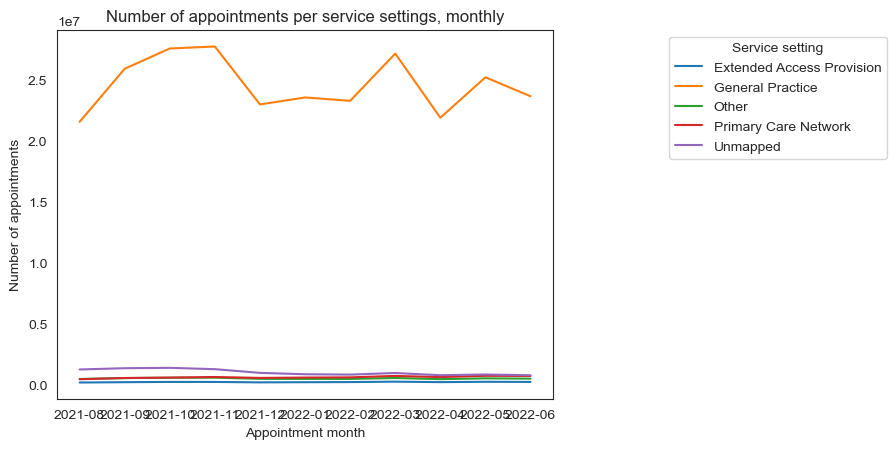

In [168]:
# Plot the appointments over the available date range, and review the service settings for months.
sns.lineplot(x='appointment_month', y='count_of_appointments', data=nc_ss, hue='service_setting')\
            .set_title("Number of appointments per service settings, monthly")

# Adjust Formatting, lables names, ect.
plt.xlabel('Appointment month')
plt.ylabel('Number of appointments')
plt.legend(title='Service setting', bbox_to_anchor=(1.22, 1))

#### Context types:

In [170]:
# Create a separate data set that can be used in future weeks. 
nc_ct = nc[['appointment_month', 'context_type', 'count_of_appointments']].groupby(by=['appointment_month', 'context_type']).sum().reset_index()

# View output.
nc_ct.head()

appointment_month            context_type  count_of_appointments
0           2021-08  Care Related Encounter               20255235
1           2021-08    Inconsistent Mapping                2363093
2           2021-08                Unmapped                1233843
3           2021-09  Care Related Encounter               24404251
4           2021-09    Inconsistent Mapping                2782135

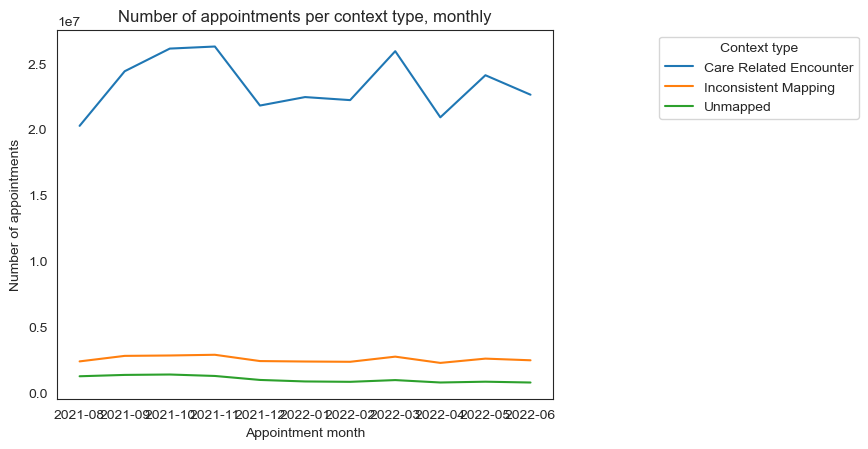

In [171]:
# Plot the appointments over the available date range, and review the context types for months.
sns.lineplot(x='appointment_month', y='count_of_appointments', data=nc_ct, hue='context_type')\
            .set_title("Number of appointments per context type, monthly")

# Adjust Formatting, lables names, ect.
plt.xlabel('Appointment month')
plt.ylabel('Number of appointments')
plt.legend(title='Context type', bbox_to_anchor=(1.2, 1))

#### National categories:

In [173]:
# Create a separate data set that can be used in future weeks. 
nc_nc = nc[['appointment_month', 'national_category', 'count_of_appointments']].groupby(by=['appointment_month', 'national_category'])\
        .sum().reset_index()

# View output.
nc_ct.head()

appointment_month            context_type  count_of_appointments
0           2021-08  Care Related Encounter               20255235
1           2021-08    Inconsistent Mapping                2363093
2           2021-08                Unmapped                1233843
3           2021-09  Care Related Encounter               24404251
4           2021-09    Inconsistent Mapping                2782135

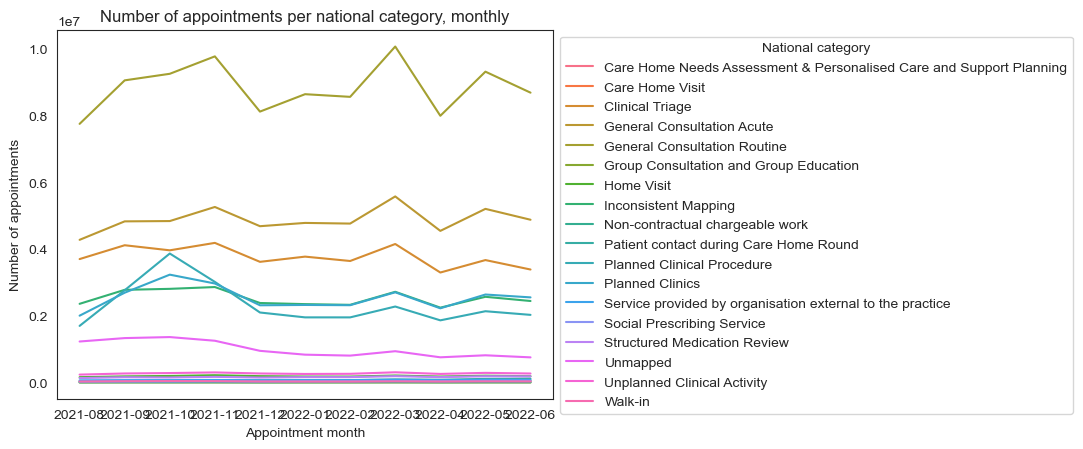

In [174]:
# Plot the appointments over the available date range, and review the national categories for months.
sns.lineplot(x='appointment_month', y='count_of_appointments', data=nc_nc, hue='national_category')\
            .set_title("Number of appointments per national category, monthly")

# Adjust Formatting, lables names, ect.
plt.xlabel('Appointment month')
plt.ylabel('Number of appointments')
plt.legend(title='National category', bbox_to_anchor=(1, 1))

### Objective 2: Create four visualisations indicating the number of appointments for service setting per season:
- Summer (June to August 2021)
- Autumn (September to November 2021)
- Winter (December to February 2022)
- Spring (March to May 2022)

#### Map nc by season:

In [177]:
# view nc appointment_month as a set 
set(nc.appointment_month.unique())

{'2021-08',
 '2021-09',
 '2021-10',
 '2021-11',
 '2021-12',
 '2022-01',
 '2022-02',
 '2022-03',
 '2022-04',
 '2022-05',
 '2022-06'}

In [178]:
# Create a dictionary with 'appointment_month' to 'season' mapping 
""" As per the instruction: The seasons are summer (June to August 2021), autumn (September to November 2021),
    winter (December to February 2022), and spring (March to May 2022)."""

seasons = {'2021-08':'Summer',
           '2021-09':'Autumn',
           '2021-10':'Autumn',
           '2021-11':'Autumn',
           '2021-12':'Winter',
           '2022-01':'Winter',
           '2022-02':'Winter',
           '2022-03':'Spring',
           '2022-04':'Spring',
           '2022-05':'Spring',
           '2022-06':pd.NA}

# view the oupput
print(seasons)
print(type(seasons))

{'2021-08': 'Summer', '2021-09': 'Autumn', '2021-10': 'Autumn', '2021-11': 'Autumn', '2021-12': 'Winter', '2022-01': 'Winter', '2022-02': 'Winter', '2022-03': 'Spring', '2022-04': 'Spring', '2022-05': 'Spring', '2022-06': <NA>}
<class 'dict'>


In [179]:
# create a copy of nc dataframe
nc2 = nc.copy()
# view the optput
nc2.shape

(817394, 13)

In [180]:
# create the 'season' column in the nc2 dataframe and populate it with seasons 
nc2['season'] = nc2['appointment_month'].map(seasons)

# view the output
nc2.head()

appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
2       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
3       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
4       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   
2      General Practice  Care Related Encounter   
3      General Practice  Care Related Encounter   
4      General Practice  Care Related Encounter   

                        national_category  count_of_appointments  \
0  Patient contact during Care Home Round                      3   
1                         Planned Clinics                      7   
2                              Home Visit                     79   
3              General Consultation Acute                    725   
4            Structured Medication Review                      2   

  appointment_month region_ons_code day_of_week           region_ons_name  \
0           2021-08       E40000012      Monday  North East and Yorkshire   
1           2021-08       E40000012      Monday  North East and Yorkshire   
2           2021-08       E40000012      Monday  North East and Yorkshire   
3           2021-08       E40000012      Monday  North East and Yorkshire   
4           2021-08       E40000012      Monday  North East and Yorkshire   

  day_of_week_type      national_category_expl  season  
0          working                       Other  Summer  
1          working                       Other  Summer  
2          working                       Other  Summer  
3          working  General Consultation Acute  Summer  
4          working                       Other  Summer

In [181]:
# sense check the result
nc2[['count_of_appointments', 'appointment_month', 'season']].groupby(by=['appointment_month', 'season']).sum()

count_of_appointments
appointment_month season                       
2021-08           Summer               23852171
2021-09           Autumn               28522501
2021-10           Autumn               30303834
2021-11           Autumn               30405070
2021-12           Winter               25140776
2022-01           Winter               25635474
2022-02           Winter               25355260
2022-03           Spring               29595038
2022-04           Spring               23913060
2022-05           Spring               27495508

In [182]:
# Create a separate data set that can be used in future weeks. 
nc2_ss = nc2[['appointment_date', 'service_setting', 'count_of_appointments', 'season']]\
         .groupby(by=['season', 'appointment_date', 'service_setting']).sum().reset_index()

# View output.
nc2_ss.head()

season appointment_date            service_setting  count_of_appointments
0  Autumn       2021-09-01  Extended Access Provision                   6916
1  Autumn       2021-09-01           General Practice                1041879
2  Autumn       2021-09-01                      Other                  21796
3  Autumn       2021-09-01       Primary Care Network                  21371
4  Autumn       2021-09-01                   Unmapped                  57423

#### Summer (June to August 2021):

In [184]:
nc2_ss[nc2_ss.season == 'Summer'][['appointment_date','count_of_appointments', 'service_setting']]\
.groupby(by=['appointment_date', 'service_setting']).sum().unstack().head()

count_of_appointments                          \
service_setting  Extended Access Provision General Practice  Other   
appointment_date                                                     
2021-08-01                             438             3411    401   
2021-08-02                            7705          1108073  22098   
2021-08-03                            7820          1056435  21662   
2021-08-04                            6917           988285  20954   
2021-08-05                            6841           968191  20610   

                                                
service_setting  Primary Care Network Unmapped  
appointment_date                                
2021-08-01                        323     1054  
2021-08-02                      20016    64876  
2021-08-03                      21381    62622  
2021-08-04                      19877    57499  
2021-08-05                      20685    57716

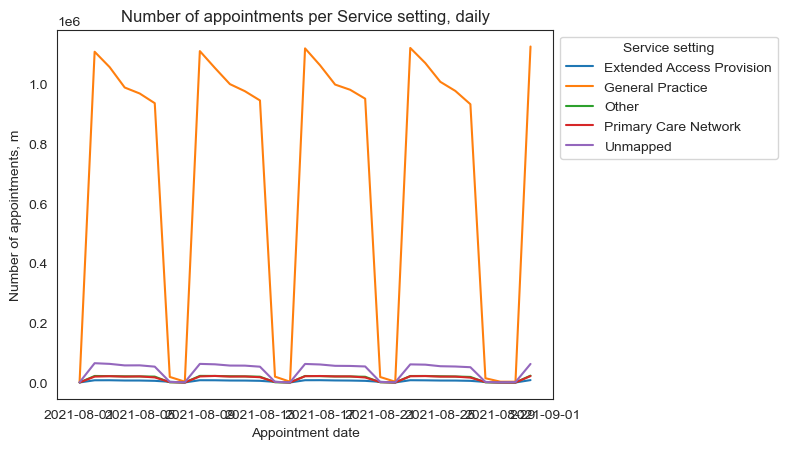

In [185]:
# Look at June to August 2021 in more detail to allow a closer look.
sns.lineplot(x='appointment_date', y='count_of_appointments', data=nc2_ss[nc2_ss.season == 'Summer'], hue='service_setting')\
            .set_title("Number of appointments per Service setting, daily")

# Adjust Formatting, lables names, ect.
plt.xlabel('Appointment date')
plt.ylabel('Number of appointments, m')
plt.legend(title='Service setting', bbox_to_anchor=(1, 1))

#### Autumn (September to November 2021):

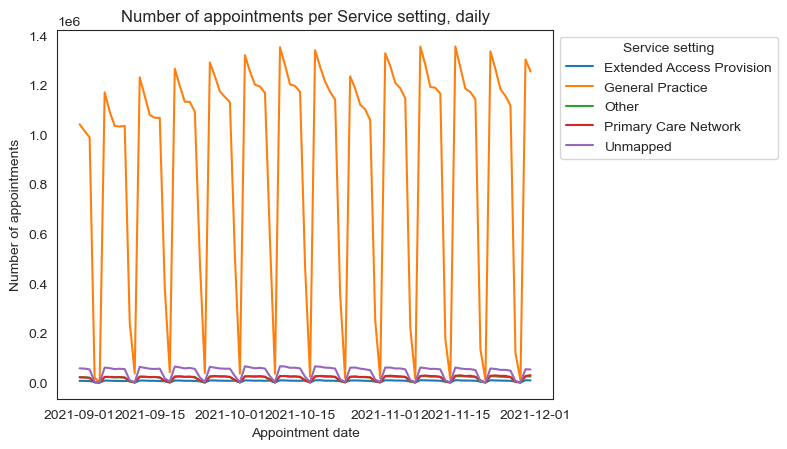

In [187]:
# Look at September to November 2021 in more detail to allow a closer look.
sns.lineplot(x='appointment_date', y='count_of_appointments', data=nc2_ss[nc2_ss.season == 'Autumn'], hue='service_setting')\
            .set_title("Number of appointments per Service setting, daily")

# Adjust Formatting, lables names, ect.
plt.xlabel('Appointment date')
plt.ylabel('Number of appointments')
plt.legend(title='Service setting', bbox_to_anchor=(1, 1))

#### Winter (December to February 2022):

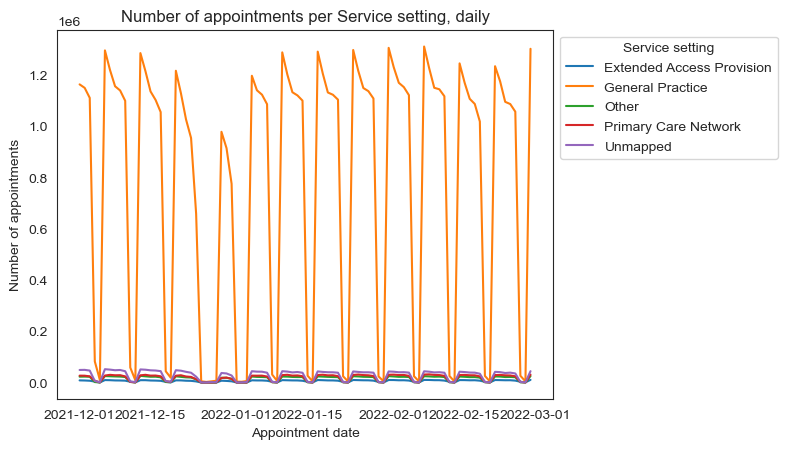

In [189]:
# Look at December to February 2022 in more detail to allow a closer look.
sns.lineplot(x='appointment_date', y='count_of_appointments', data=nc2_ss[nc2_ss.season == 'Winter'], hue='service_setting')\
            .set_title("Number of appointments per Service setting, daily")

# Adjust Formatting, lables names, ect.
plt.xlabel('Appointment date')
plt.ylabel('Number of appointments')
plt.legend(title='Service setting', bbox_to_anchor=(1, 1))


#### Spring (March to May 2022):

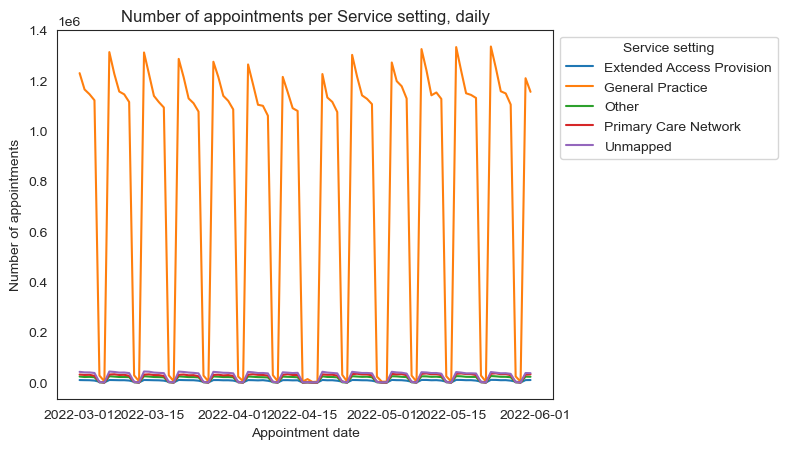

In [191]:
# Look at March to May 2022 in more detail to allow a closer look.
sns.lineplot(x='appointment_date', y='count_of_appointments', data=nc2_ss[nc2_ss.season == 'Spring'], hue='service_setting')\
            .set_title("Number of appointments per Service setting, daily")

# Adjust Formatting, lables names, ect.
plt.xlabel('Appointment date')
plt.ylabel('Number of appointments')
plt.legend(title='Service setting', bbox_to_anchor=(1, 1))


### Weekdays analysis

**Observation:** Sep-Nov 2021 NHS was busier than usually

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, '2021-08'),
  Text(1, 0, '2021-09'),
  Text(2, 0, '2021-10'),
  Text(3, 0, '2021-11'),
  Text(4, 0, '2021-12'),
  Text(5, 0, '2022-01'),
  Text(6, 0, '2022-02'),
  Text(7, 0, '2022-03'),
  Text(8, 0, '2022-04'),
  Text(9, 0, '2022-05'),
  Text(10, 0, '2022-06')])

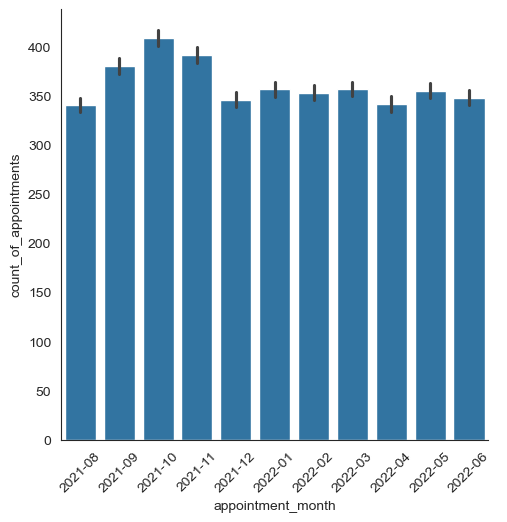

In [194]:
# Create a box plot to analyse data by 'day_of_week'
sns.catplot(data=nc2, x='appointment_month', y='count_of_appointments', kind='bar')
plt.xticks(rotation=45)

**Observation:**

- The number of appointments on Saturdays and Sundays dramatically increased in Sep-Oct 2021, returning to normal through Nov-Dec 2021. In Sep-Nov 2021 weekdsys were busier.
- Overall, there is a tendency for the workload to decrease from Monday to Friday. With significantly lower workload during the weekend (with the exception of the period between Sep-Oct 2021)


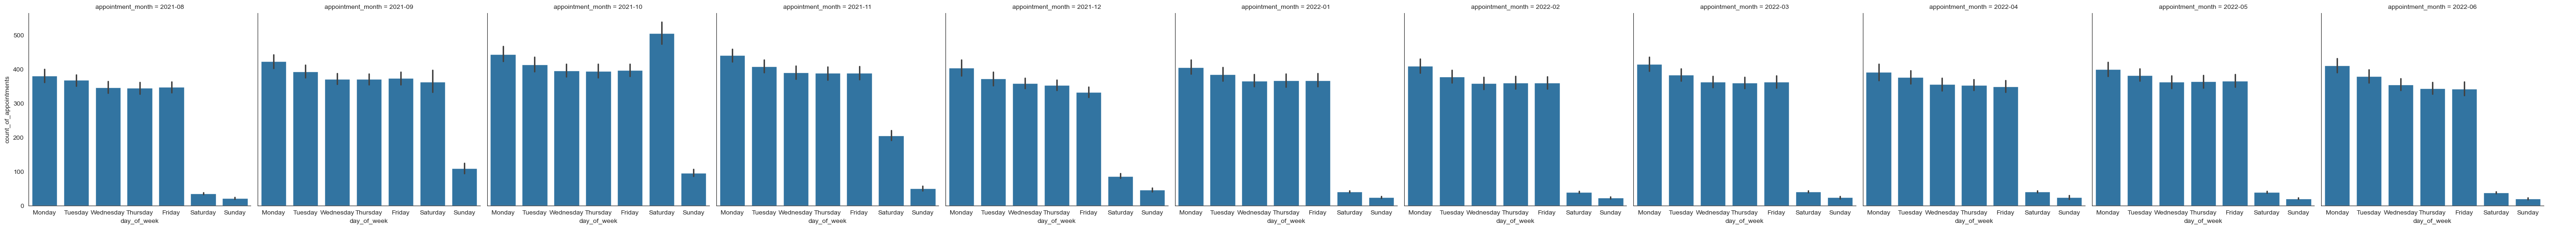

In [196]:
# Create a box plot to analyse data by 'day_of_week'
sns.catplot(data=nc2, x='day_of_week', y='count_of_appointments', order=nc2.day_of_week.unique(),\
            kind='bar', col='appointment_month')

**Observation:** Data quality improved in December 2021 with the average daily number of Unmapped (service setting) appointments decreasing. This dynamics doesn't match an opposite one in any of the other service setting categories.

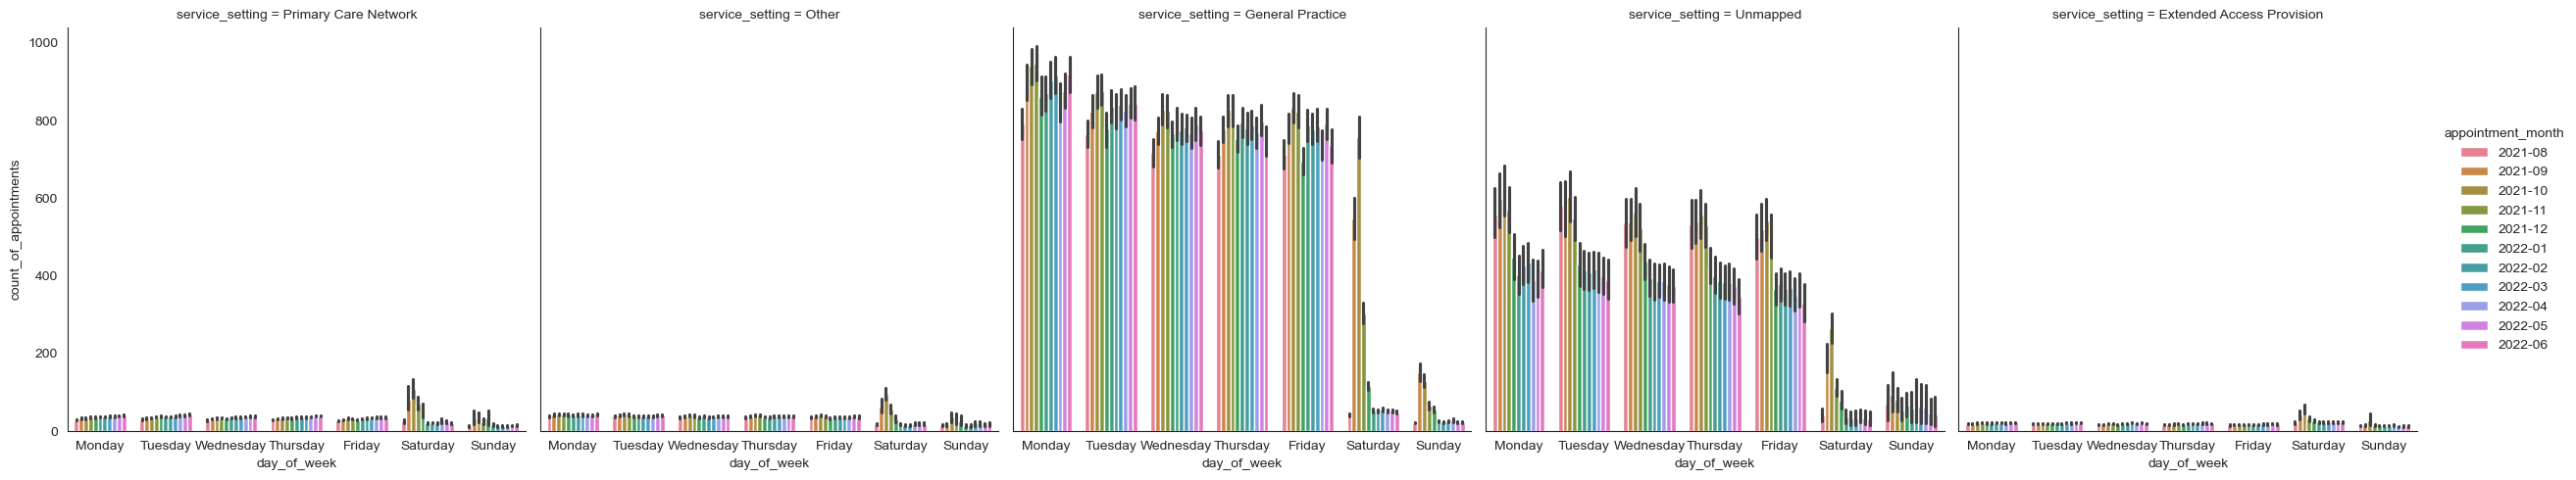

In [198]:
# Create a box plot to analyse data by 'day_of_week'
sns.catplot(data=nc2, x='day_of_week', y='count_of_appointments', order=nc2.day_of_week.unique(),\
            kind='bar', hue='appointment_month', col='service_setting')

# 

# Analyse tweets from Twitter with hashtags related to healthcare in the UK.

In [201]:
# View the DataFrame.
tw.head()

tweet_id                                    tweet_full_text  \
0  1567629223795527681  As Arkansas’ first Comprehensive Stroke Certif...   
1  1567582846612553728  RT @AndreaGrammer: Work-life balance is at the...   
2  1567582787070304256  RT @OntarioGreens: $10 billion can go a long w...   
3  1567582767625428992  RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...   
4  1567582720460570625  ICYMI: Our recent blogs on Cybersecurity in Ac...   

                                      tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices'...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indic...   
2  {'hashtags': [{'text': 'Healthcare', 'indices'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, ...   
4  {'hashtags': [{'text': 'blogs', 'indices': [18...   

                             tweet_entities_hashtags  \
0                                        #Healthcare   
1                            #PremiseHealth, #hiring   
2                                        #Healthcare   
3                                               #NEW   
4  #blogs, #digitaltransformation, #cybersecurity...   

                                      tweet_metadata  tweet_retweet_count  \
0  {'iso_language_code': 'en', 'result_type': 're...                    0   
1  {'iso_language_code': 'en', 'result_type': 're...                    2   
2  {'iso_language_code': 'en', 'result_type': 're...                   39   
3  {'iso_language_code': 'en', 'result_type': 're...                    5   
4  {'iso_language_code': 'en', 'result_type': 're...                    0   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en  
2                     0            False            False         en  
3                     0            False            False         en  
4                     0            False            False         en

In [202]:
# Explore Explore the data set with the info() function.
tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          1174 non-null   bool  
 8   tweet_retweeted          1174 non-null   bool  
 9   tweet_lang               1174 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 75.8+ KB


In [203]:
tw['tweet_id'] = tw['tweet_id'].astype('object')

In [204]:
# Explore Explore the data set with the describe() function.
tw.describe()

tweet_retweet_count  tweet_favorite_count
count          1174.000000            1174.00000
mean              8.629472               0.37138
std              29.784675               2.04470
min               0.000000               0.00000
25%               0.000000               0.00000
50%               1.000000               0.00000
75%               3.000000               0.00000
max             303.000000              42.00000

In [205]:
# Explore the tweet_retweet_count column with the value_counts() function.
tw.tweet_retweet_count.value_counts().sort_index()

tweet_retweet_count
0      526
1      215
2      114
3       70
4       27
5       35
6       12
7       18
8       15
9       13
10       5
11       6
12      16
13       1
14       1
15       1
16       2
19       1
20       1
23       2
24       2
35      10
37       6
39       1
40       1
41       3
44       4
48       1
49       1
53       5
54       1
57       1
62       3
63       4
68       3
72       2
73      14
76       3
78       2
79       1
85       3
107      1
150      4
169      1
207      3
208     12
303      1
Name: count, dtype: int64

<Axes: xlabel='tweet_retweet_count'>

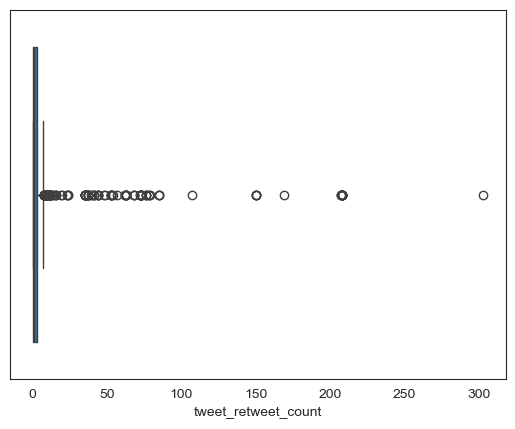

In [206]:
# Explore the tweet_retweet_count with boxplot.
sns.boxplot(data=tw, x='tweet_retweet_count')

<Axes: xlabel='tweet_retweet_count', ylabel='Count'>

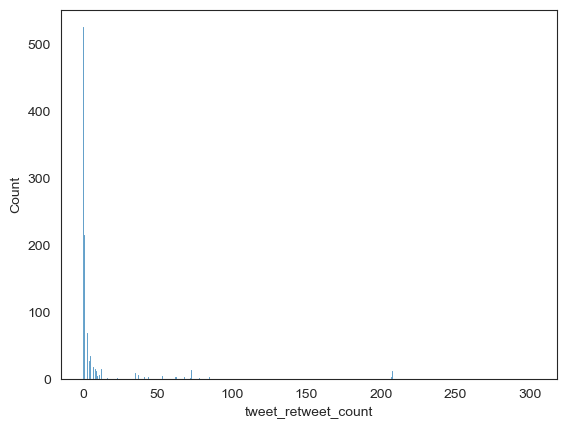

In [207]:
# Explore the tweet_retweet_count distribution with histogram.
sns.histplot(data=tw, x='tweet_retweet_count')

In [208]:
# Explore the tweet_favorite_count column with the value_counts() function.
tw.tweet_favorite_count.value_counts().sort_index()

tweet_favorite_count
0     1027
1       91
2       16
3       13
4        7
5        5
6        2
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
17       1
18       1
20       1
28       1
42       1
Name: count, dtype: int64

<Axes: xlabel='tweet_favorite_count', ylabel='Count'>

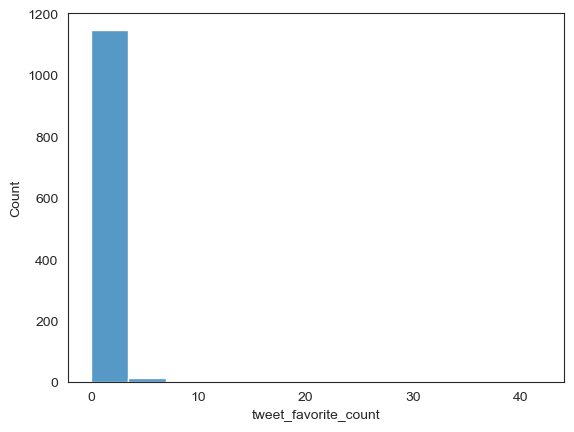

In [209]:
# Explore the tweet_favorite_count distribution with histogram.
sns.histplot(data=tw, x='tweet_favorite_count')

In [210]:
# Create a new DataFrame containing only the text.
tweets_text = tw['tweet_full_text']

# View the DataFrame.
tweets_text

0       As Arkansas’ first Comprehensive Stroke Certif...
1       RT @AndreaGrammer: Work-life balance is at the...
2       RT @OntarioGreens: $10 billion can go a long w...
3       RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...
4       ICYMI: Our recent blogs on Cybersecurity in Ac...
                              ...                        
1169    RT @PotomacPhotonic: Potomac #Innovation Repor...
1170    Not a cent towards workers who would like to a...
1171    The @hfmaorg Region 9 presents "The Value of E...
1172    Happy physiotherapy 🩺 day 🎉..\n#bpt #physiothe...
1173    RT @KimcoStaffing: Apply now to work for #Medi...
Name: tweet_full_text, Length: 1174, dtype: object

##### Suggested approach (tags)

In [212]:
# Create a variable (tags), and assign an empty list to it.
tags = []

In [213]:
# Loop through the messages, and create a list of values containing the # symbol.
for y in [x.split(' ') for x in tw['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags.append(z.lower())

In [214]:
# sense-check the output
print(type(tags))
print(len(tags))
print(tags)

<class 'list'>
4333
['#healthcare', '#premisehealth', '#hiring', '#healthcare', '🚨#new:🚨', 'look!\n\n#blogs', '#digitaltransformation', '#cybersecurity', '#accounting', '#finance', '#healthcare', 'https://t.co/jrgqeqdme4\n.\n#firstcoastcna', '#cnaexam', '#cnaexampreparation', '#jacksonville', '#cnatraining', '#nurse', '#nursing', '#nurselife', '#nursepractitioner', '#nurseproblems', '#nursingschool', '#healthcare', '🚨#new:🚨', '#disparities.', '@karahartnett\n#healthcare', '#alert', '#insurance', '#data\nhttps://t.co/h9hlamr7p9', '#healthcare', '#healthcare', '❤️\n\n#healthcare', '#healthcare', '#hcldr', '#premisehealth', '#hiring', '#premisehealth', '#hiring', '#healthcare', '#qualitypatientcare', '#jobs', '#job', '#ascp2022', '#ascp100.', '#healthcare', '#healthsecretary', '#healthcare', '#ai,', '#sdoh,', '#healthcare', '\nhttps://t.co/ewe7jntj1e\n#tropicana', '#real', '#juice', '#healthcare', '#watch', '#worms', '#fruits', '#healthtips', '#tips', '#healthcare', '#thewoodlands,', '#he

**Observation:** 

There are invalid hashtags in the tags list.

An alternative approach is applied below 

Examples: 

- '🚨#new:🚨'
- 'look!\n\n#blogs'
- drugs\n\n#tipsfornewdocs
- 'https://t.co/jrgqeqdme4\n.\n#firstcoastcna'

##### Alternative approach (tags_alt)

In [217]:
# Create a variable (tags_alt), and assign an empty list to it.
tags_alt = []

# Define the regex pattern to match hashtags
pattern = r"#\w+"

In [218]:
# Loop through the messages, and create a list of values containing the # symbol.
for y in [re.findall(pattern, x) for x in tw['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags_alt.append(z.lower())

In [219]:
# sense-check the output
print(type(tags_alt))
print(len(tags_alt))
print(tags_alt)

<class 'list'>
4378
['#healthcare', '#premisehealth', '#hiring', '#healthcare', '#new', '#blogs', '#digitaltransformation', '#cybersecurity', '#accounting', '#finance', '#healthcare', '#firstcoastcna', '#cnaexam', '#cnaexampreparation', '#jacksonville', '#cnatraining', '#nurse', '#nursing', '#nurselife', '#nursepractitioner', '#nurseproblems', '#nursingschool', '#healthcare', '#new', '#disparities', '#healthcare', '#alert', '#insurance', '#data', '#healthcare', '#healthcare', '#healthcare', '#healthcare', '#hcldr', '#premisehealth', '#hiring', '#premisehealth', '#hiring', '#healthcare', '#qualitypatientcare', '#jobs', '#job', '#ascp2022', '#ascp100', '#healthcare', '#healthsecretary', '#healthcare', '#ai', '#sdoh', '#healthcare', '#tropicana', '#real', '#juice', '#healthcare', '#watch', '#worms', '#fruits', '#healthtips', '#tips', '#healthcare', '#thewoodlands', '#healthcare', '#chicago', '#healthcare', '#telehealth', '#healthcare', '#virtualcare', '#mediqueststaffing', '#hospital', '#

##### Compare Suggested (tags) vs. Alternative approaches (tags_alt)

In [221]:
# remove duplicates from both the hashtag lists by converting them to sets 
tags_alt_set =  set(tags_alt)
tags_set =  set(tags)

# View the number of unique of hashtags extracted applying different approaches  
print(len(tags_set))
print(len(tags_alt_set))

1754
1559


In [222]:
# find intersection 
int_set = tags_alt_set.intersection(tags_set)

# View and sense-check the output
print(len(int_set))
print(int_set)

1213
{'#commonsense', '#student', '#ontariohealthcare', '#biotech', '#recruiting', '#flooring', '#familycare', '#scheduling', '#expenditures', '#tshirtdesignrequired', '#mepolitics', '#rto', '#industry40', '#cdwsocial', '#itsm', '#newhealthcare', '#barostim', '#success', '#mergers', '#hla', '#breach', '#hormonesandyourhealth', '#developments', '#databreach', '#theadultentertainment', '#lbl', '#sask', '#texasmom', '#democrat', '#dougford', '#generalstrike', '#financialfreedom', '#mrinetwork', '#fun', '#fraud', '#healthapps', '#nahha', '#cdnpoli', '#ches2022', '#veterans', '#medicationsafety', '#smartglasses', '#medicaremedicaid', '#investment', '#positions', '#paymentgateway', '#nursingassistant', '#cmms', '#prop29', '#epiccare', '#executivecoaching', '#botox', '#diseases', '#onlineconsultation', '#military', '#nursing', '#encouraging', '#educational', '#ontarionews', '#recruitment', '#nonbinary', '#communityhealth', '#spokane', '#leadership', '#java', '#deception', '#des', '#wellbeing'

In [223]:
# Keep only unique elements in each of the sets (remove elements the intersection)
tags_alt_set_only = tags_alt_set - set(int_set)
tags_set_only = tags_set - set(int_set)

# View the number of unique of hashtags exclusive to each of the approaches 
print(len(tags_set_only))
print(len(tags_alt_set_only))

541
346


In [224]:
# Sense-check tags_set_only 
print(len(tags_set_only))
print(tags_set_only)

541
{'#kpis,', 'trudeau\n👉https://t.co/h0tug2rnt1\n\n#spanishtranslation', '\n#wallstreet', '#medica…', '\n\n#shortsqueeze', 'october.\n\n#healthcare', '#healthcare\n\nhttps://t.co/mobuuakhnr', '#healthpromotion\n#chiropractor', '#costamesa,', '\n#meadowwind', 'https://t.co/fxcijqc94v\n\n#solvecare', '#dis…', '#compliance\ncloud', "#healthcare's", 'https://t.co/gcsyujuhkl\n\n#healthyfood', '#clinicaltrial.', 'kitchen:\n\nhttps://t.co/vzehn5bazt…\n\n#healthcar…', '#healthcareprofessionals!', '#heal…', '#newhealthcare\xa0', '#devops…', '#healthcareprofes…', '#healthequity.', '#hackensack,', '#wearables…', '\n\n#payments', '#insuranc…', '#health.', '#micro\n#labor\n#statistics', 'https://t.co/jrgqeqdme4\n.\n#firstcoastcna', '😅\n#ih22', 'lying\n\n#trump', '#nursing…https://t.co/q9hofpoffq', '📢#kubernetes', '@karahartnett\n#healthcare', '#investinher!\n\ni', '#personalfinance#property', 'treatment\n\n#tipsfornewdocs', 'ffs\n#healthcare', '#primaryca…', 'future\n\nhttps://t.co/hctoc1vady\n\n

In [225]:
# Sense-check tags_alt_set_only 
print(len(tags_alt_set_only))
print(tags_alt_set_only)

346
{'#d', '#ptsafet', '#category', '#delltec', '#meditechlive2022', '#healthynation', '#healthcareprofes', '#homophobic', '#rcm', '#foodinsecurity', '#canton', '#newbraunfels', '#protectwomen', '#maths', '#statistics', '#terrehaute', '#innovations', '#medicar', '#financialastrology', '#databr', '#eastlansing', '#benefits', '#healthyfood', '#resist', '#tabbednews', '#solvingwhatmatters', '#psychiatry', '#albuquerque', '#asnc2022', '#indianbusinesslisting', '#incubator', '#di', '#shortsqueeze', '#roevswade', '#gocltcc', '#lagossdginvest', '#charity', '#sdoh', '#portolavalley', '#clubbing', '#nu', '#disabili', '#rmleadershipacademy', '#competi', '#heforshe', '#hippotechnologies', '#digitalsignage', '#maine', '#paidtimeoff', '#ih22', '#housing', '#scottsdale', '#scicomm', '#amazon', '#fundraising', '#healthcaringisyourcalling', '#vot', '#ccctx', '#primehealth', '#westhamptonwave', '#arkansas', '#compliance', '#new', '#bigpharma', '#stra', '#hipaacompliance', '#columbia', '#trucking', '#we

**Observation:** 

Given higher data quality in tags_alt_set, further analysis will be conducted based on the 'tags_alt' list.

##### Continue analysis based on the Selected approach - Alternative approach (tags_alt)

In [228]:
# Create a Pandas Series to count the values in the list. Set the Series equal to tags
tags_ser = pd.Series(tags_alt)

In [229]:
# sense-check the series
print(type(tags_ser))
print(tags_ser.shape)

<class 'pandas.core.series.Series'>
(4378,)


In [230]:
# Count the tags with the value_counts() function.
tags_ser = tags_ser.value_counts().sort_values(ascending=False)

In [231]:
# Display the first 30 records.
tags_ser.head(30)

#healthcare                 844
#health                      88
#ai                          47
#medicine                    42
#job                         38
#medical                     35
#strategy                    31
#digitalhealth               31
#pharmaceutical              28
#medtwitter                  27
#biotech                     25
#pharma                      25
#competitiveintelligence     25
#marketing                   25
#meded                       24
#telehealth                  22
#covid                       21
#tipsfornewdocs              21
#hiring                      21
#healthtech                  18
#machinelearning             18
#technology                  18
#vaccine                     18
#medicare                    17
#news                        17
#competitivemarketing        16
#coronavirus                 16
#womeninmedicine             16
#tech                        15
#wellness                    15
Name: count, dtype: int64

In [232]:
# Convert the series to a DataFrame in preparation for visualisation.
tags_df = tags_ser.reset_index()

# Rename the columns.
tags_df.columns = ['word','count']

# view the output
tags_df

word  count
0                         #healthcare    844
1                             #health     88
2                                 #ai     47
3                           #medicine     42
4                                #job     38
...                               ...    ...
1554  #panchomedranolegislativesummit      1
1555                             #hcw      1
1556         #childrenscardiomyophaty      1
1557             #heartchildrensmonth      1
1558                           #csjmu      1

[1559 rows x 2 columns]

In [233]:
# Fix the count datatype.
tags_df['count'].astype(int) 

# View the result.
tags_df

word  count
0                         #healthcare    844
1                             #health     88
2                                 #ai     47
3                           #medicine     42
4                                #job     38
...                               ...    ...
1554  #panchomedranolegislativesummit      1
1555                             #hcw      1
1556         #childrenscardiomyophaty      1
1557             #heartchildrensmonth      1
1558                           #csjmu      1

[1559 rows x 2 columns]

In [234]:
# Sense-check the DataFrame.
print(tags_df.sum())
print(tags_df.describe())
print(tags_df.shape)
print(tags_df.info)
print(tags_df.dtypes)

word     #healthcare#health#ai#medicine#job#medical#str...
count                                                 4378
dtype: object
             count
count  1559.000000
mean      2.808210
std      21.748942
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max     844.000000
(1559, 2)
<bound method DataFrame.info of                                  word  count
0                         #healthcare    844
1                             #health     88
2                                 #ai     47
3                           #medicine     42
4                                #job     38
...                               ...    ...
1554  #panchomedranolegislativesummit      1
1555                             #hcw      1
1556         #childrenscardiomyophaty      1
1557             #heartchildrensmonth      1
1558                           #csjmu      1

[1559 rows x 2 columns]>
word     object
count     int64
dtype: object


In [235]:
# Filter records where the count is larger than 10 and assign to a new variable.
tags_df_top = tags_df[tags_df['count'] > 10]

# Display records where the count is larger than 10.
tags_df_top

word  count
0                   #healthcare    844
1                       #health     88
2                           #ai     47
3                     #medicine     42
4                          #job     38
5                      #medical     35
6                     #strategy     31
7                #digitalhealth     31
8               #pharmaceutical     28
9                   #medtwitter     27
10                     #biotech     25
11                      #pharma     25
12     #competitiveintelligence     25
13                   #marketing     25
14                       #meded     24
15                  #telehealth     22
16                       #covid     21
17              #tipsfornewdocs     21
18                      #hiring     21
19                  #healthtech     18
20             #machinelearning     18
21                  #technology     18
22                     #vaccine     18
23                    #medicare     17
24                        #news     17
25        #competitivemarketing     16
26                 #coronavirus     16
27             #womeninmedicine     16
28                        #tech     15
29                    #wellness     15
30                     #covid19     15
31                #telemedicine     14
32                     #science     14
33                   #education     14
34                     #nursing     14
35  #doctorofveterinarymedicine     14
36                         #new     13
37                 #patientcare     13
38                #mentalhealth     13
39                      #foamed     13
40                      #doctor     12
41                   #hospitals     12
42                        #data     12
43                      #nurses     12
44                     #medtech     11
45                  #innovation     11
46                #healthcareit     11
47                         #usa     11
48                      #python     11
49       #digitaltransformation     11

In [236]:
#calculate quartiles for points column
first_q = tags_df_top['count'].quantile([0.25]).values[0]
third_q = tags_df_top['count'].quantile([0.75]).values[0]
IQR = third_q - first_q
upper_fence = third_q + 1.5*IQR
lower_fence = max(first_q - 1.5*IQR, 0)
print(lower_fence, upper_fence)

0 43.0


In [237]:
# Identify outliers using the interquartile range (IQR) method
outliers = tags_df_top[tags_df_top['count'] > upper_fence]

# view the output
outliers

word  count
0  #healthcare    844
1      #health     88
2          #ai     47

**Observation:**

There are three outliers identified using the interquartile range (IQR) method: #healthcare, #health and #ai hashtags with the count of 844, 88 and 47, respectively.

In [239]:
# Remove outliers (#healthcare, #health and #ai hashtags) as overrepresented, considering the outliers analysis above.
plot_data = tags_df_top[tags_df_top['count'] <= upper_fence]

# view the output
plot_data

word  count
3                     #medicine     42
4                          #job     38
5                      #medical     35
6                     #strategy     31
7                #digitalhealth     31
8               #pharmaceutical     28
9                   #medtwitter     27
10                     #biotech     25
11                      #pharma     25
12     #competitiveintelligence     25
13                   #marketing     25
14                       #meded     24
15                  #telehealth     22
16                       #covid     21
17              #tipsfornewdocs     21
18                      #hiring     21
19                  #healthtech     18
20             #machinelearning     18
21                  #technology     18
22                     #vaccine     18
23                    #medicare     17
24                        #news     17
25        #competitivemarketing     16
26                 #coronavirus     16
27             #womeninmedicine     16
28                        #tech     15
29                    #wellness     15
30                     #covid19     15
31                #telemedicine     14
32                     #science     14
33                   #education     14
34                     #nursing     14
35  #doctorofveterinarymedicine     14
36                         #new     13
37                 #patientcare     13
38                #mentalhealth     13
39                      #foamed     13
40                      #doctor     12
41                   #hospitals     12
42                        #data     12
43                      #nurses     12
44                     #medtech     11
45                  #innovation     11
46                #healthcareit     11
47                         #usa     11
48                      #python     11
49       #digitaltransformation     11

Text(0, 0.5, 'hashtag')

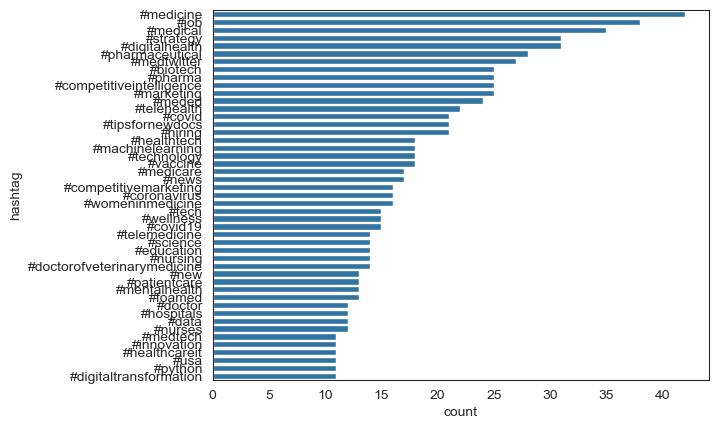

In [240]:
# Create a Seaborn barplot indicating records with a count >10 records, excluding overrepresented. 
sns.barplot(plot_data, y='word', x='count')

# Set the y-axis label
plt.ylabel('hashtag')

# 

# Assess the full capacity and actual utilisation of existing infrastructure and resources

### Average appointment per calendar day monthly: barplot

**Observation:** Significant variability month-over-month & within months on a daily basis. - > have a closer look

In [245]:
# Subset and group DataFrame for analysis
nc_daily = nc[['appointment_month', 'appointment_date', 'day_of_week', 'count_of_appointments']]\
.groupby(by=['appointment_month', 'appointment_date', 'day_of_week']).sum().reset_index()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, '2021-08'),
  Text(1, 0, '2021-09'),
  Text(2, 0, '2021-10'),
  Text(3, 0, '2021-11'),
  Text(4, 0, '2021-12'),
  Text(5, 0, '2022-01'),
  Text(6, 0, '2022-02'),
  Text(7, 0, '2022-03'),
  Text(8, 0, '2022-04'),
  Text(9, 0, '2022-05'),
  Text(10, 0, '2022-06')])

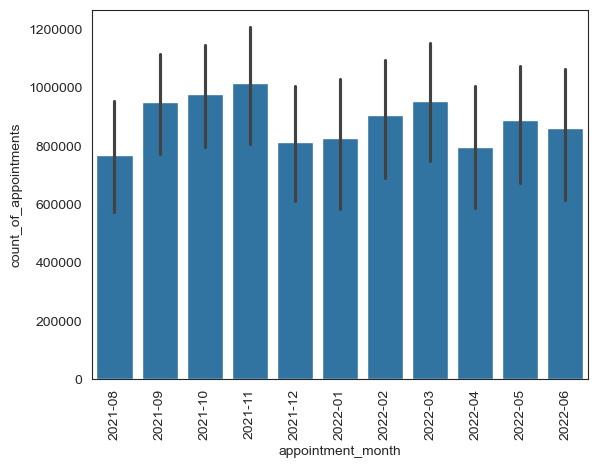

In [246]:
sns.barplot(data=nc_daily, x='appointment_month', y='count_of_appointments', estimator='mean')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=90)

### Average total appointments per day daily (for a selected month): DataFrame

**Observation:** There are clusters by working day vs. holiday. => analyse separately + map bank holidays and weekends (is_holiday user-defined function)

In [249]:
nc_daily[nc_daily.appointment_month == '2021-08']

appointment_month appointment_date day_of_week  count_of_appointments
0            2021-08       2021-08-01      Sunday                   5627
1            2021-08       2021-08-02      Monday                1222768
2            2021-08       2021-08-03     Tuesday                1169920
3            2021-08       2021-08-04   Wednesday                1093532
4            2021-08       2021-08-05    Thursday                1074043
5            2021-08       2021-08-06      Friday                1032165
6            2021-08       2021-08-07    Saturday                  26245
7            2021-08       2021-08-08      Sunday                   5173
8            2021-08       2021-08-09      Monday                1223650
9            2021-08       2021-08-10     Tuesday                1167188
10           2021-08       2021-08-11   Wednesday                1104807
11           2021-08       2021-08-12    Thursday                1080555
12           2021-08       2021-08-13      Friday                1041610
13           2021-08       2021-08-14    Saturday                  27828
14           2021-08       2021-08-15      Sunday                   5130
15           2021-08       2021-08-16      Monday                1232911
16           2021-08       2021-08-17     Tuesday                1174794
17           2021-08       2021-08-18   Wednesday                1102558
18           2021-08       2021-08-19    Thursday                1084160
19           2021-08       2021-08-20      Friday                1047001
20           2021-08       2021-08-21    Saturday                  25701
21           2021-08       2021-08-22      Sunday                   4997
22           2021-08       2021-08-23      Monday                1232902
23           2021-08       2021-08-24     Tuesday                1181716
24           2021-08       2021-08-25   Wednesday                1109957
25           2021-08       2021-08-26    Thursday                1077672
26           2021-08       2021-08-27      Friday                1024990
27           2021-08       2021-08-28    Saturday                  21146
28           2021-08       2021-08-29      Sunday                   4866
29           2021-08       2021-08-30      Monday                   5344
30           2021-08       2021-08-31     Tuesday                1241215

### Average total appointments per day monthly (by 'day_of_week_type'): barplot

**Observation:** 

We observe two clusters (working days/holidays) and seasonal trends.

1) September - November have a considerably higher average number of appointments per day on both weekdays and holidays -> an indicator of high workload
2) Lower average total appointments per day in December -> have a closer look 

In [252]:
# Subset and group DataFrame for analysis
nc_dwt_daily = nc[['appointment_date', 'appointment_month', 'day_of_week', 'day_of_week_type', 'count_of_appointments']]\
.groupby(by=['appointment_date', 'appointment_month', 'day_of_week', 'day_of_week_type']).sum().reset_index()

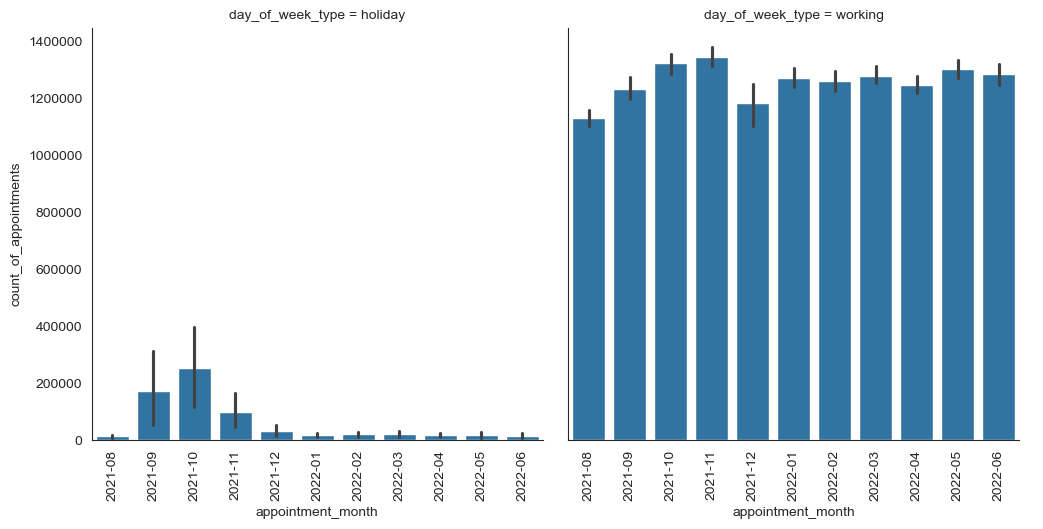

In [253]:
g = sns.catplot(data=nc_dwt_daily, x='appointment_month', y='count_of_appointments', \
            col='day_of_week_type', estimator='mean', kind='bar')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

for ax in g.axes.flat:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Average total appointments per day monthly (by 'day_of_week_type' & 'region_ons_name'): lineplot

**Observation:** The pattern is consistent region-over-region

In [256]:
# Subset and group DataFrame for analysis
nc_dwt_reg_daily = nc[['appointment_date', 'appointment_month', 'day_of_week', 'day_of_week_type', 'region_ons_name', 'count_of_appointments']]\
.groupby(by=['appointment_date', 'appointment_month', 'day_of_week', 'day_of_week_type', 'region_ons_name']).sum().reset_index()

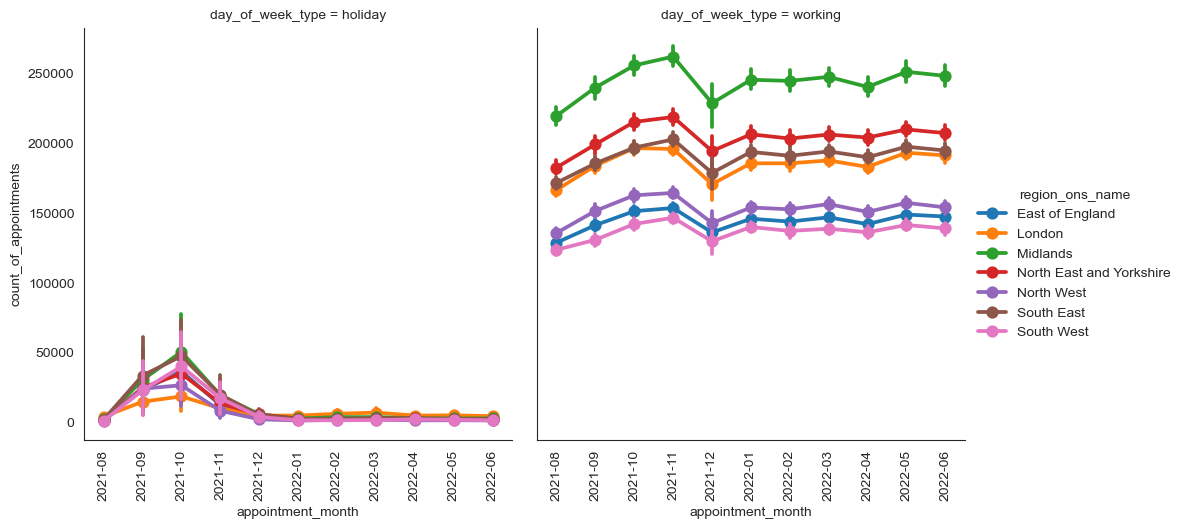

In [257]:
g = sns.catplot(data=nc_dwt_reg_daily, x='appointment_month', y='count_of_appointments', \
            col='day_of_week_type', hue='region_ons_name', estimator='mean', kind='point')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

for ax in g.axes.flat:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Average total appointments per day daily by 'day_of_week' for working only: barplot

**Observation:** There is a pattern in the number of average appointments per day on weekdays with the workload decreasing from Monday to Friday

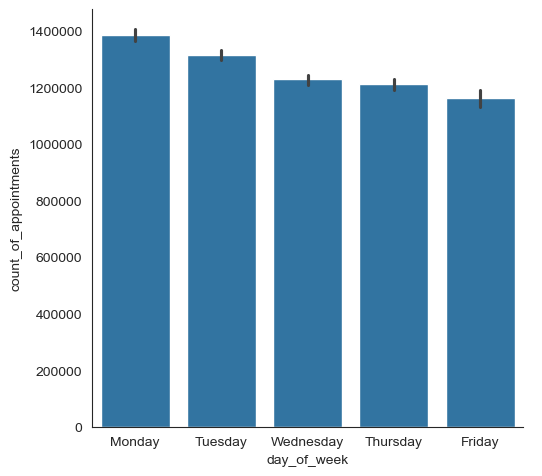

In [260]:
sns.catplot(data=nc_dwt_daily[nc_dwt_daily.day_of_week_type == 'working'], x='day_of_week', y='count_of_appointments', \
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], \
            estimator='mean', kind='bar')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

### Average appointment per day daily by 'day_of_week' per Region and Month for working only: barplot

**Observation:** 
1) The pattern is consistent region-over-region and month-over-month
3) There is a higher IQR in Dec-21. This is explained by the significantly lower appointment count on 24th and 31st Dec. This explains the lower daily average appointments in Dec. There are no implications for further analysis as immaterial.

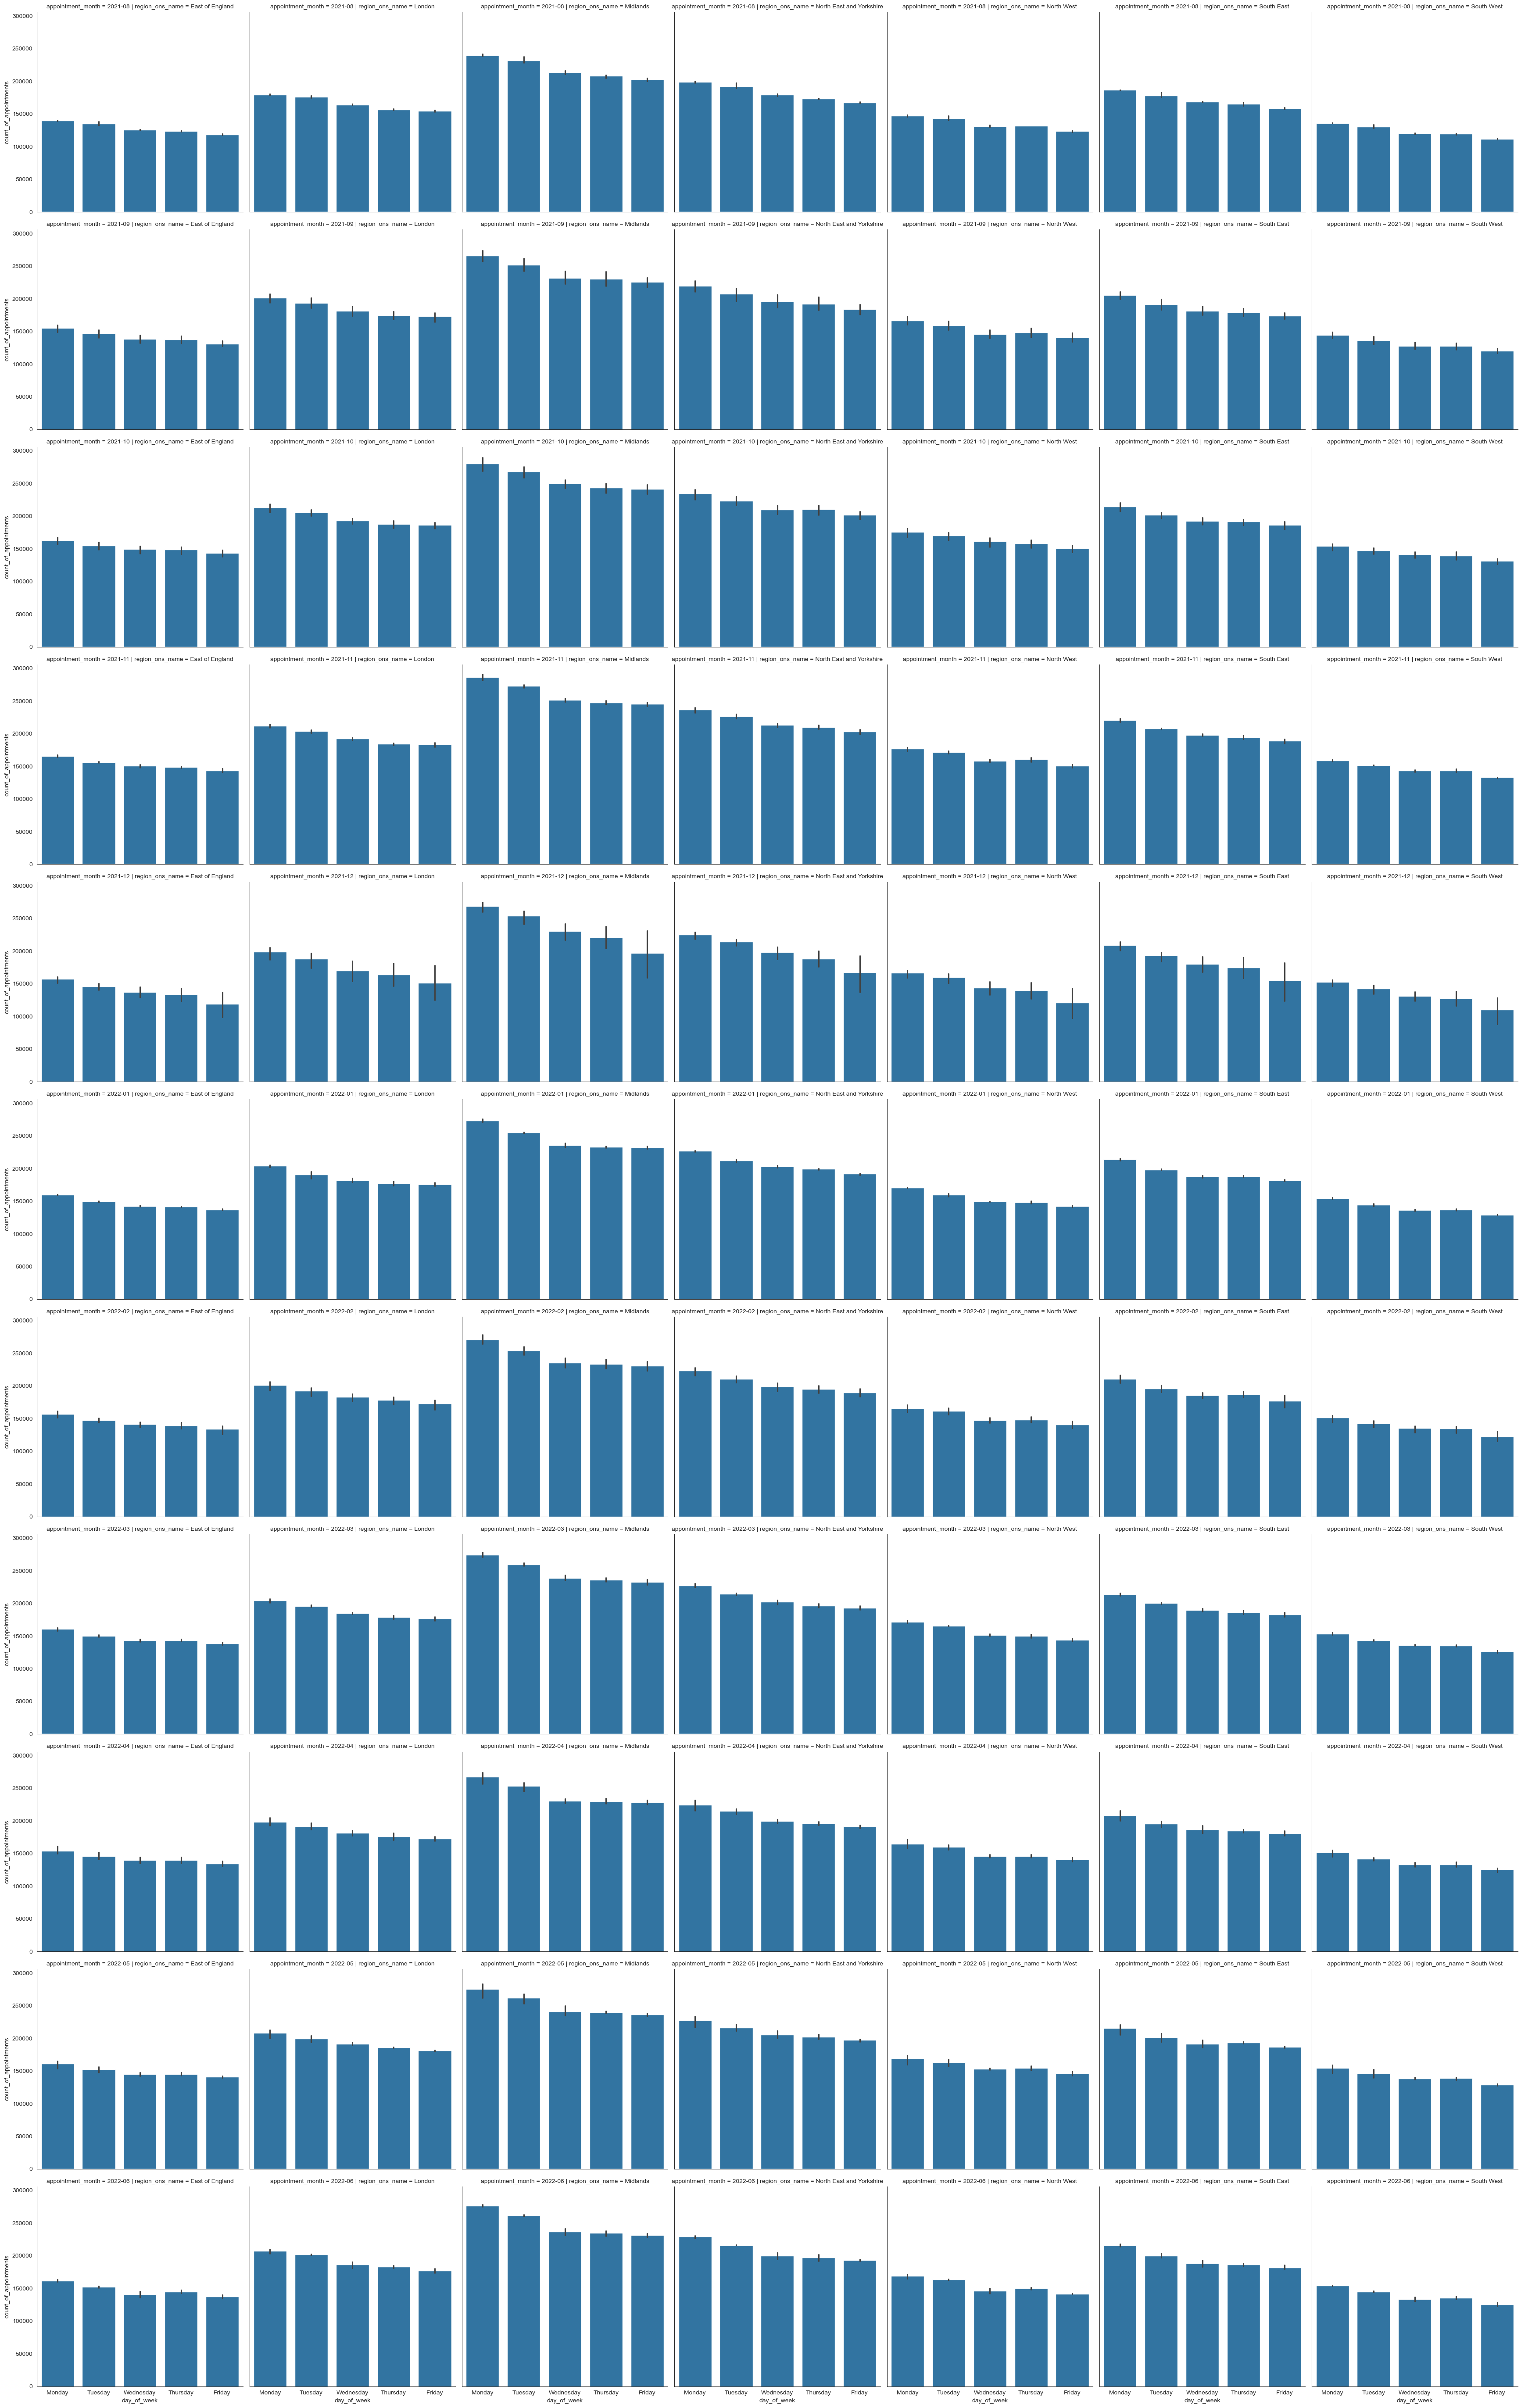

In [263]:
sns.catplot(data=nc_dwt_reg_daily[nc_dwt_reg_daily.day_of_week_type == 'working'], x='day_of_week', y='count_of_appointments', \
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], \
            col='region_ons_name', row='appointment_month', estimator='mean', kind='bar')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

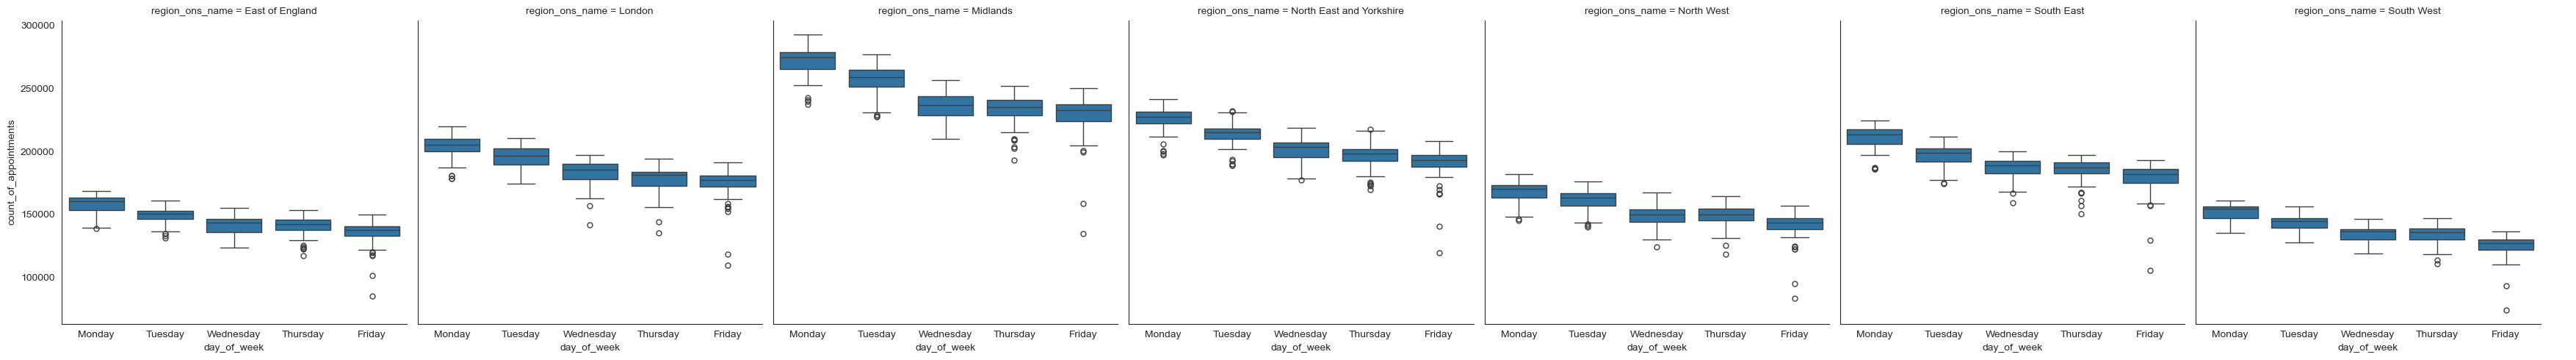

In [264]:
sns.catplot(data=nc_dwt_reg_daily[nc_dwt_reg_daily.day_of_week_type == 'working'], x='day_of_week', y='count_of_appointments', \
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], \
            col='region_ons_name', estimator='mean', kind='box')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

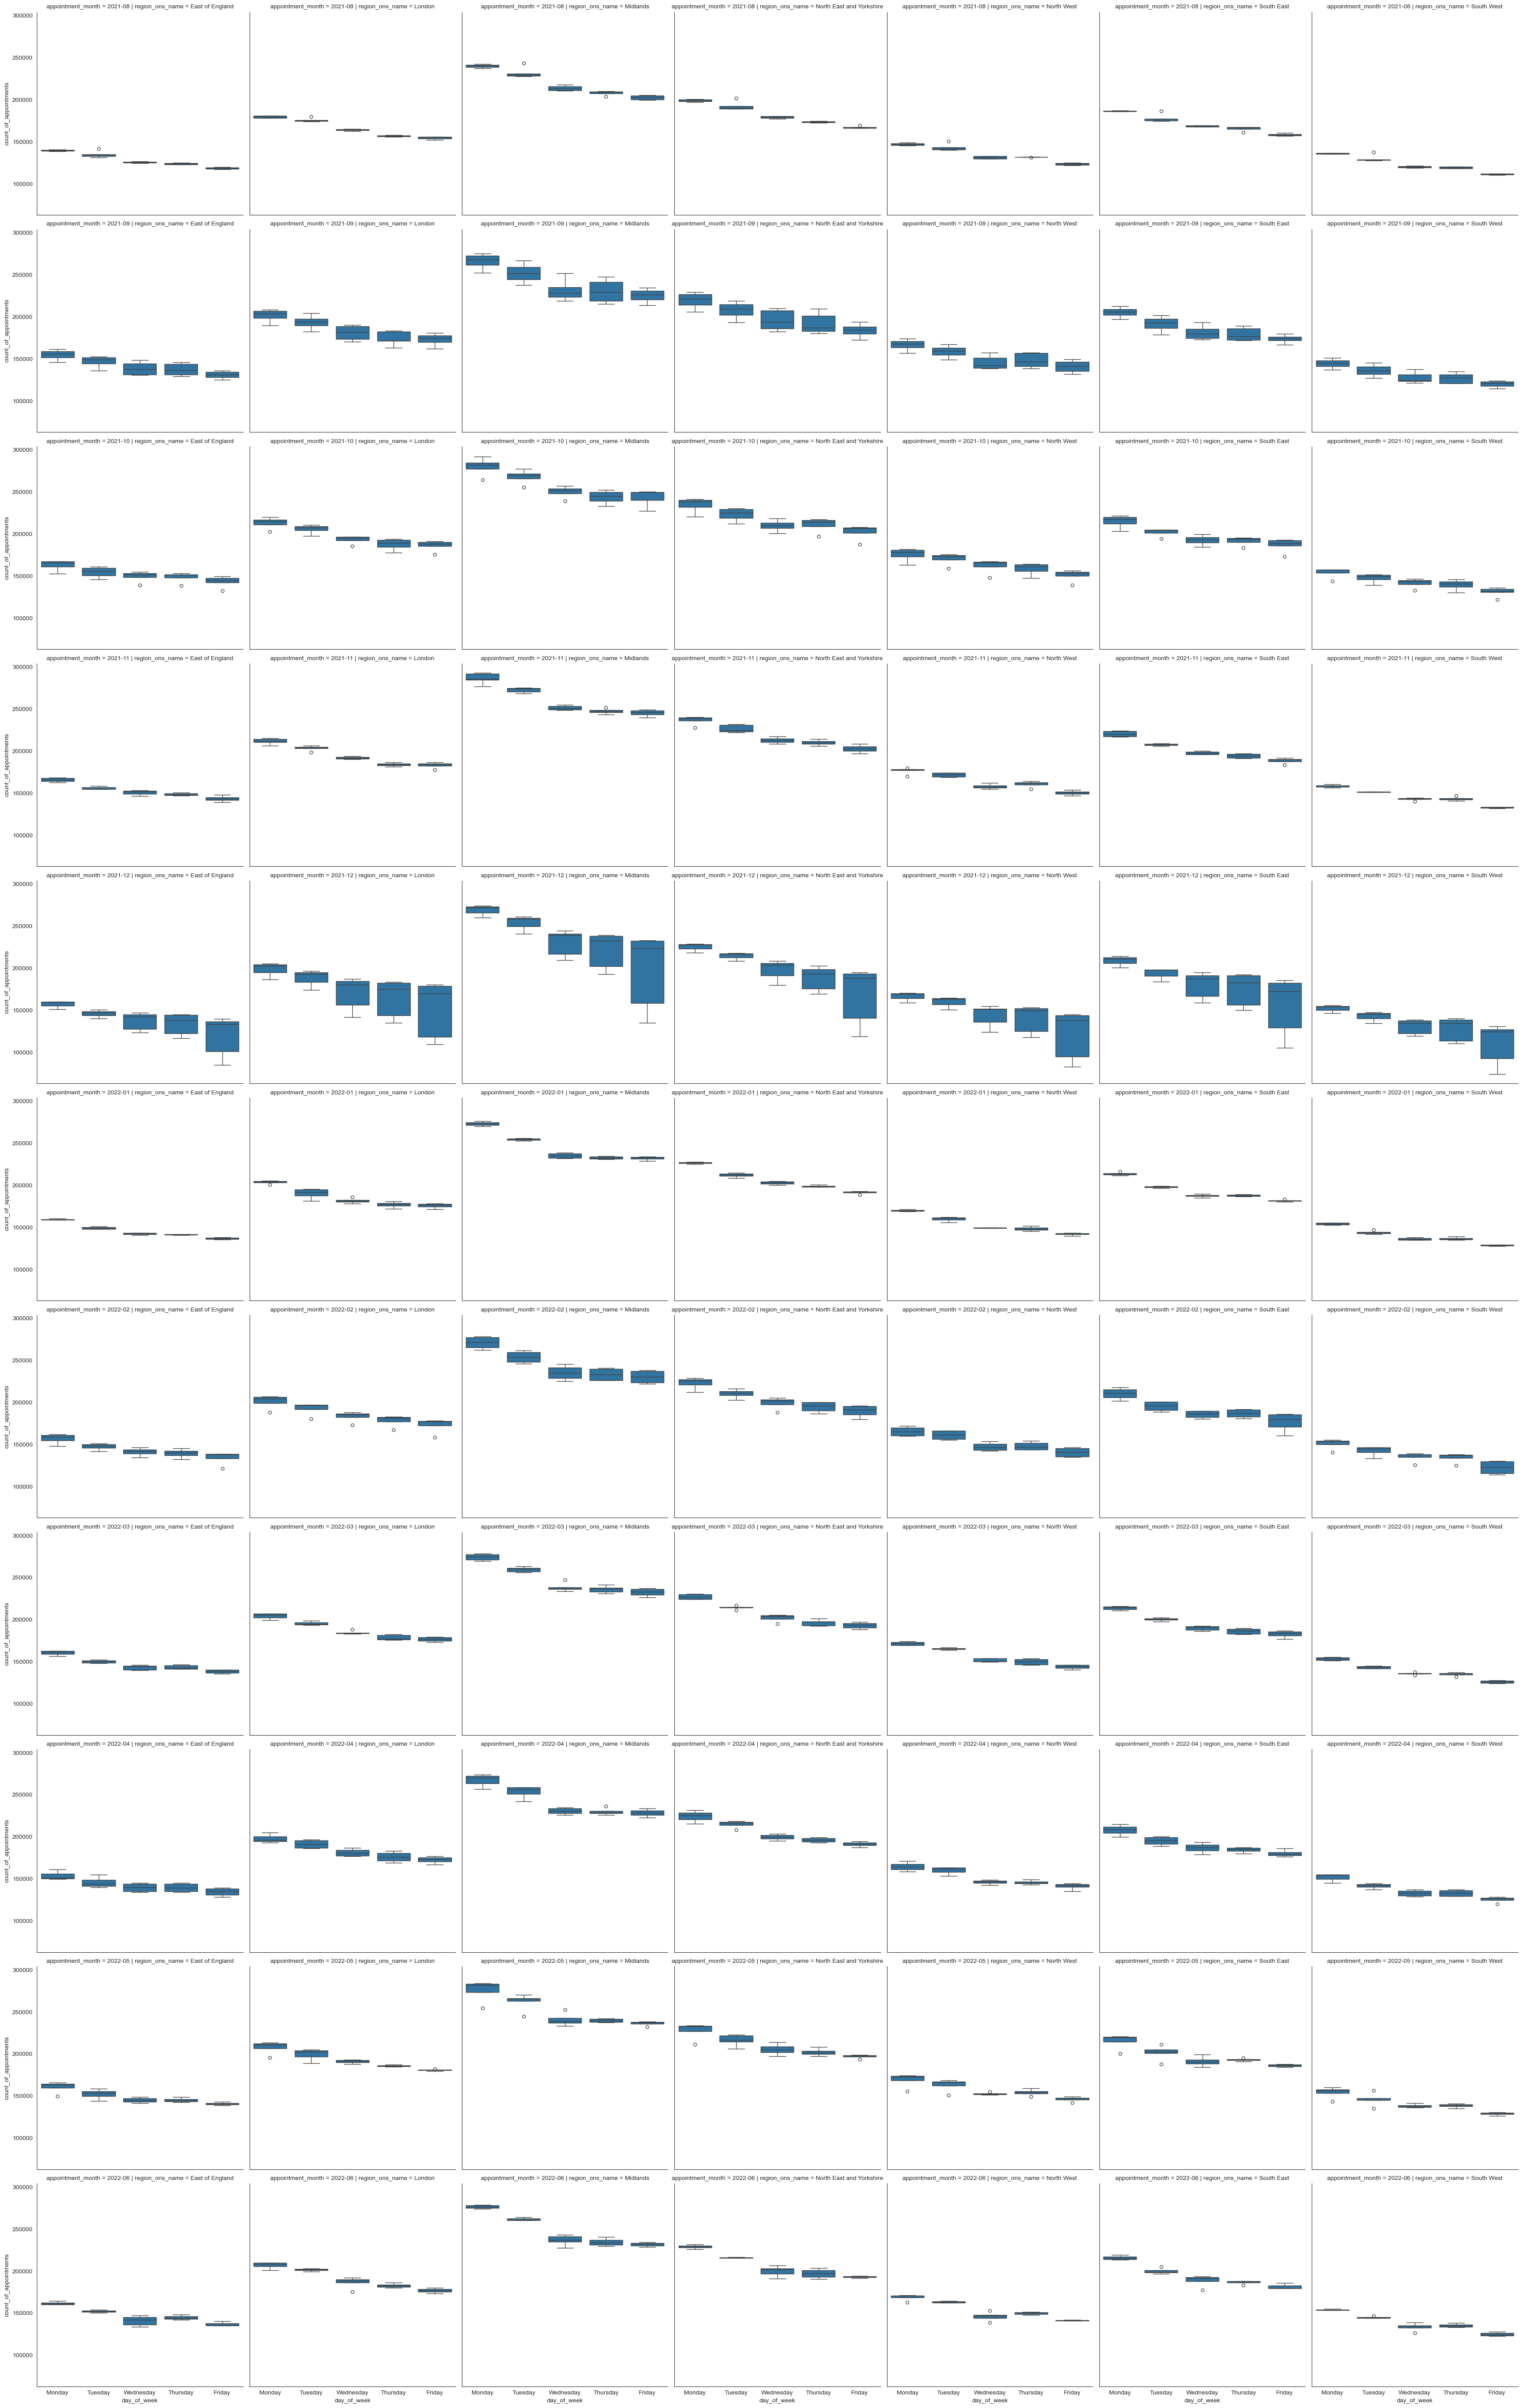

In [265]:
sns.catplot(data=nc_dwt_reg_daily[nc_dwt_reg_daily.day_of_week_type == 'working'], x='day_of_week', y='count_of_appointments', \
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], \
            col='region_ons_name', row='appointment_month', estimator='mean', kind='box')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

In [266]:
nc_dwt_reg_daily[(nc_dwt_reg_daily.appointment_month == '2021-12') \
& (nc_dwt_reg_daily.region_ons_name == 'Midlands') \
& (nc_dwt_reg_daily.day_of_week_type == 'working')].sort_values(by='count_of_appointments')

appointment_date appointment_month day_of_week day_of_week_type  \
1017       2021-12-24           2021-12      Friday          working   
1066       2021-12-31           2021-12      Friday          working   
1059       2021-12-30           2021-12    Thursday          working   
1010       2021-12-23           2021-12    Thursday          working   
1052       2021-12-29           2021-12   Wednesday          working   
1003       2021-12-22           2021-12   Wednesday          working   
968        2021-12-17           2021-12      Friday          working   
961        2021-12-16           2021-12    Thursday          working   
919        2021-12-10           2021-12      Friday          working   
870        2021-12-03           2021-12      Friday          working   
912        2021-12-09           2021-12    Thursday          working   
863        2021-12-02           2021-12    Thursday          working   
954        2021-12-15           2021-12   Wednesday          working   
856        2021-12-01           2021-12   Wednesday          working   
996        2021-12-21           2021-12     Tuesday          working   
905        2021-12-08           2021-12   Wednesday          working   
947        2021-12-14           2021-12     Tuesday          working   
989        2021-12-20           2021-12      Monday          working   
898        2021-12-07           2021-12     Tuesday          working   
940        2021-12-13           2021-12      Monday          working   
891        2021-12-06           2021-12      Monday          working   

     region_ons_name  count_of_appointments  
1017        Midlands                 134893  
1066        Midlands                 158684  
1059        Midlands                 193063  
1010        Midlands                 202267  
1052        Midlands                 209771  
1003        Midlands                 217106  
968         Midlands                 223886  
961         Midlands                 232411  
919         Midlands                 232593  
870         Midlands                 233411  
912         Midlands                 238501  
863         Midlands                 239276  
954         Midlands                 239367  
856         Midlands                 240770  
996         Midlands                 241045  
905         Midlands                 244511  
947         Midlands                 258572  
989         Midlands                 260120  
898         Midlands                 261171  
940         Midlands                 272267  
891         Midlands                 274602

### Average **attended** appointment per day monthly (by 'day_of_week_type'): barplot

In [268]:
# Subset and group DataFrame for analysis
ad_dwt_daily = ad[['appointment_date', 'appointment_month', 'day_of_week', 'day_of_week_type', 'count_of_appointments']]\
.groupby(by=['appointment_date', 'appointment_month', 'day_of_week', 'day_of_week_type']).sum().reset_index()

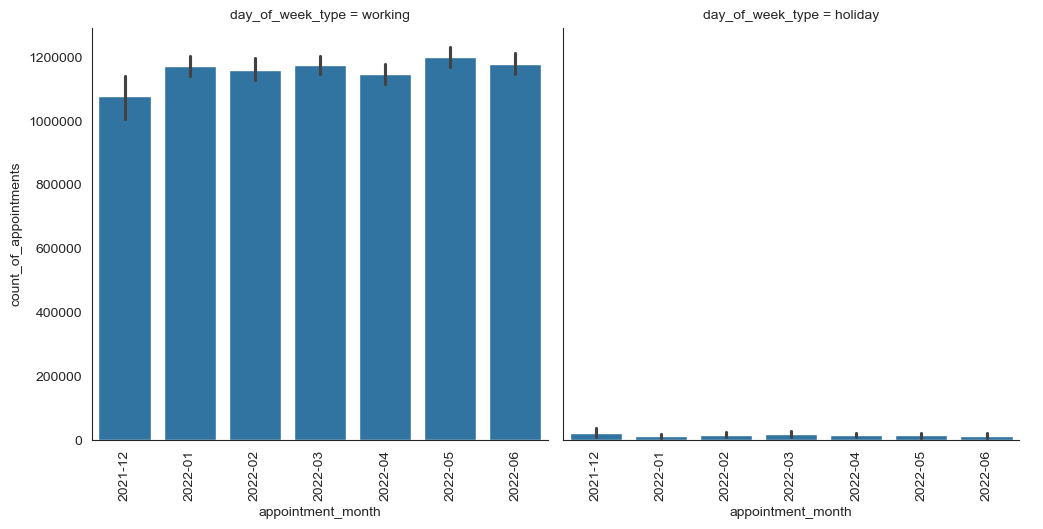

In [269]:
g = sns.catplot(data=ad_dwt_daily, x='appointment_month', y='count_of_appointments', \
            col='day_of_week_type', estimator='mean', kind='bar')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

for ax in g.axes.flat:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Average **Attended** appointment per day by 'day_of_week' for working only: barplot

**Observation:** There is a pattern in the number of average attended appointments per day on weekdays with the workload decreasing from Monday to Friday 

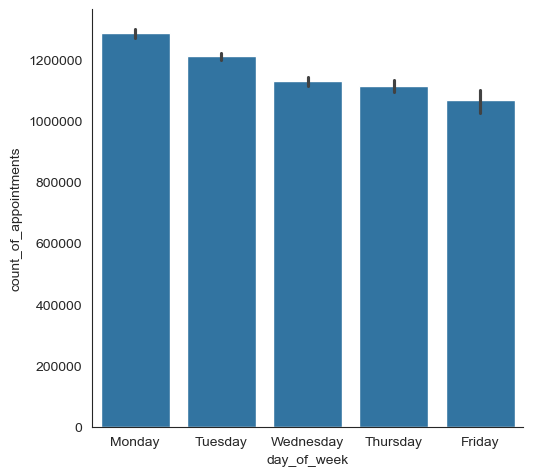

In [272]:
sns.catplot(data=ad_dwt_daily[ad_dwt_daily.day_of_week_type == 'working'], x='day_of_week', y='count_of_appointments', \
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], \
            estimator='mean', kind='bar')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

#   

# What drives attendance rates?

### Total appointments by 'appointment_status'  

**Observation:** 
1) Data quality issue: significant portion of Unknown
2) Higher DNA & Unknown during Sep-Nov

There are no appointments reported as available in the dataset. Assume: appointments are fully booked, but not all of them are attended.

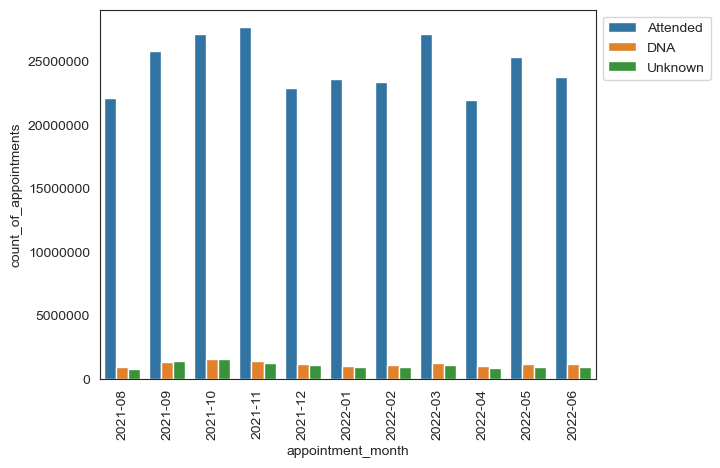

In [277]:
# Total appointments by 'appointment_status' monthly
sns.barplot(data=ar[ar.appointment_month >= '2021-08'], x='appointment_month', y='count_of_appointments', estimator='sum', hue='appointment_status', errorbar=None)

# set basic formatting  
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ylim(0)
plt.ticklabel_format(style='plain', axis='y')

### 'appointment_status' vs 'time_between_book_and_appointment' 

Observation:

1. The shorter the waiting time the higher is attendance rate.
2. DNA rate increases with higher waiting time (opposite to attendance)
3. The ‘Unknown’ appointment status behaves similarly to DNA – highly likely it is DNA.4. 
‘Unknown / Data Quality’ waiting time behaves similarly to More than 28 Days – highly likely it is More than 28 Days.

Group DNA with Unknown and see if patterns make sense? - create column 'time_between_book_and_appointment_est'


In [280]:
# total for the last 11 months (matches nc dataset)  
ar_att_wtg_sum = ar[ar.appointment_month >= '2021-08'][['appointment_status', 'time_between_book_and_appointment', 'time_between_book_and_appointment_n', 'count_of_appointments']]\
.groupby(by=['appointment_status', 'time_between_book_and_appointment', 'time_between_book_and_appointment_n']).sum().reset_index()\
.pivot(values='count_of_appointments', columns='appointment_status', index=['time_between_book_and_appointment', 'time_between_book_and_appointment_n'])\
.sort_values('time_between_book_and_appointment_n').reset_index(level=-1)\
.drop('time_between_book_and_appointment_n', axis=1)

# add total by column
ar_att_wtg_sum.loc['Total']= ar_att_wtg_sum.sum()

# calculate total per row and shares per appointment status
ar_att_wtg_sum['Total'] = ar_att_wtg_sum.sum(axis=1)
ar_att_wtg_sum['Attended_row_%'] = round(ar_att_wtg_sum['Attended'] / ar_att_wtg_sum['Total'] * 100, 1)
ar_att_wtg_sum['DNA_%_row'] = round(ar_att_wtg_sum['DNA'] / ar_att_wtg_sum['Total'] * 100, 1)
ar_att_wtg_sum['Unknown_row_%'] = round(ar_att_wtg_sum['Unknown'] / ar_att_wtg_sum['Total'] * 100, 1)

ar_att_wtg_sum['Attended_col_%'] = ar_att_wtg_sum['Attended'].apply(lambda x: round(x / ar_att_wtg_sum['Attended'].sum() * 2 * 100, 1))
ar_att_wtg_sum['DNA_col_%'] = ar_att_wtg_sum['DNA'].apply(lambda x: round(x / ar_att_wtg_sum['DNA'].sum() * 2 * 100, 1))
ar_att_wtg_sum['Unknown_col_%'] = ar_att_wtg_sum['Unknown'].apply(lambda x: round(x / ar_att_wtg_sum['Unknown'].sum() * 2 * 100, 1))

ar_att_wtg_sum

appointment_status                  Attended       DNA   Unknown      Total  \
time_between_book_and_appointment                                             
Same Day                           125798420   2289152   2889070  130976642   
1 Day                               24012214   1045140    815620   25872974   
2 to 7 Days                         54639327   3695097   2399676   60734100   
8  to 14 Days                       32528864   2869665   2108522   37507051   
15  to 21 Days                      16512807   1568871   1372650   19454328   
22  to 28 Days                       9480045    935245   1015294   11430584   
More than 28 Days                    7546107    910122   1424309    9880538   
Unknown / Data Quality                139910      5092     45551     190553   
Total                              270657694  13318384  12070692  296046770   

appointment_status                 Attended_row_%  DNA_%_row  Unknown_row_%  \
time_between_book_and_appointment                                             
Same Day                                     96.0        1.7            2.2   
1 Day                                        92.8        4.0            3.2   
2 to 7 Days                                  90.0        6.1            4.0   
8  to 14 Days                                86.7        7.7            5.6   
15  to 21 Days                               84.9        8.1            7.1   
22  to 28 Days                               82.9        8.2            8.9   
More than 28 Days                            76.4        9.2           14.4   
Unknown / Data Quality                       73.4        2.7           23.9   
Total                                        91.4        4.5            4.1   

appointment_status                 Attended_col_%  DNA_col_%  Unknown_col_%  
time_between_book_and_appointment                                            
Same Day                                     46.5       17.2           23.9  
1 Day                                         8.9        7.8            6.8  
2 to 7 Days                                  20.2       27.7           19.9  
8  to 14 Days                                12.0       21.5           17.5  
15  to 21 Days                                6.1       11.8           11.4  
22  to 28 Days                                3.5        7.0            8.4  
More than 28 Days                             2.8        6.8           11.8  
Unknown / Data Quality                        0.1        0.0            0.4  
Total                                       100.0      100.0          100.0

1. Based on the patterns map 'Unknown / Data Quality' to >28
2. Highest achieved attendance rate is 95.8%. – To use as MAX achievable UTIL (Think about time frame for aggregation)


In [282]:
# total for the last 11 months (matches nc dataset) based on appointment_status_est
ar_attest_wtg_sum = ar[ar.appointment_month >= '2021-08'][['appointment_status_est', 'time_between_book_and_appointment', 'time_between_book_and_appointment_n', 'count_of_appointments']]\
.groupby(by=['appointment_status_est', 'time_between_book_and_appointment', 'time_between_book_and_appointment_n']).sum().reset_index()\
.pivot(values='count_of_appointments', columns='appointment_status_est', \
       index=['time_between_book_and_appointment', 'time_between_book_and_appointment_n'])\
.sort_values('time_between_book_and_appointment_n').reset_index(level=-1)\
.drop('time_between_book_and_appointment_n', axis=1)

# add total by column
ar_attest_wtg_sum.loc['Total']= ar_attest_wtg_sum.sum()

# calculate total per row and shares per appointment status
ar_attest_wtg_sum['Total'] = ar_attest_wtg_sum.sum(axis=1)
ar_attest_wtg_sum['Attended_est_row_%'] = round(ar_attest_wtg_sum['Attended_est'] / ar_attest_wtg_sum['Total'] * 100, 1)
ar_attest_wtg_sum['DNA_est_row_%'] = round(ar_attest_wtg_sum['DNA_est'] / ar_attest_wtg_sum['Total'] * 100, 1)
ar_attest_wtg_sum['Attended_est_col_%'] = ar_attest_wtg_sum['Attended_est'].apply(lambda x: round(x / ar_attest_wtg_sum['Attended_est'].sum() * 2 * 100, 1))
ar_attest_wtg_sum['DNA_est_col_%'] = ar_attest_wtg_sum['DNA_est'].apply(lambda x: round(x / ar_attest_wtg_sum['DNA_est'].sum() * 2 * 100, 1))

ar_attest_wtg_sum

appointment_status_est             Attended_est   DNA_est      Total  \
time_between_book_and_appointment                                      
Same Day                              125798420   5178222  130976642   
1 Day                                  24012214   1860760   25872974   
2 to 7 Days                            54639327   6094773   60734100   
8  to 14 Days                          32528864   4978187   37507051   
15  to 21 Days                         16512807   2941521   19454328   
22  to 28 Days                          9480045   1950539   11430584   
More than 28 Days                       7546107   2334431    9880538   
Unknown / Data Quality                   139910     50643     190553   
Total                                 270657694  25389076  296046770   

appointment_status_est             Attended_est_row_%  DNA_est_row_%  \
time_between_book_and_appointment                                      
Same Day                                         96.0            4.0   
1 Day                                            92.8            7.2   
2 to 7 Days                                      90.0           10.0   
8  to 14 Days                                    86.7           13.3   
15  to 21 Days                                   84.9           15.1   
22  to 28 Days                                   82.9           17.1   
More than 28 Days                                76.4           23.6   
Unknown / Data Quality                           73.4           26.6   
Total                                            91.4            8.6   

appointment_status_est             Attended_est_col_%  DNA_est_col_%  
time_between_book_and_appointment                                     
Same Day                                         46.5           20.4  
1 Day                                             8.9            7.3  
2 to 7 Days                                      20.2           24.0  
8  to 14 Days                                    12.0           19.6  
15  to 21 Days                                    6.1           11.6  
22  to 28 Days                                    3.5            7.7  
More than 28 Days                                 2.8            9.2  
Unknown / Data Quality                            0.1            0.2  
Total                                           100.0          100.0

In [283]:
ar_att_wtg_sum.to_csv('ar_att_wtg_sum.csv')

### Missed appointment rates by waiting time by month  - assume do not vary much within group

DNA_% is higher within each of the categories during the ‘peak’ period (Sep-Nov) and festive Dec. And the longer the waiting period – the higher sensitivity. **We grouped Less than week and more than week for further analysis and presentation purposes.**

In [286]:
# total for the last 11 months (matches nc dataset) based on appointment_status_est
ar_attest_wtg_m = ar[ar.appointment_month >= '2021-08']\
[['appointment_month', 'appointment_status_est', 'time_between_book_and_appointment_est', 'count_of_appointments']]\
.groupby(by=['appointment_month', 'appointment_status_est', 'time_between_book_and_appointment_est'])\
.sum().reset_index()\
.pivot(values='count_of_appointments', columns='appointment_status_est', \
       index=['time_between_book_and_appointment_est', 'appointment_month'])


# calculate total per row and shares per appointment status
ar_attest_wtg_m['Total'] = ar_attest_wtg_m.sum(axis=1)
ar_attest_wtg_m['DNA_%'] = round(ar_attest_wtg_m['DNA_est'] / ar_attest_wtg_m['Total'] * 100, 1)
ar_attest_wtg_m.reset_index(inplace=True)

ar_attest_wtg_m.head()

appointment_status_est time_between_book_and_appointment_est  \
0                                                      1 Day   
1                                                      1 Day   
2                                                      1 Day   
3                                                      1 Day   
4                                                      1 Day   

appointment_status_est appointment_month  Attended_est  DNA_est    Total  \
0                                2021-08       1884017   134302  2018319   
1                                2021-09       2470594   195478  2666072   
2                                2021-10       2388002   210514  2598516   
3                                2021-11       2318276   188256  2506532   
4                                2021-12       2049362   169850  2219212   

appointment_status_est  DNA_%  
0                         6.7  
1                         7.3  
2                         8.1  
3                         7.5  
4                         7.7

(0.0, 30.68)

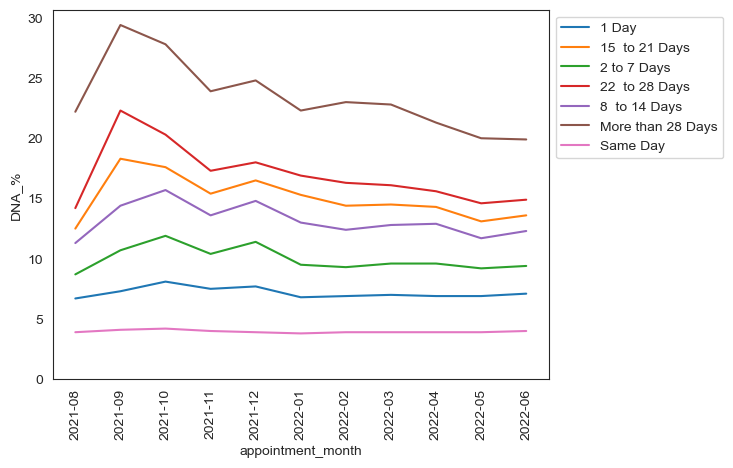

In [287]:
sns.lineplot(data=ar_attest_wtg_m, x='appointment_month', y='DNA_%', hue='time_between_book_and_appointment_est')

# set basic formatting  
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.ylim(0)


In [288]:
# total for the last 11 months (matches nc dataset) based on appointment_status_est and time_between_book_and_appointment_gr
ar_attest_wtggr_m = ar[ar.appointment_month >= '2021-08']\
[['appointment_month', 'appointment_status_est', 'time_between_book_and_appointment_gr', 'count_of_appointments']]\
.groupby(by=['appointment_month', 'appointment_status_est', 'time_between_book_and_appointment_gr'])\
.sum().reset_index()\
.pivot(values='count_of_appointments', columns='appointment_status_est', \
       index=['time_between_book_and_appointment_gr', 'appointment_month'])


# calculate total per row and shares per appointment status
ar_attest_wtggr_m['Total'] = ar_attest_wtggr_m.sum(axis=1)
ar_attest_wtggr_m['DNA_%'] = round(ar_attest_wtggr_m['DNA_est'] / ar_attest_wtggr_m['Total'] * 100, 1)
ar_attest_wtggr_m.reset_index(inplace=True)

ar_attest_wtggr_m.head()

appointment_status_est time_between_book_and_appointment_gr appointment_month  \
0                                                   8+ days           2021-08   
1                                                   8+ days           2021-09   
2                                                   8+ days           2021-10   
3                                                   8+ days           2021-11   
4                                                   8+ days           2021-12   

appointment_status_est  Attended_est  DNA_est    Total  DNA_%  
0                            5078687   779201  5857888   13.3  
1                            6142153  1432869  7575022   18.9  
2                            7090209  1606211  8696420   18.5  
3                            7342206  1373944  8716150   15.8  
4                            5536265  1125234  6661499   16.9

In [289]:
ar_attest_wtggr_m.to_csv('ar_attest_wtggr_m.csv')

### Average waiting time by 'appointment_status' monthly 

**Metadata:**

 
The appointment status shows whether the appointment is available, booked, has been 
attended by the patient (or not), or has been cancelled. This status changes over 
time, for example when a patient makes a booking, the appointment status changes 
from ‘Available’ to ‘Booked’. This release reports the final status of each 
appointment. 

In most cases, at the time of the appointment, a ‘Booked’ status will be changed to 
either ‘Attended’ or ‘DNA’ (Did Not Attend). In some cases (3%–6% of monthly appointments), 
the final status of an appointment remains 'Booked’. It is not known from the data 
whether or not these appointments actually attended. For this reason, the status of these 
appointments is reported as 'Unknown'


nknown'.



**Observation:**

1. There are no appointments reported as available. NHS appointments are fully booked, but not all of them are attended.
2. The average waiting time is lower for appointment status 'Attended'. 'DNA' and 'Unknown' appointment status are characterised by longer waiting times.

In [293]:
# inputs into user defined function
df_ = ar[ar.appointment_month >= '2021-08'].copy()
par_to_weight_ = 'time_between_book_and_appointment_n'
cols_to_gr_by_list_ = ['appointment_month', 'appointment_status']
wa_col_name_ = 'time_between_book_and_appointment_avg'
# col_to_weight_by = 'count_of_appointments'

ar_df_wtime_status = weighted_average(df_, par_to_weight_, cols_to_gr_by_list_, wa_col_name_)
ar_df_wtime_status.head()
# ar_df_wtime_status.to_csv('ar_df_wtime_status.csv', index=False)

appointment_month appointment_status  count_of_appointments  \
0           2021-08           Attended               22081765   
1           2021-08                DNA                 949137   
2           2021-08            Unknown                 821269   
3           2021-09           Attended               25757066   
4           2021-09                DNA                1321348   

   time_between_book_and_appointment_avg  
0                               4.694398  
1                               8.951101  
2                               9.069335  
3                               5.002225  
4                               9.556534

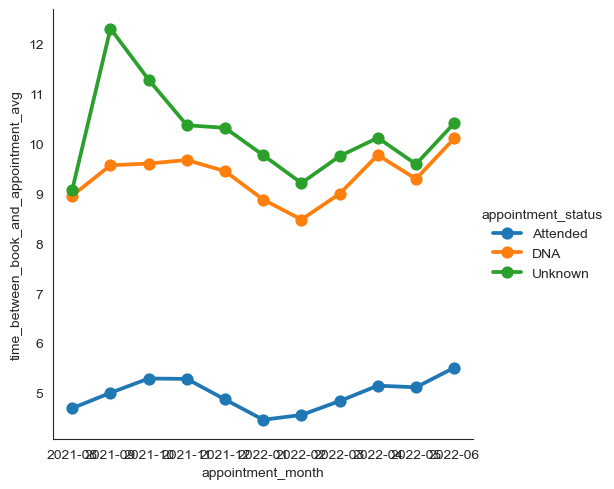

In [294]:
sns.catplot(data=ar_df_wtime_status, x='appointment_month', y='time_between_book_and_appointment_avg', hue='appointment_status', kind='point')

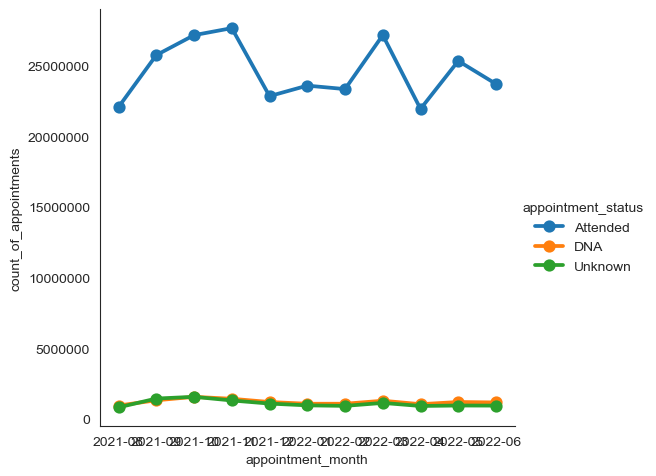

In [295]:
sns.catplot(data=ar_df_wtime_status, x='appointment_month', y='count_of_appointments', hue='appointment_status', kind='point')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

### Average waiting time by 'appointment_status' and 'region_ons_name' monthly 

The average waiting time is lower for appointment status 'Attended'. 'DNA' and 'Unknown' appointment status are characterised by longer waiting times.
This is fair for all the 7 regions.

- Yorkshire and The Humber has the lowest waiting times 
- East of England - the highest 

In [298]:
# inputs into user defined function
df_ = ar[ar.appointment_month >= '2021-08'].copy()
par_to_weight_ = 'time_between_book_and_appointment_n'
cols_to_gr_by_list_ = ['appointment_month', 'appointment_status', 'region_ons_name']
wa_col_name_ = 'time_between_book_and_appointment_avg'
# col_to_weight_by = 'count_of_appointments'

ar_df_wtime_reg_monthly = weighted_average(df_, par_to_weight_, cols_to_gr_by_list_, wa_col_name_)
ar_df_wtime_reg_monthly.head()
# ar_df_wtime_reg_monthly.to_csv('ar_df_wtime_reg_monthly.csv', index=False)

appointment_month appointment_status           region_ons_name  \
0           2021-08           Attended           East of England   
1           2021-08           Attended                    London   
2           2021-08           Attended                  Midlands   
3           2021-08           Attended  North East and Yorkshire   
4           2021-08           Attended                North West   

   count_of_appointments  time_between_book_and_appointment_avg  
0                2556807                               4.814565  
1                3220952                               3.871901  
2                4300473                               4.549841  
3                3594836                               4.928640  
4                2599426                               4.628177

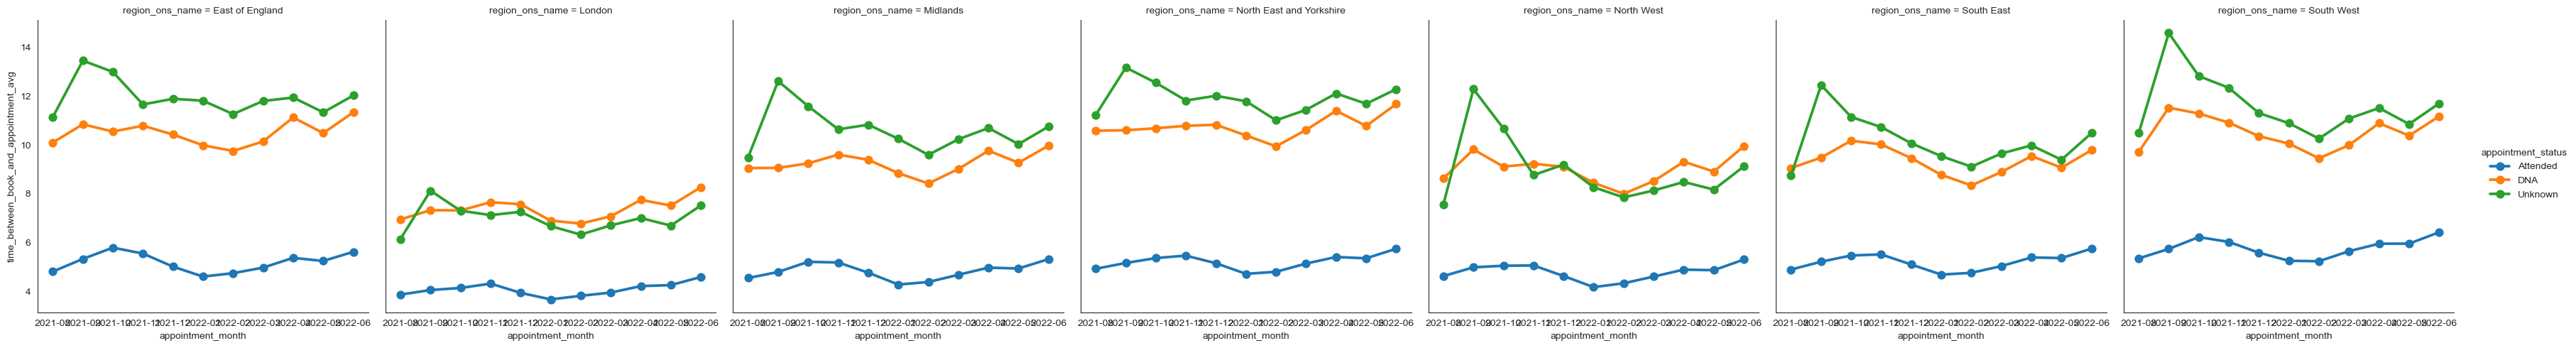

In [299]:
sns.catplot(data=ar_df_wtime_reg_monthly, x='appointment_month', y='time_between_book_and_appointment_avg', \
            col='region_ons_name', hue='appointment_status', kind='point')

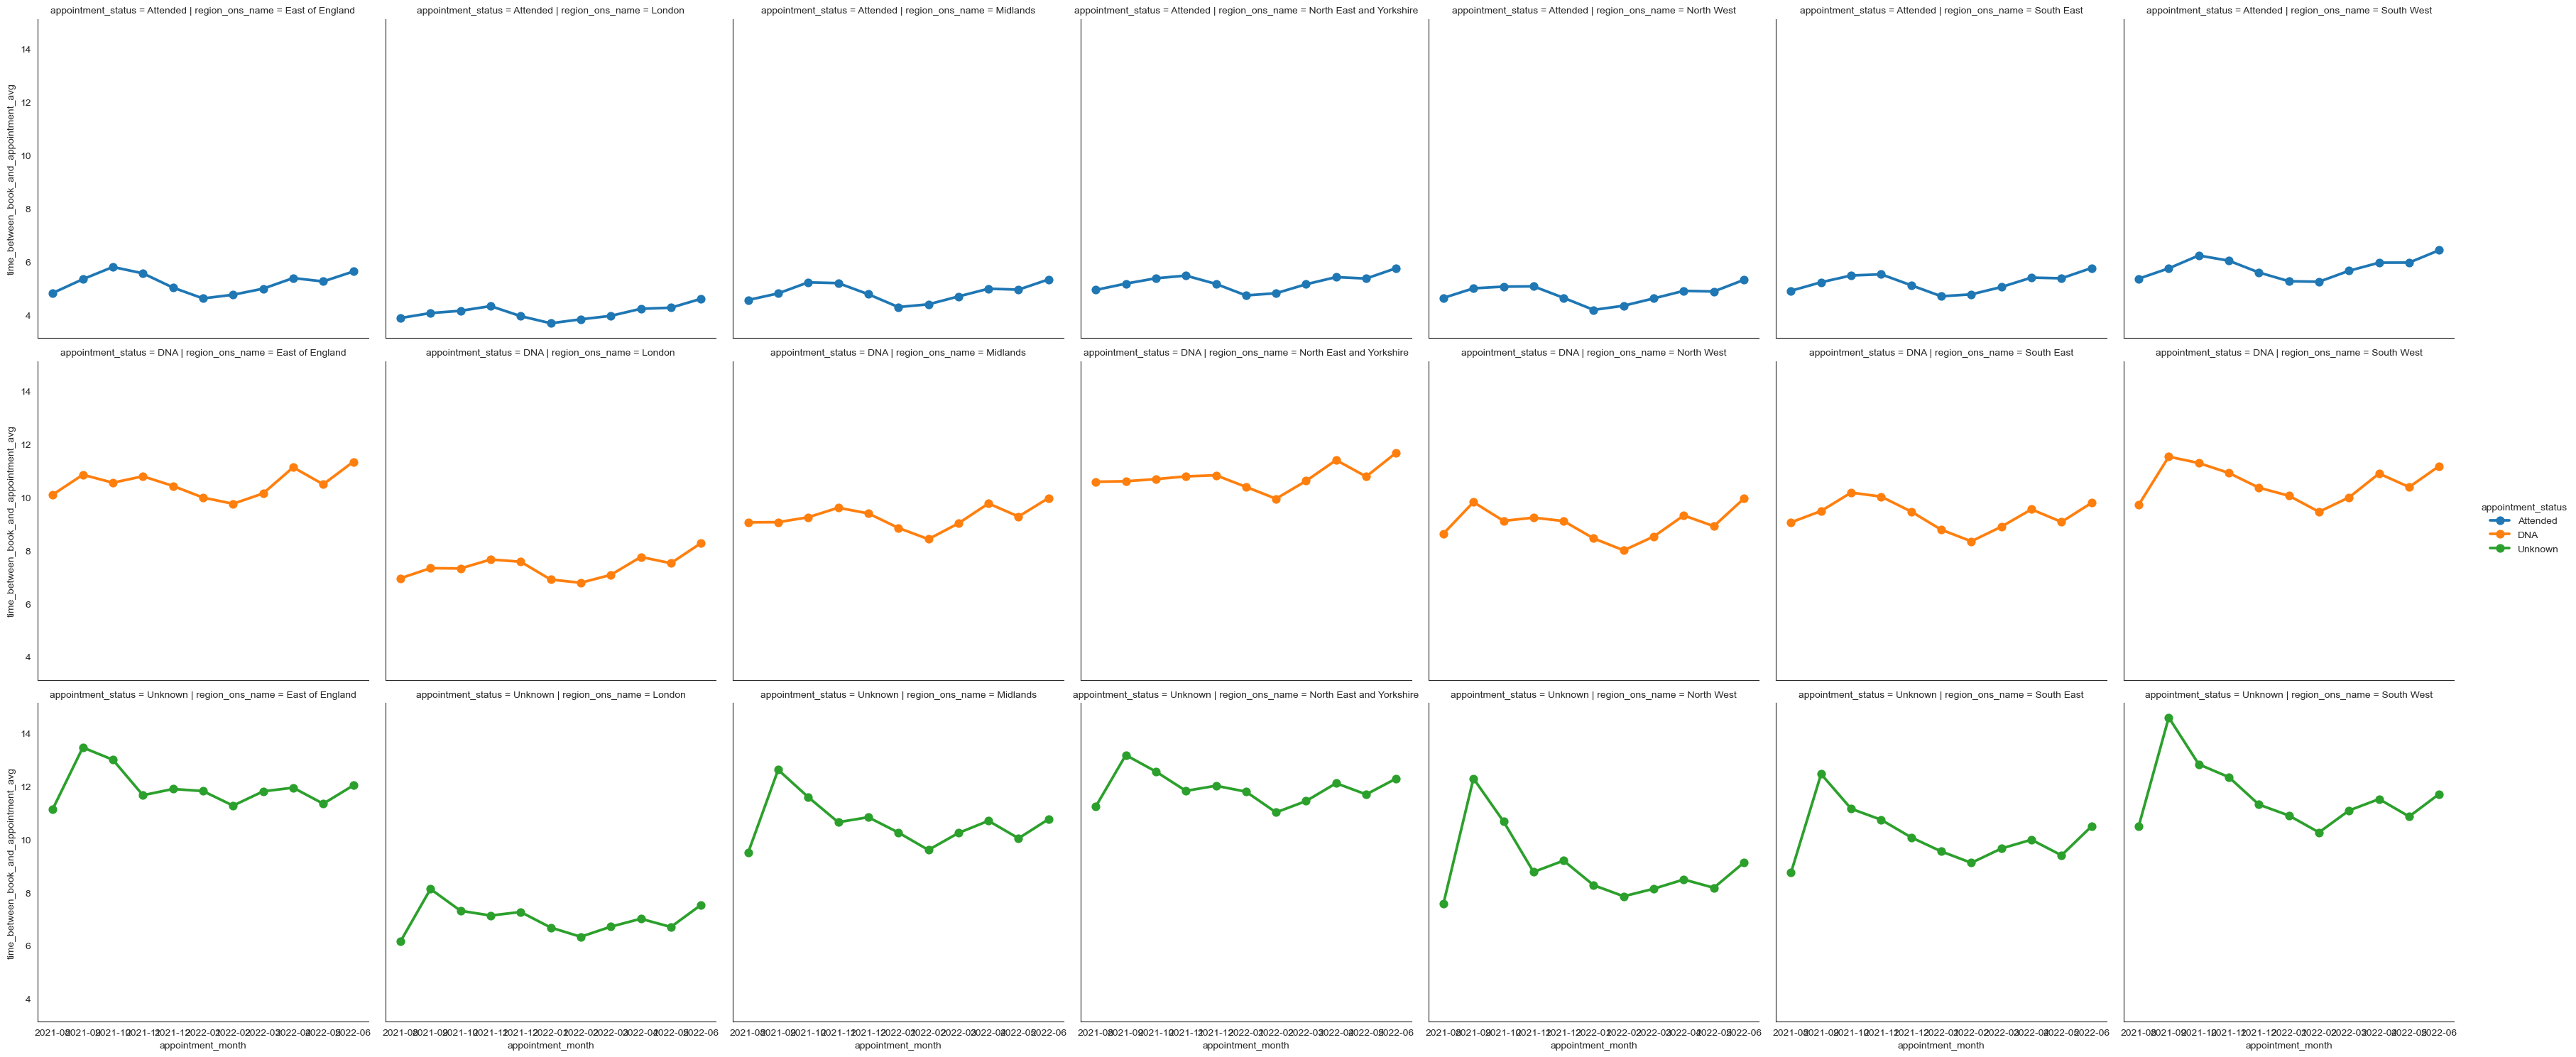

In [300]:
sns.catplot(data=ar_df_wtime_reg_monthly, x='appointment_month', y='time_between_book_and_appointment_avg', \
            col='region_ons_name', row='appointment_status', hue='appointment_status', kind='point')

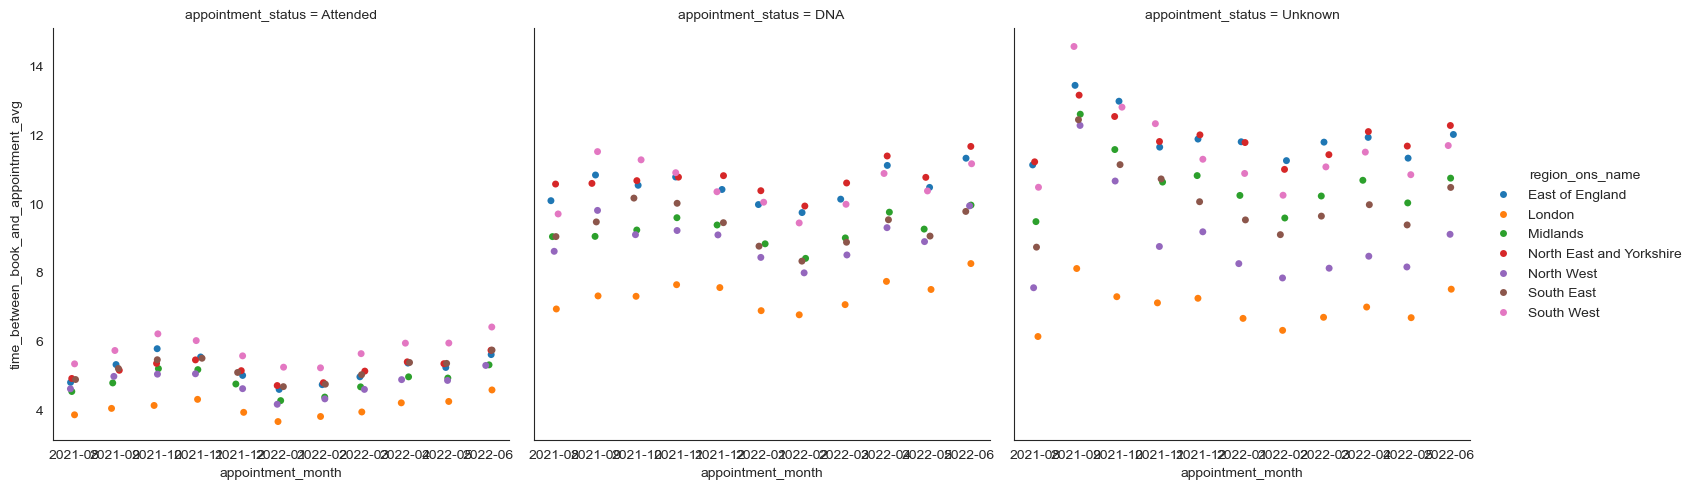

In [301]:
sns.catplot(data=ar_df_wtime_reg_monthly, x='appointment_month', y='time_between_book_and_appointment_avg', \
            col='appointment_status', hue='region_ons_name', kind='strip')

### Average waiting time by 'appointment_status', 'hcp_type' and 'region_ons_name' monthly 

The average waiting time is lower for appointment status 'Attended'. 'DNA' and 'Unknown' appointment status are characterised by longer waiting times.
This is fair for all the 7 regions.

- Yorkshire and The Humber has the lowest waiting times (largely driven by lower waiting times for Other Practice staff)
- East of England - the highest (both for GPs and Other Practice staff)

Other Practise staff have higher waiting times compared to GP.
- Other Practise staff in London have noticeably shorter waiting times compared to other regions.

In [304]:
ar.columns

Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments', 'region_ons_code', 'appointment_status_est',
       'time_between_book_and_appointment_n',
       'time_between_book_and_appointment_est',
       'time_between_book_and_appointment_gr', 'region_ons_name',
       'appointment_mode_expl'],
      dtype='object')

In [305]:
# inputs into user defined function
df_ = ar[ar.appointment_month >= '2021-08'].copy()
par_to_weight_ = 'time_between_book_and_appointment_n'
cols_to_gr_by_list_ = ['appointment_month', 'appointment_status', 'hcp_type', 'region_ons_name']
wa_col_name_ = 'time_between_book_and_appointment_avg'
# col_to_weight_by = 'count_of_appointments'

ar_df_wtime_hcp_reg_monthly = weighted_average(df_, par_to_weight_, cols_to_gr_by_list_, wa_col_name_)
ar_df_wtime_hcp_reg_monthly.head()
# ar_df_wtime_hcp_reg_monthly.to_csv('ar_df_wtime_hcp_reg_monthly.csv', index=False)

appointment_month appointment_status hcp_type           region_ons_name  \
0           2021-08           Attended       GP           East of England   
1           2021-08           Attended       GP                    London   
2           2021-08           Attended       GP                  Midlands   
3           2021-08           Attended       GP  North East and Yorkshire   
4           2021-08           Attended       GP                North West   

   count_of_appointments  time_between_book_and_appointment_avg  
0                1267930                               3.212565  
1                1991574                               3.098422  
2                2286369                               2.691842  
3                1676730                               3.092859  
4                1438814                               2.882871

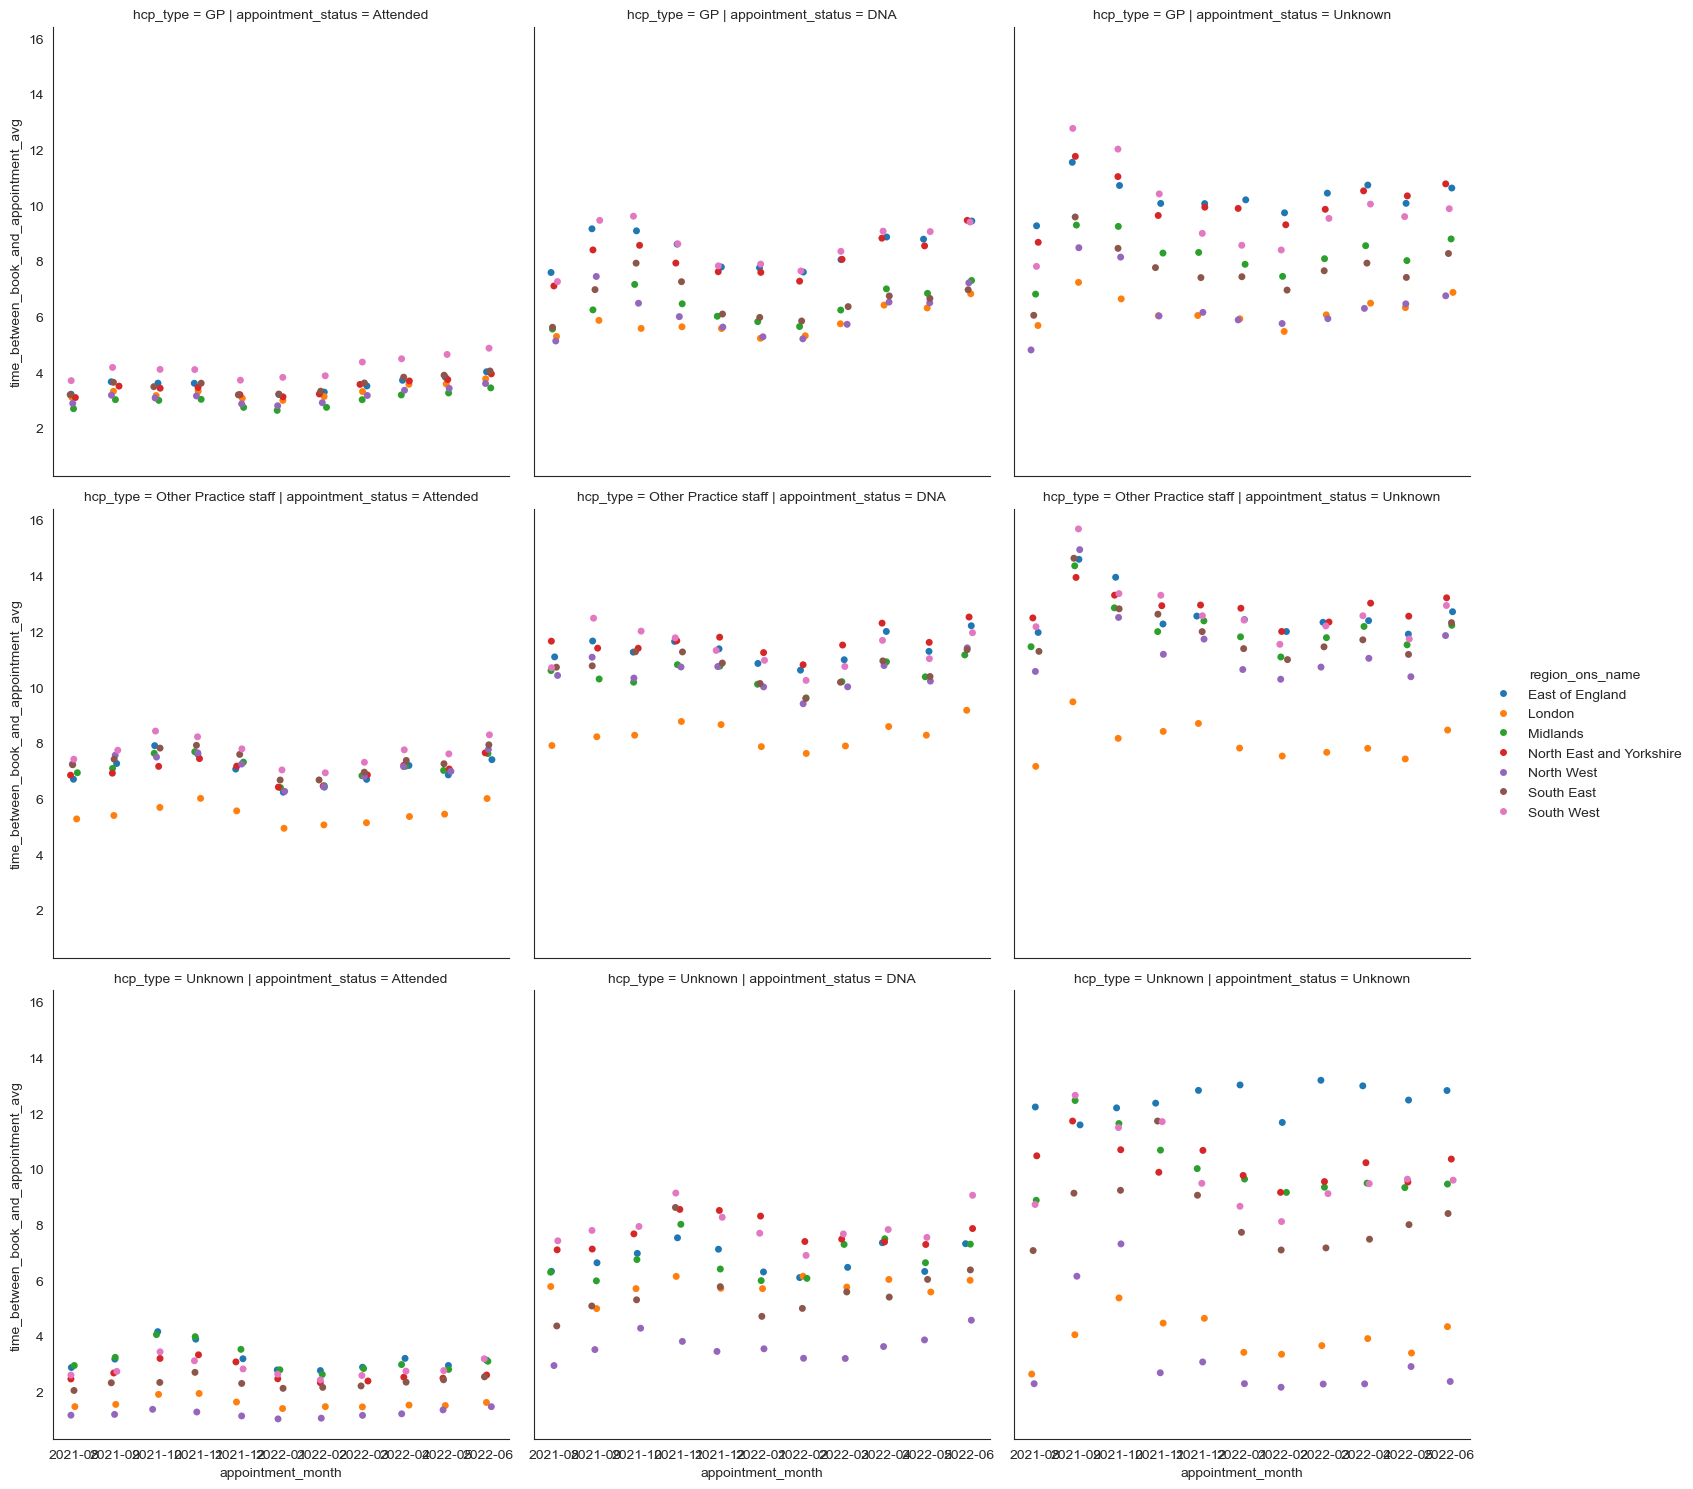

In [306]:
sns.catplot(data=ar_df_wtime_hcp_reg_monthly, x='appointment_month', y='time_between_book_and_appointment_avg', \
            col='appointment_status', row='hcp_type', hue='region_ons_name', kind='strip')

### Average waiting time by 'hcp_type', 'region_ons_name' and 'appointment_mode_expl' monthly

**Metadata:**

The mode of the appointment shows the **setting of the consultation**. For example, face to face, 
telephone, or home visits. This is set locally by the practices so it may not represent the actual 
care setting of the appointment. For example, some video conference appointments may be logged 
by the practice as face to face.

**Unless home visits and telephone triage are logged as individual appointments and booked to 
a patient, they will not appear in this publication**. Appointments marked as online, video or 
video conference are shown as 'Online / Video'. This may or may not include a video element. 
Non-video based online consultations such as live chat or Voice over Internet Protocol (VoIP) 
and video-based appointments are all included in this categ


**Practices using the Cegedim GP system are unable to supply appointment mode data.** Consequently, 
the proportion of appointments with an 'Unknown' appointment mode is higher in releases from 
July 2019 onwards when Cegedim practices were included in the publication.on.


  

In [309]:
ar.columns

Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments', 'region_ons_code', 'appointment_status_est',
       'time_between_book_and_appointment_n',
       'time_between_book_and_appointment_est',
       'time_between_book_and_appointment_gr', 'region_ons_name',
       'appointment_mode_expl'],
      dtype='object')

In [310]:
# inputs into user defined function
#df_ = ar[ar.appointment_status == 'Attended'].copy()
df_ = ar[ar.appointment_month >= '2021-08'].copy()
par_to_weight_ = 'time_between_book_and_appointment_n'
cols_to_gr_by_list_ = ['appointment_month', 'hcp_type', 'appointment_mode_expl', 'region_ons_name']
wa_col_name_ = 'time_between_book_and_appointment_avg'
# col_to_weight_by = 'count_of_appointments'

ar_df_att_wtime_hcp_reg_mode_monthly = weighted_average(df_, par_to_weight_, cols_to_gr_by_list_, wa_col_name_)
ar_df_att_wtime_hcp_reg_mode_monthly.head()
# ar_df_att_wtime_hcp_reg_mode_monthly.to_csv('ar_df_att_wtime_hcp_reg_mode_monthly.csv', index=False)

appointment_month hcp_type appointment_mode_expl           region_ons_name  \
0           2021-08       GP          Face-to-Face           East of England   
1           2021-08       GP          Face-to-Face                    London   
2           2021-08       GP          Face-to-Face                  Midlands   
3           2021-08       GP          Face-to-Face  North East and Yorkshire   
4           2021-08       GP          Face-to-Face                North West   

   count_of_appointments  time_between_book_and_appointment_avg  
0                 681147                               3.519198  
1                 902975                               3.405273  
2                1061908                               3.064155  
3                 871182                               3.352864  
4                 654571                               2.902171

In [311]:
ar_df_att_wtime_hcp_reg_mode_monthly.appointment_mode_expl.unique()

<StringArray>
['Face-to-Face', 'Other', 'Telephone']
Length: 3, dtype: string

**Observations:** 

1) The average waiting time is lower for appointment status 'Attended'.
2) 'DNA' and 'Unknown' appointment statuses are characterised by longer waiting times. This is fair for all 7 regions.
4) Other Practice staff have higher waiting times compared to the GP.
5) Other Practice staff in London have noticeably shorter waiting times compared to other regions.

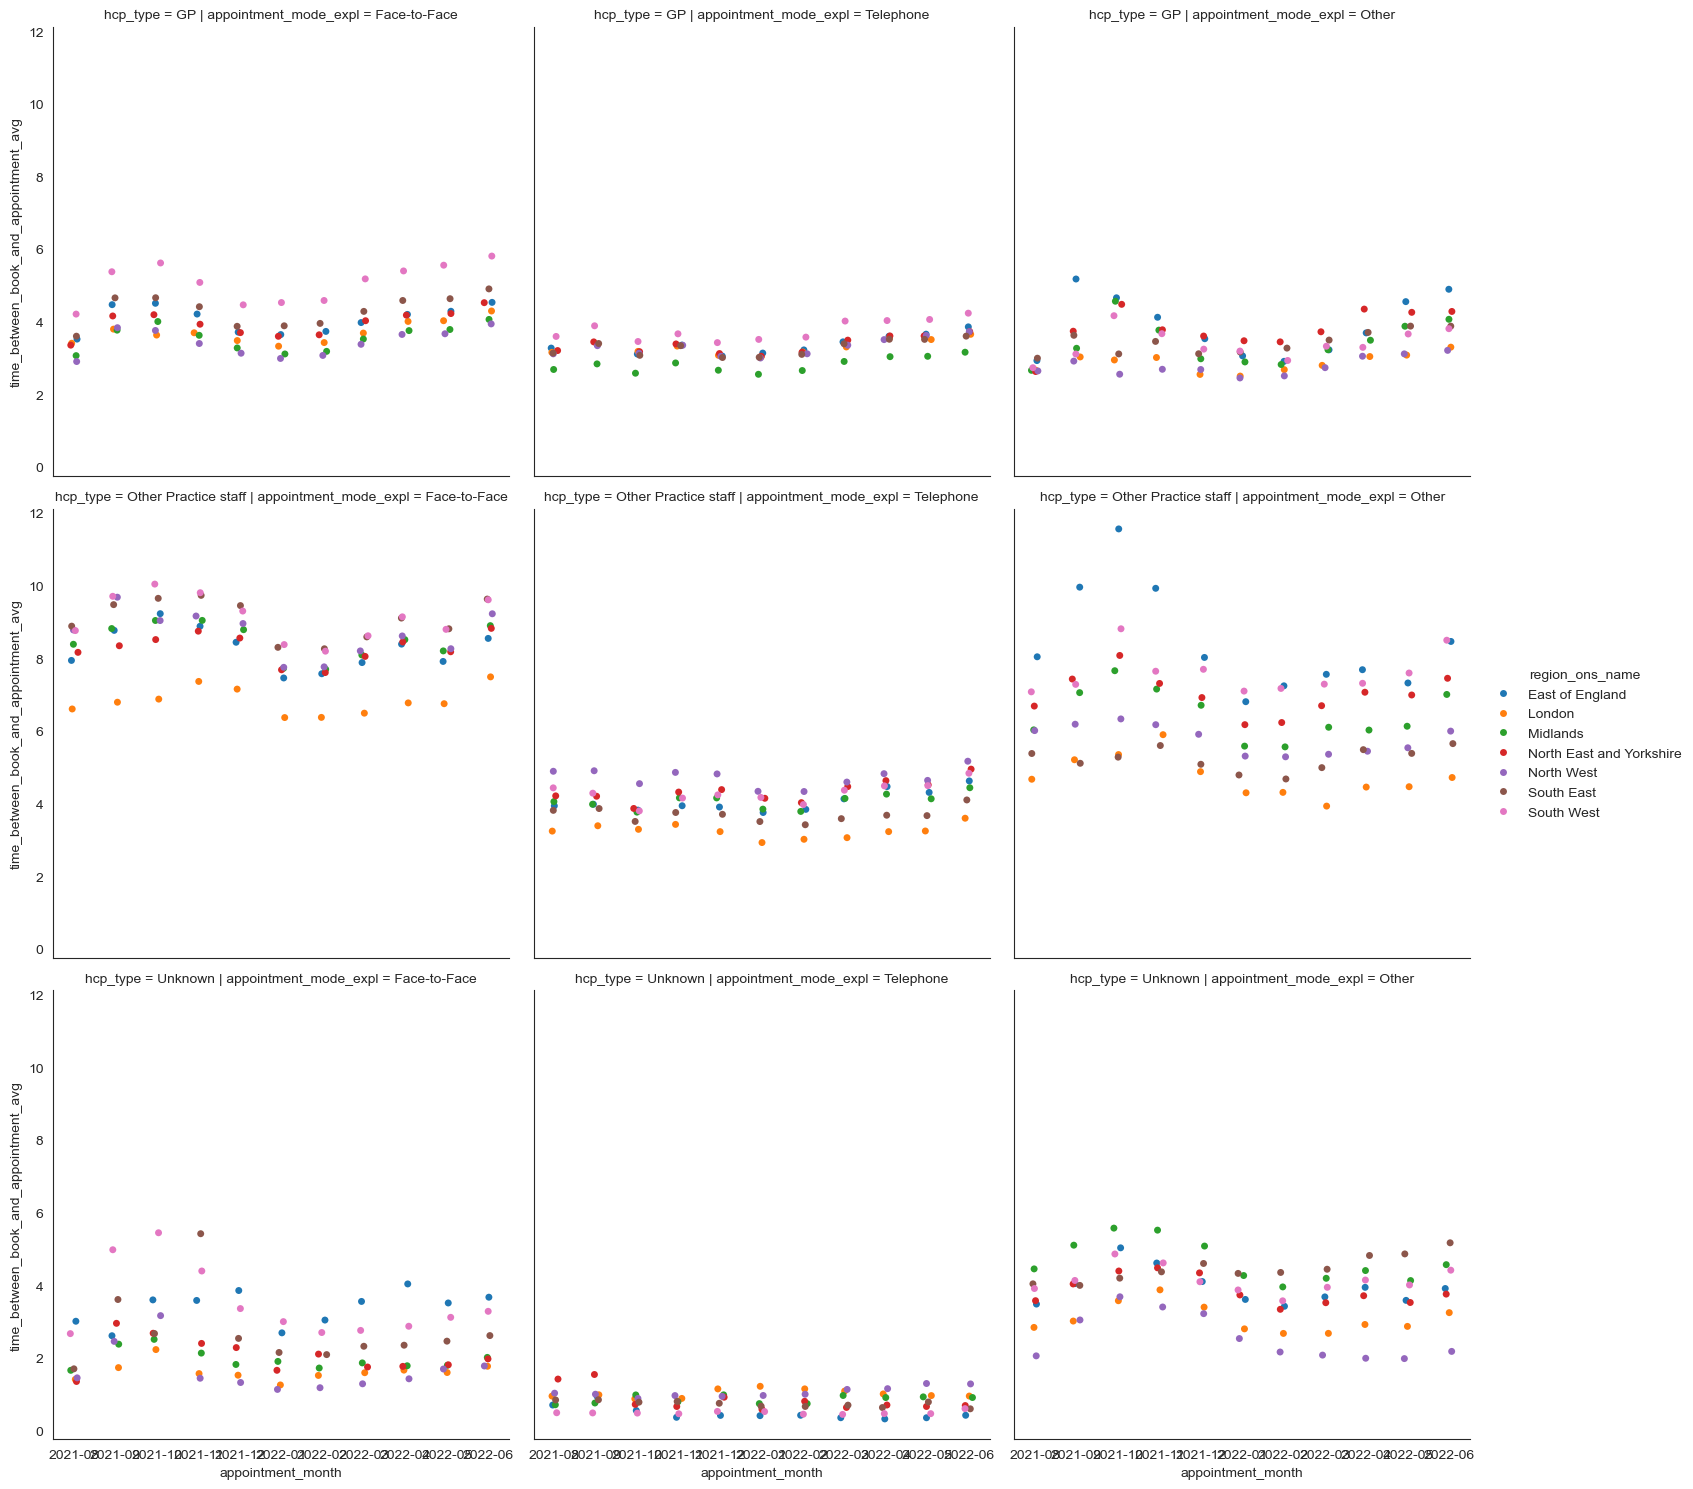

In [313]:
sns.catplot(data=ar_df_att_wtime_hcp_reg_mode_monthly, x='appointment_month', y='time_between_book_and_appointment_avg', \
            col='appointment_mode_expl', col_order=['Face-to-Face', 'Telephone', 'Other'], row='hcp_type', hue='region_ons_name', kind='strip')

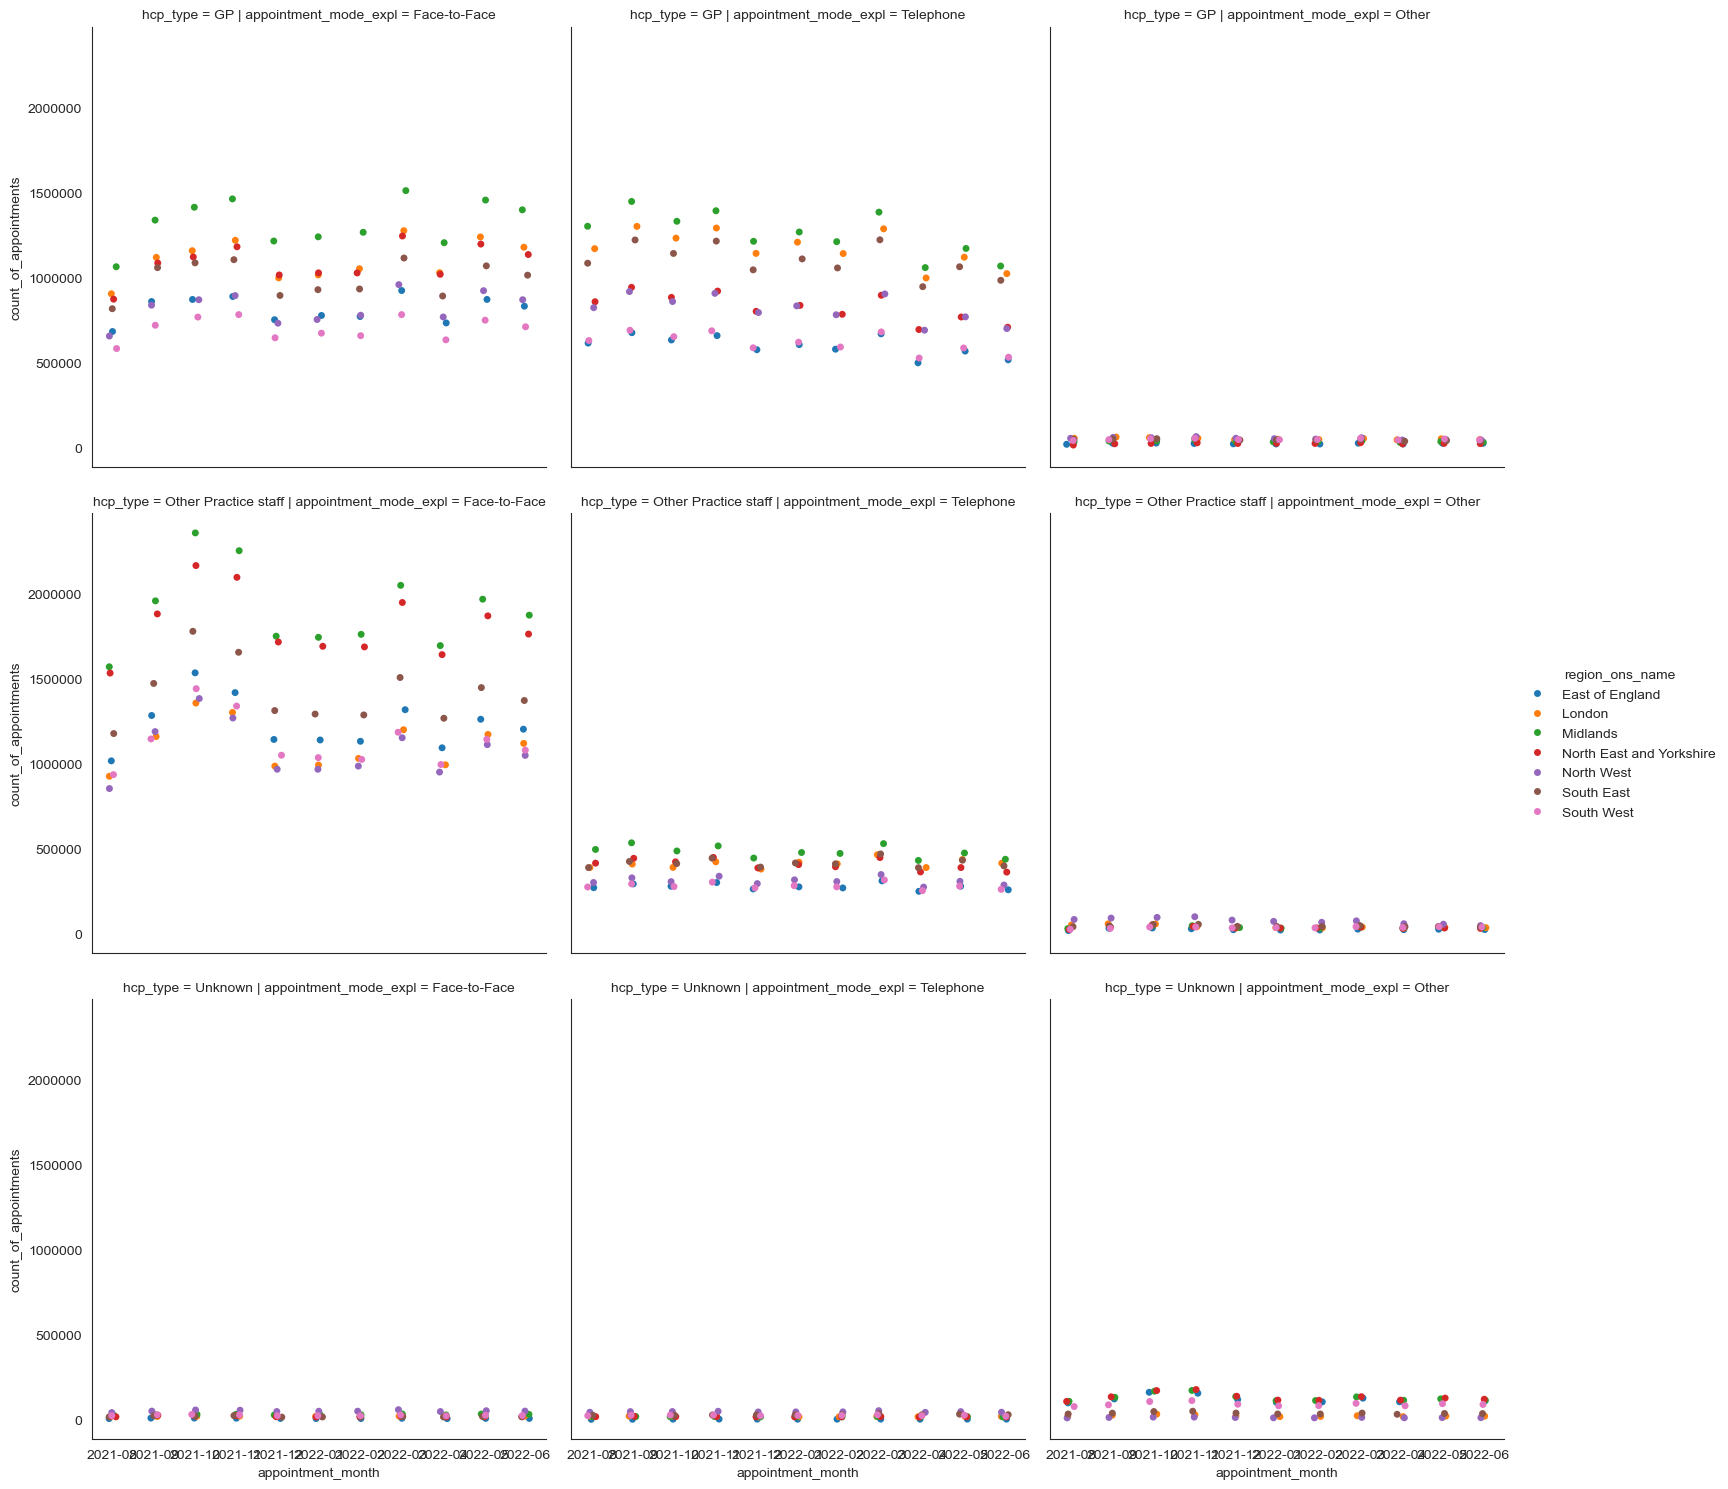

In [314]:
sns.catplot(data=ar_df_att_wtime_hcp_reg_mode_monthly, x='appointment_month', y='count_of_appointments', \
            col='appointment_mode_expl', col_order=['Face-to-Face', 'Telephone', 'Other'], row='hcp_type', hue='region_ons_name', kind='strip')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

### Average waiting time by 'appointment_status' and 'icb_ons_code' monthly 

In [316]:
ar.columns

Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments', 'region_ons_code', 'appointment_status_est',
       'time_between_book_and_appointment_n',
       'time_between_book_and_appointment_est',
       'time_between_book_and_appointment_gr', 'region_ons_name',
       'appointment_mode_expl'],
      dtype='object')

In [317]:
# inputs into user defined function
df_ = ar[ar.appointment_month >= '2021-08'].copy()
par_to_weight_ = 'time_between_book_and_appointment_n'
cols_to_gr_by_list_ = ['appointment_month', 'appointment_status', 'icb_ons_code']
wa_col_name_ = 'time_between_book_and_appointment_avg'
# col_to_weight_by = 'count_of_appointments'

ar_df_icb = weighted_average(df_, par_to_weight_, cols_to_gr_by_list_, wa_col_name_)
ar_df_icb.head()
# ar_df_icb.to_csv('ar_df_icb.csv', index=False)

appointment_month appointment_status icb_ons_code  count_of_appointments  \
0           2021-08           Attended    E54000008                 971735   
1           2021-08           Attended    E54000010                 393482   
2           2021-08           Attended    E54000011                 196788   
3           2021-08           Attended    E54000013                 310949   
4           2021-08           Attended    E54000015                 475673   

   time_between_book_and_appointment_avg  
0                               4.185389  
1                               4.391789  
2                               4.077937  
3                               5.156045  
4                               4.967854

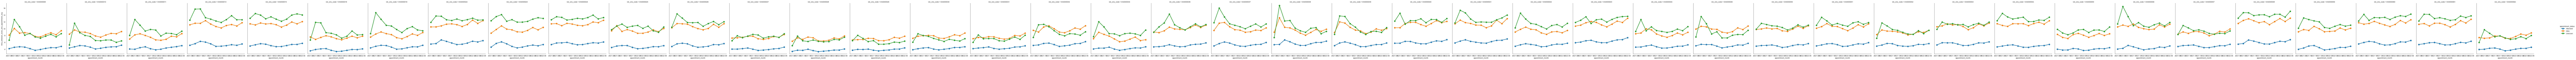

In [318]:
sns.catplot(data=ar_df_icb, x='appointment_month', y='time_between_book_and_appointment_avg', col='icb_ons_code', hue='appointment_status', kind='point')

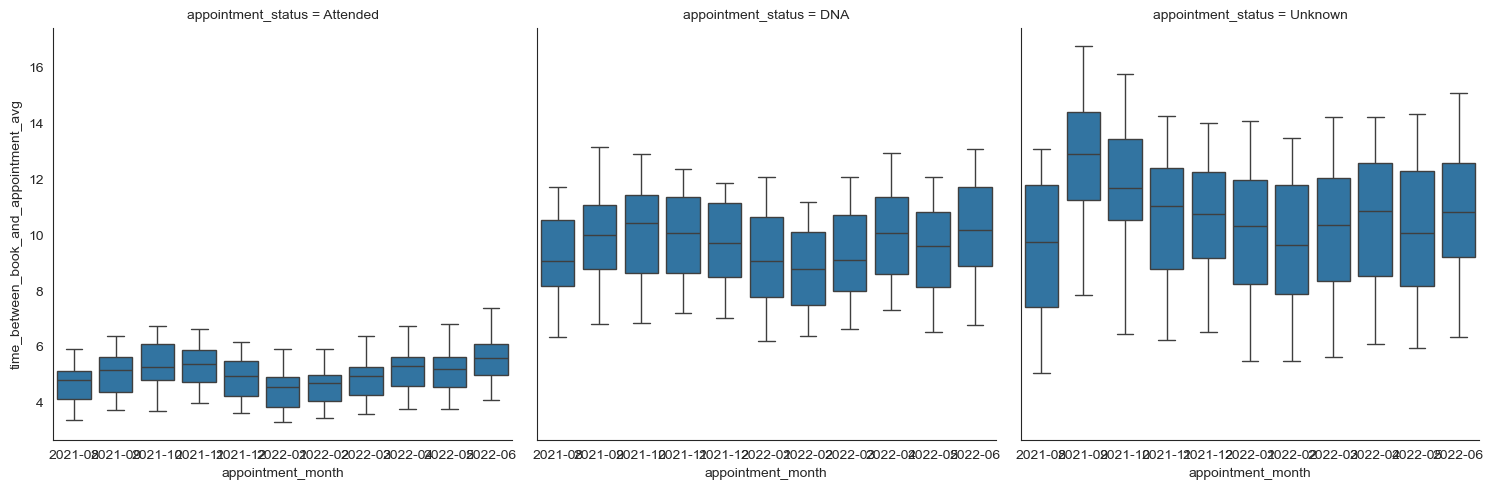

In [319]:
sns.catplot(data=ar_df_icb, x='appointment_month', y='time_between_book_and_appointment_avg', col='appointment_status', kind='box')

### Average waiting time by 'appointment_status' and 'hcp_type' monthly 

Most of the appointments are 'GP' or 'Other Practice staff'. Waiting time for 'Other Practice staff' is higher than for GPs.

In [322]:
# inputs into user defined function
df_ = ar[ar.appointment_month >= '2021-08'].copy()
par_to_weight_ = 'time_between_book_and_appointment_n'
cols_to_gr_by_list_ = ['appointment_month', 'appointment_status', 'hcp_type']
wa_col_name_ = 'time_between_book_and_appointment_avg'
# col_to_weight_by = 'count_of_appointments'

ar_df_hcp = weighted_average(df_, par_to_weight_, cols_to_gr_by_list_, wa_col_name_)
ar_df_hcp.head()
# ar_df_hcp.to_csv('temp_df.csv', index=False)

appointment_month appointment_status              hcp_type  \
0           2021-08           Attended                    GP   
1           2021-08           Attended  Other Practice staff   
2           2021-08           Attended               Unknown   
3           2021-08                DNA                    GP   
4           2021-08                DNA  Other Practice staff   

   count_of_appointments  time_between_book_and_appointment_avg  
0               11712148                               3.080929  
1                9692192                               6.807102  
2                 677425                               2.362712  
3                 272890                               5.866796  
4                 655689                              10.329104

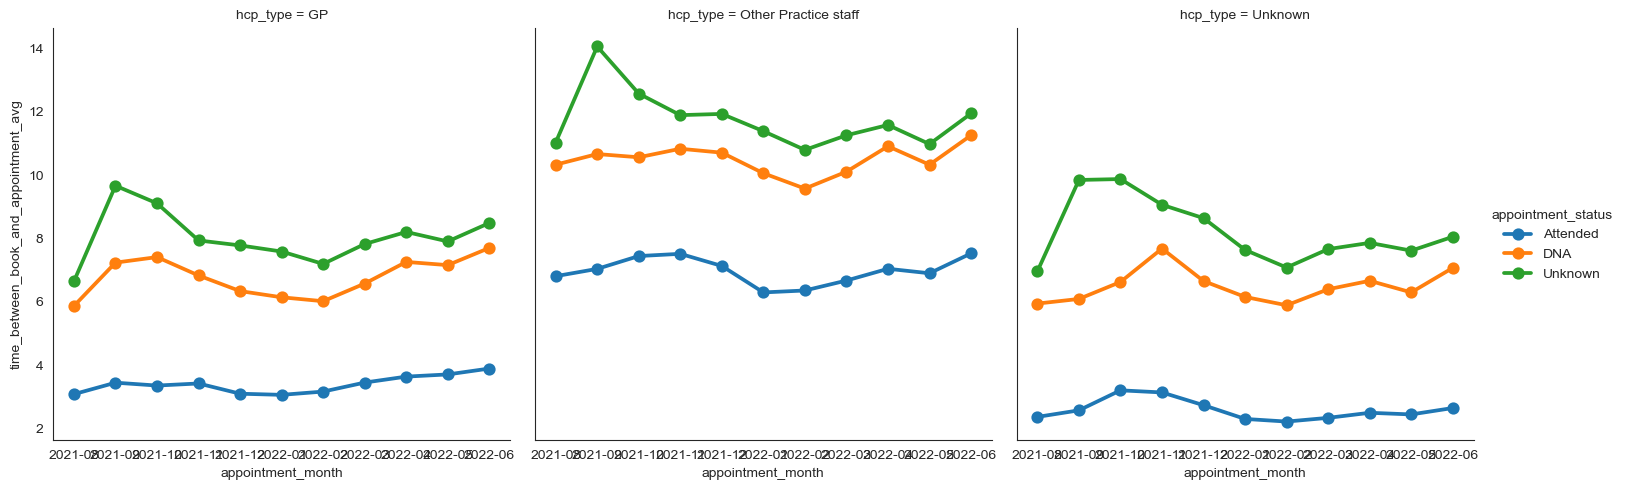

In [323]:
sns.catplot(data=ar_df_hcp, x='appointment_month', y='time_between_book_and_appointment_avg', col='hcp_type', hue='appointment_status', kind='point')

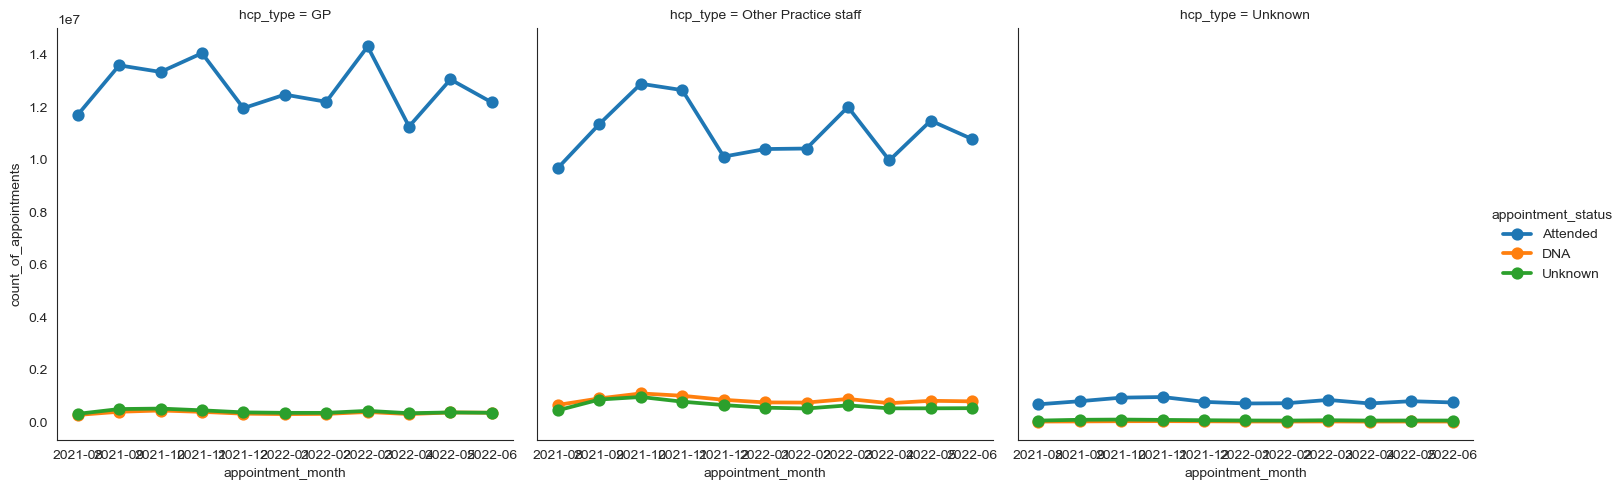

In [324]:
sns.catplot(data=ar_df_hcp, x='appointment_month', y='count_of_appointments', col='hcp_type', hue='appointment_status', kind='point')

### Average waiting time by 'appointment_status' and 'appointment_mode' monthly 

Most of the appointments are 'Face-to-Face' or 'Telephone'. Waiting time for 'Telephone' is lower than for 'Face-to-Face'.

In [327]:
# inputs into user defined function
df_ = ar[ar.appointment_month >= '2021-08'].copy()
par_to_weight_ = 'time_between_book_and_appointment_n'
cols_to_gr_by_list_ = ['appointment_month', 'appointment_status', 'appointment_mode']
wa_col_name_ = 'time_between_book_and_appointment_avg'
# col_to_weight_by = 'count_of_appointments'

ar_df_mode = weighted_average(df_, par_to_weight_, cols_to_gr_by_list_, wa_col_name_)
ar_df_mode.head()
# ar_df_mode.to_csv('temp_df.csv', index=False)

appointment_month appointment_status appointment_mode  \
0           2021-08           Attended     Face-to-Face   
1           2021-08           Attended       Home Visit   
2           2021-08           Attended        Telephone   
3           2021-08           Attended          Unknown   
4           2021-08           Attended     Video/Online   

   count_of_appointments  time_between_book_and_appointment_avg  
0               12486211                               5.817243  
1                 114731                               2.566429  
2                8726555                               3.197112  
3                 652592                               3.571804  
4                 101676                               4.918791

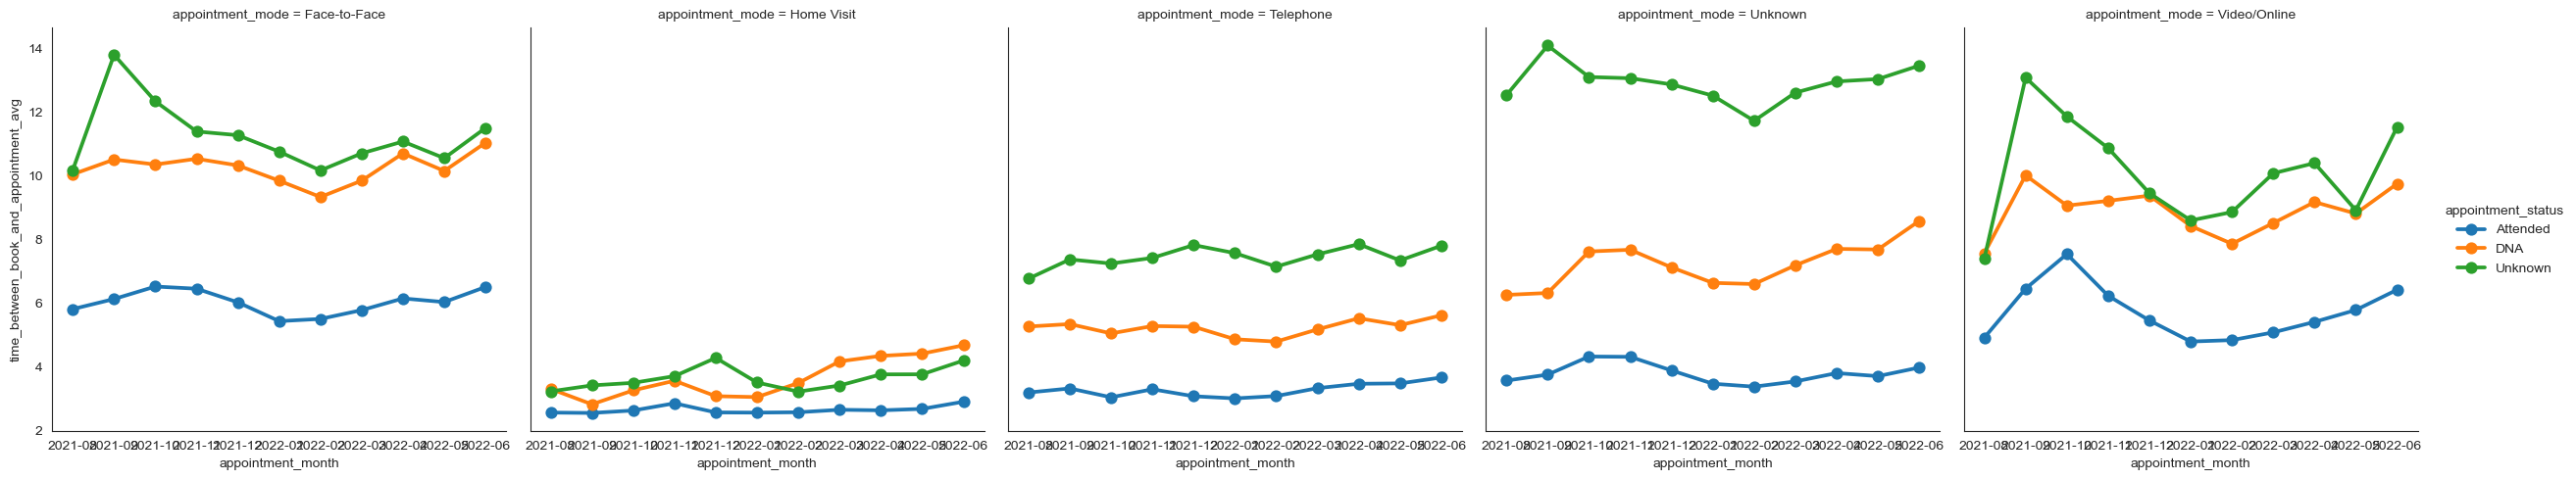

In [328]:
sns.catplot(data=ar_df_mode, x='appointment_month', y='time_between_book_and_appointment_avg', col='appointment_mode', hue='appointment_status', kind='point')

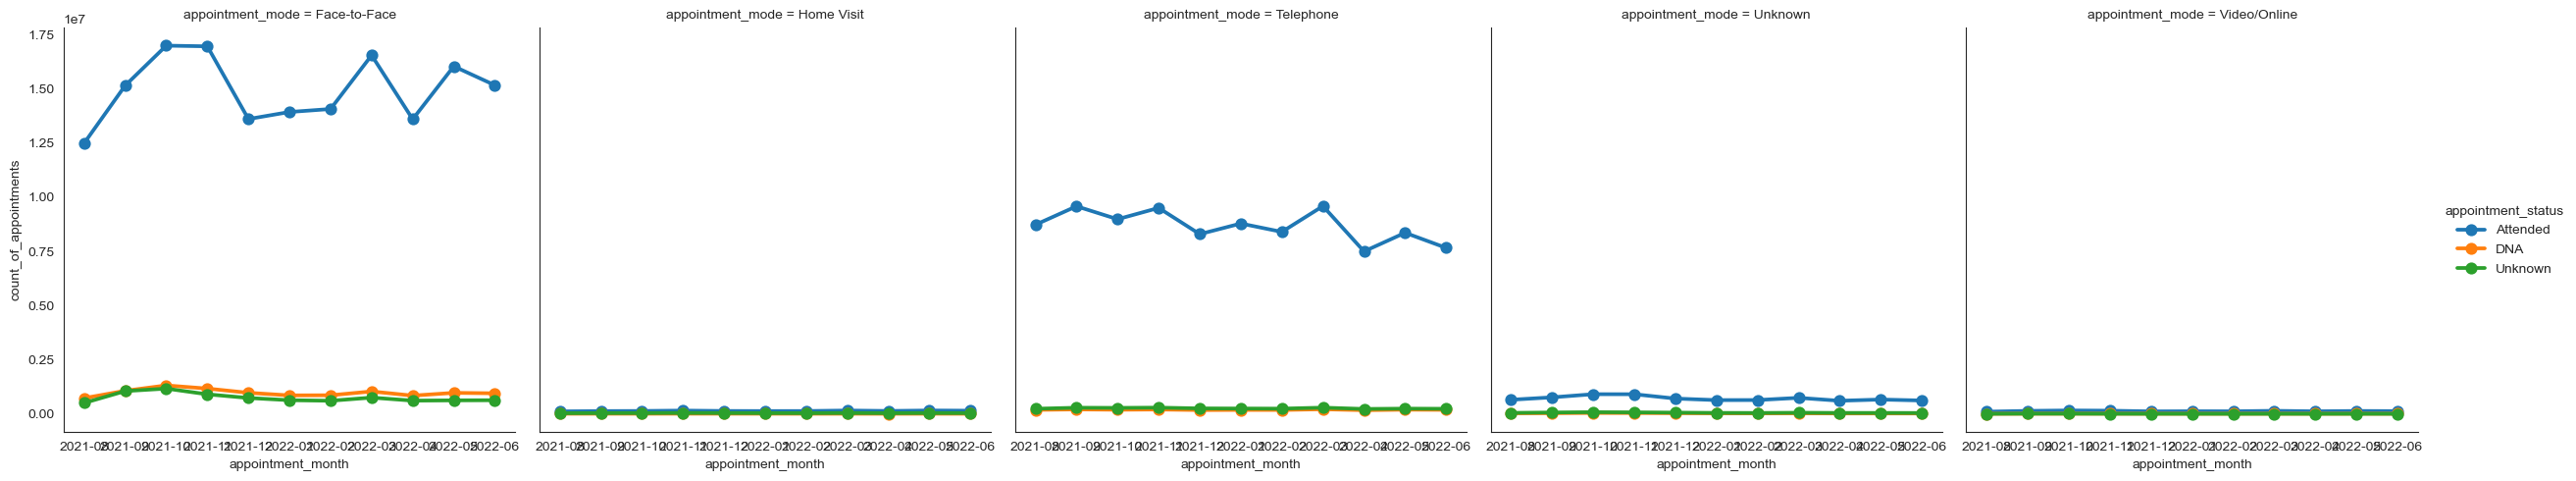

In [329]:
sns.catplot(data=ar_df_mode, x='appointment_month', y='count_of_appointments', col='appointment_mode', hue='appointment_status', kind='point')

### Average waiting time by 'appointment_status' and 'appointment_mode' and 'hcp_type' monthly 

In [331]:
# inputs into user defined function
df_ = ar[ar.appointment_month >= '2021-08'].copy()
par_to_weight_ = 'time_between_book_and_appointment_n'
cols_to_gr_by_list_ = ['appointment_month', 'appointment_status', 'appointment_mode', 'hcp_type']
wa_col_name_ = 'time_between_book_and_appointment_avg'
# col_to_weight_by = 'count_of_appointments'

ar_df_mode_hcp = weighted_average(df_, par_to_weight_, cols_to_gr_by_list_, wa_col_name_)
ar_df_mode_hcp.head()
ar_df_mode_hcp.to_csv('ar_df_mode_hcp.csv', index=False)

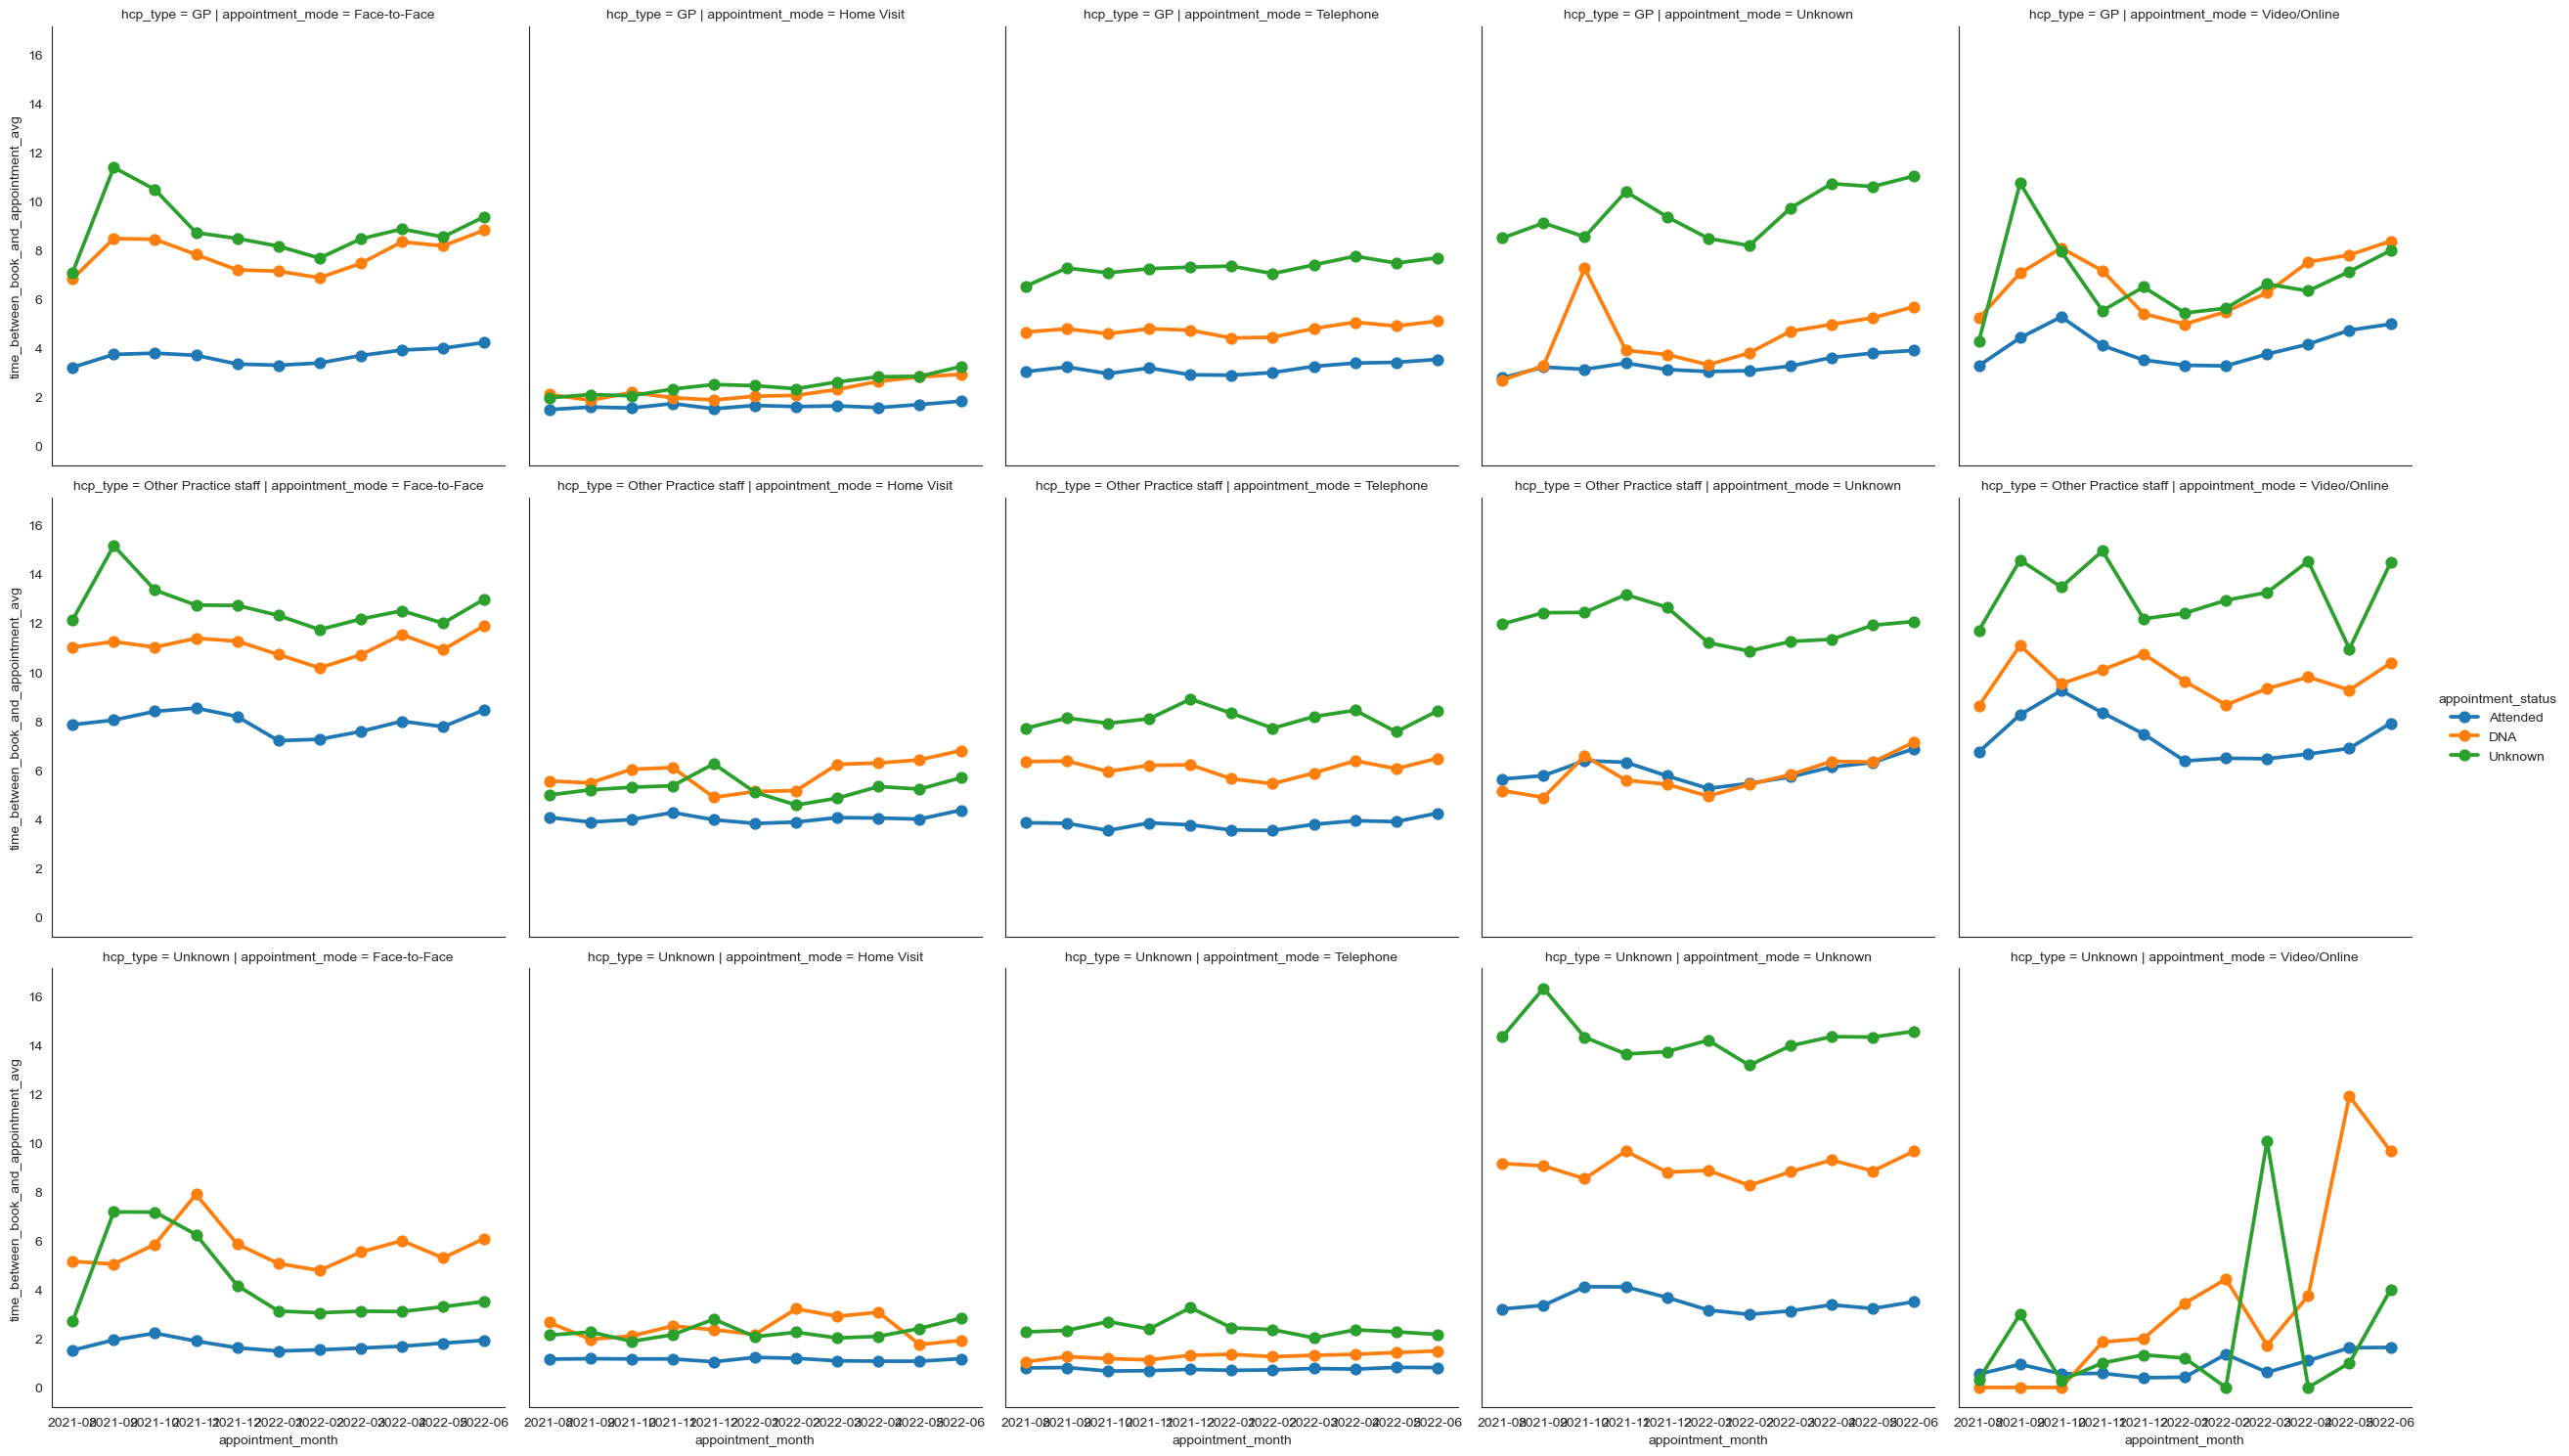

In [332]:
sns.catplot(data=ar_df_mode_hcp, x='appointment_month', y='time_between_book_and_appointment_avg', \
            col='appointment_mode', row='hcp_type', hue='appointment_status', kind='point')

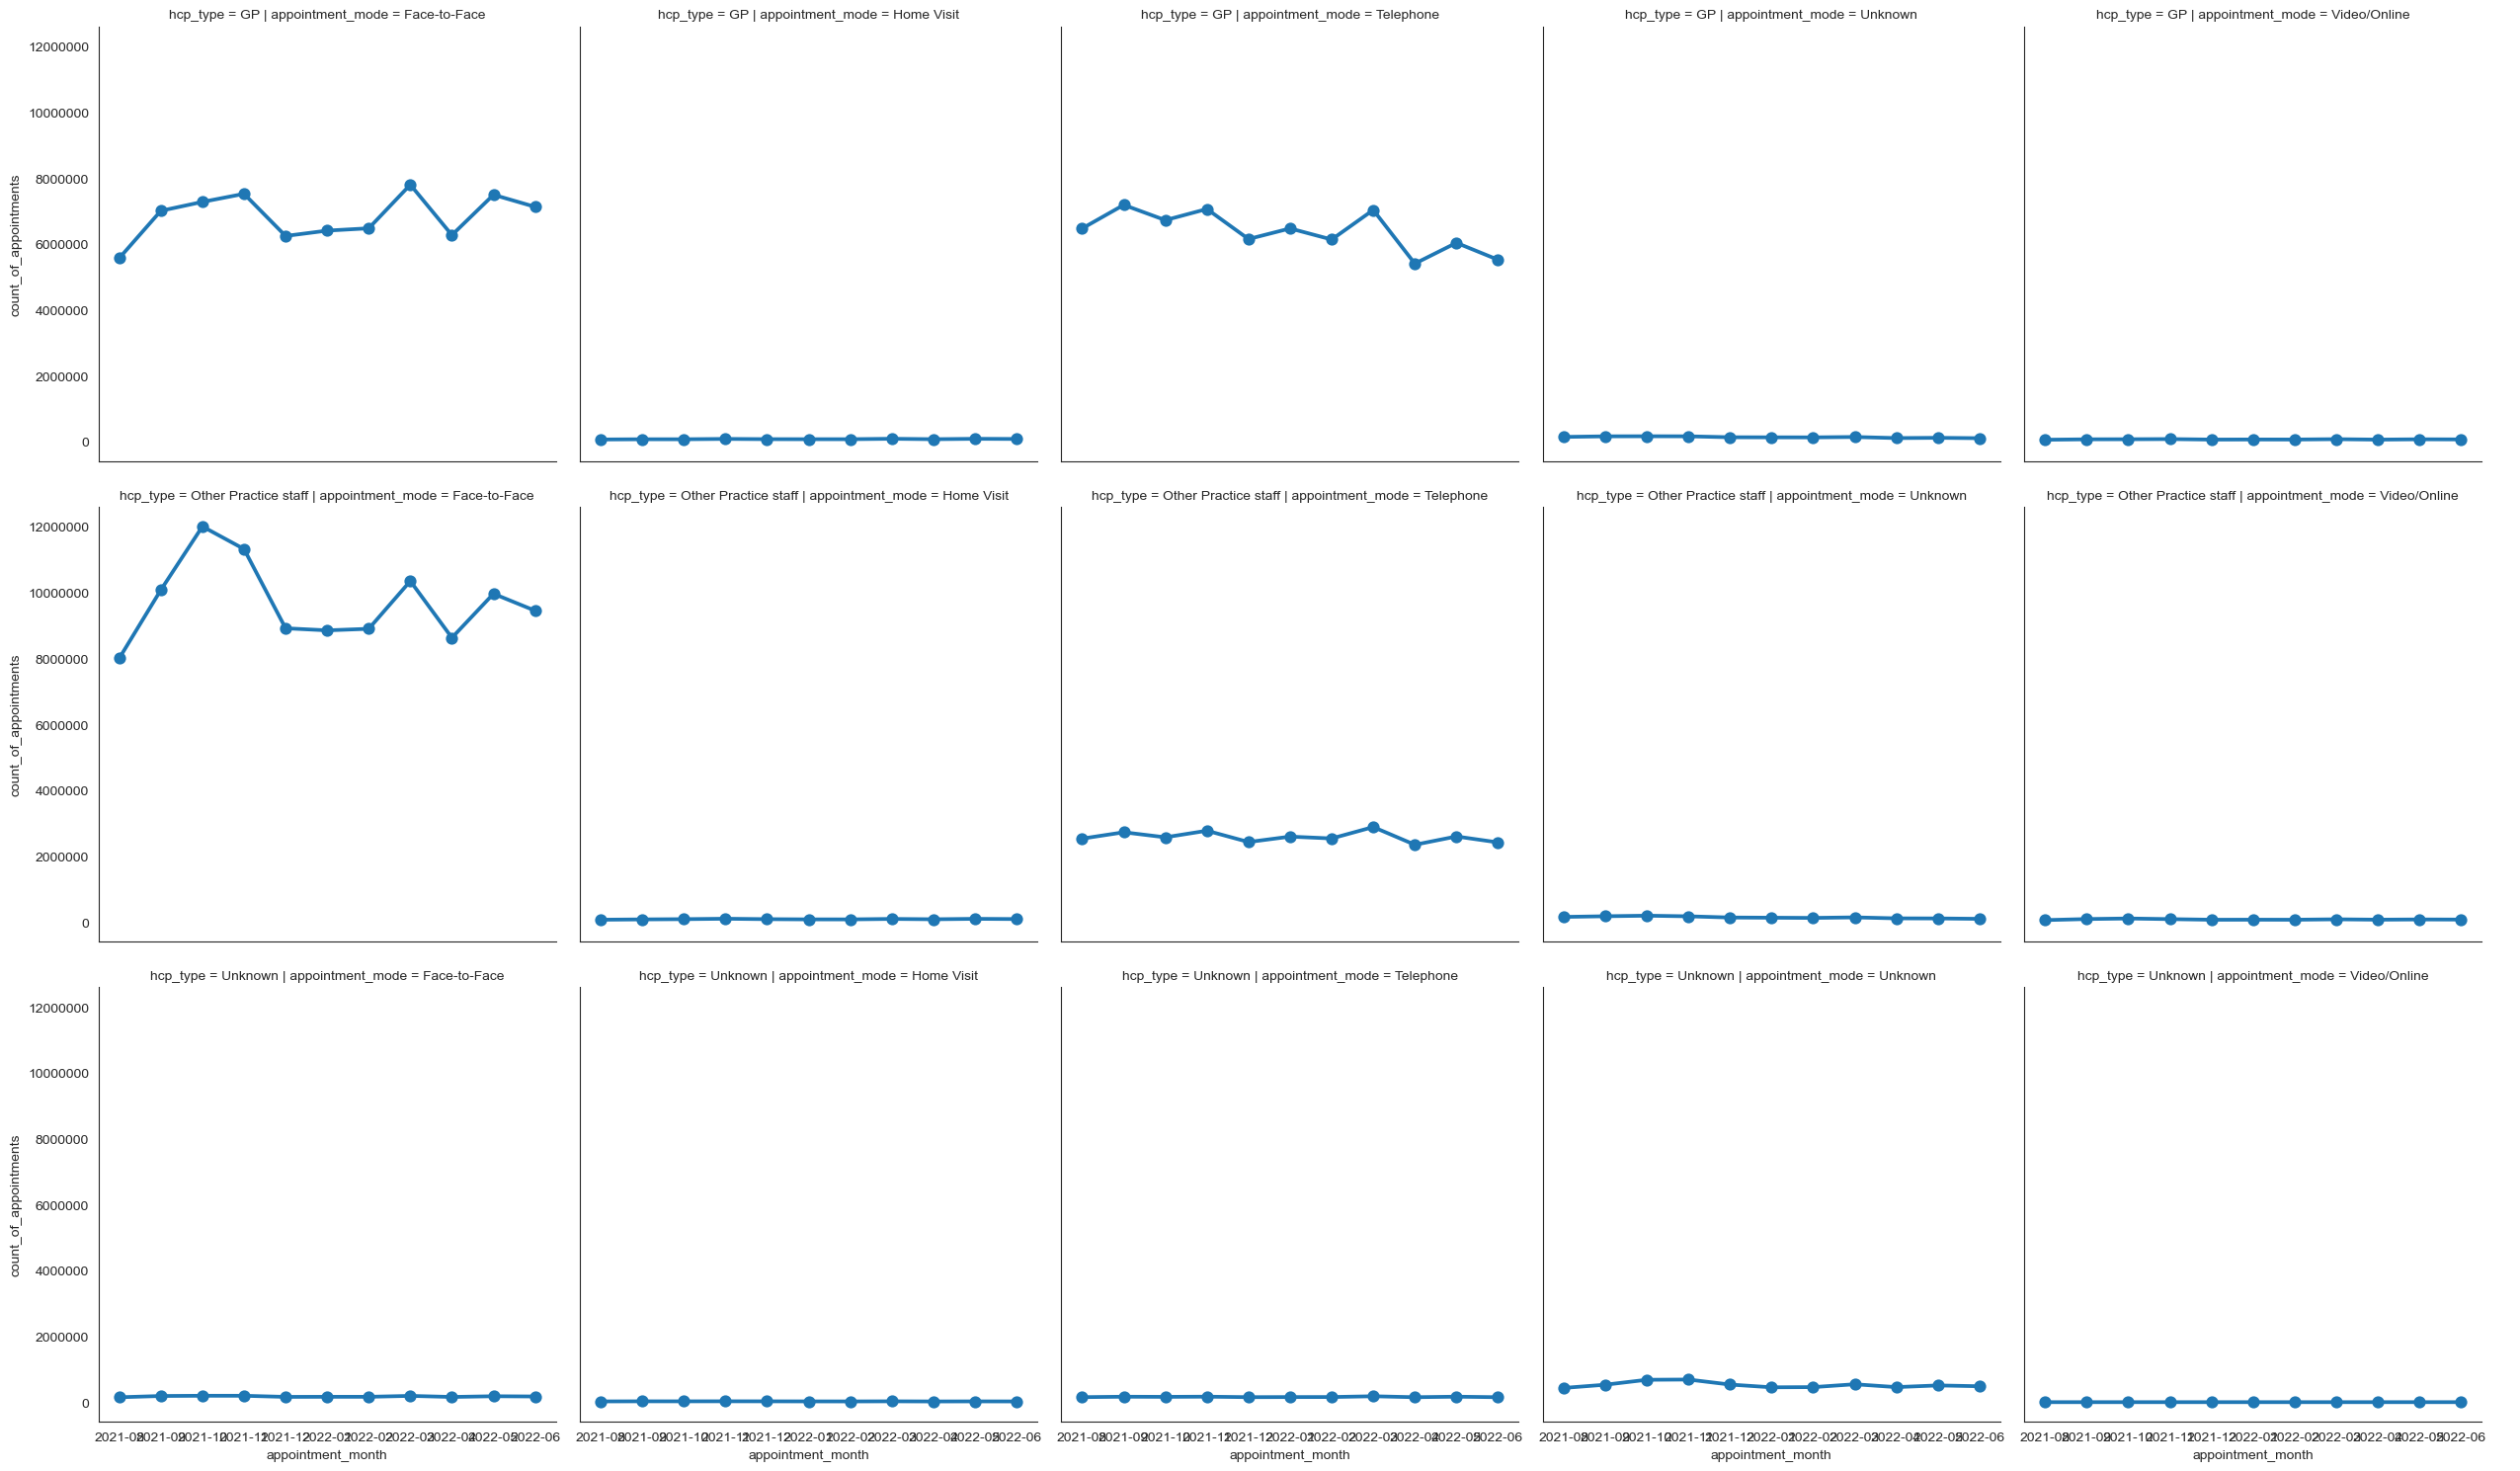

In [333]:
sns.catplot(data=ar_df_mode_hcp, x='appointment_month', y='count_of_appointments', \
            col='appointment_mode', row='hcp_type', estimator='sum', errorbar=None, kind='point')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

#   

# What patterns drive seasonality?

#### by 'appointment_mode_expl'

**Observations:**

1) GP: Appointments are split to Face-to-Face & Telephone c. 50/50
2) Other Practice Staff: The prevailing appointment mode is Face-to-Face


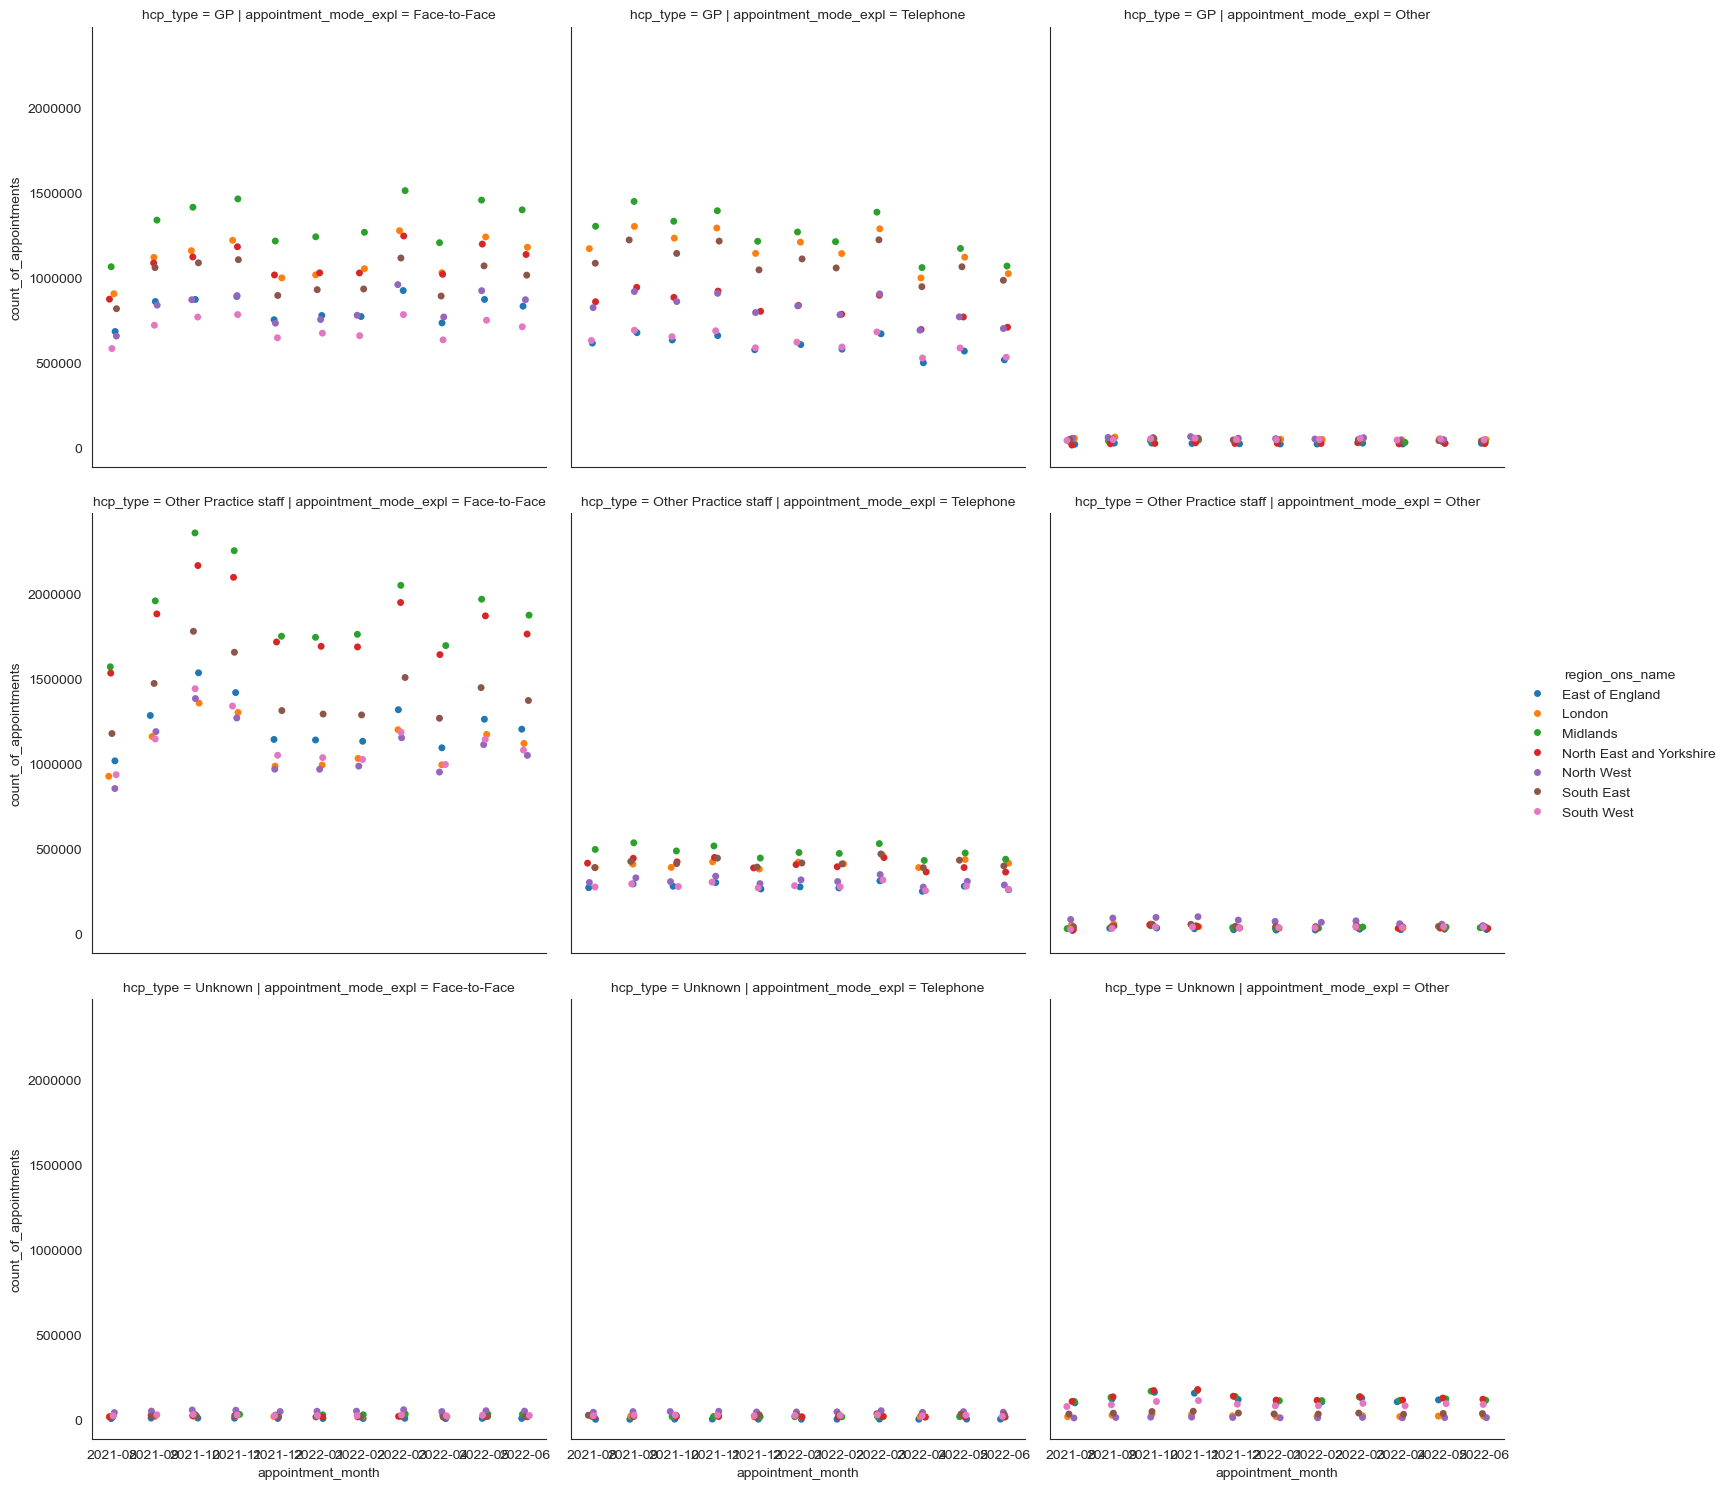

In [338]:
sns.catplot(data=ar_df_att_wtime_hcp_reg_mode_monthly, x='appointment_month', y='count_of_appointments', \
            col='appointment_mode_expl', col_order=['Face-to-Face', 'Telephone', 'Other'], row='hcp_type', hue='region_ons_name', kind='strip')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

#### by 'context_type'

The National Categories are subdivided into three ‘Context Types’. The context describes 
whether an appointment is an encounter relating to direct patient care, or an activity 
undertaken as part of patient care where the patient is not involved. Where category data 
is not received, an appointment is assigned to an ‘Unmapped’ context type.

The only maningful value is Care Related Enterncou. The coumns is not seen as adding valuethe  to analynter

In [341]:
# create DataFrame for analysis
nc_cont = nc[['context_type', 'appointment_month', 'region_ons_name', 'count_of_appointments']]\
.groupby(by=['context_type', 'appointment_month', 'region_ons_name']).sum()

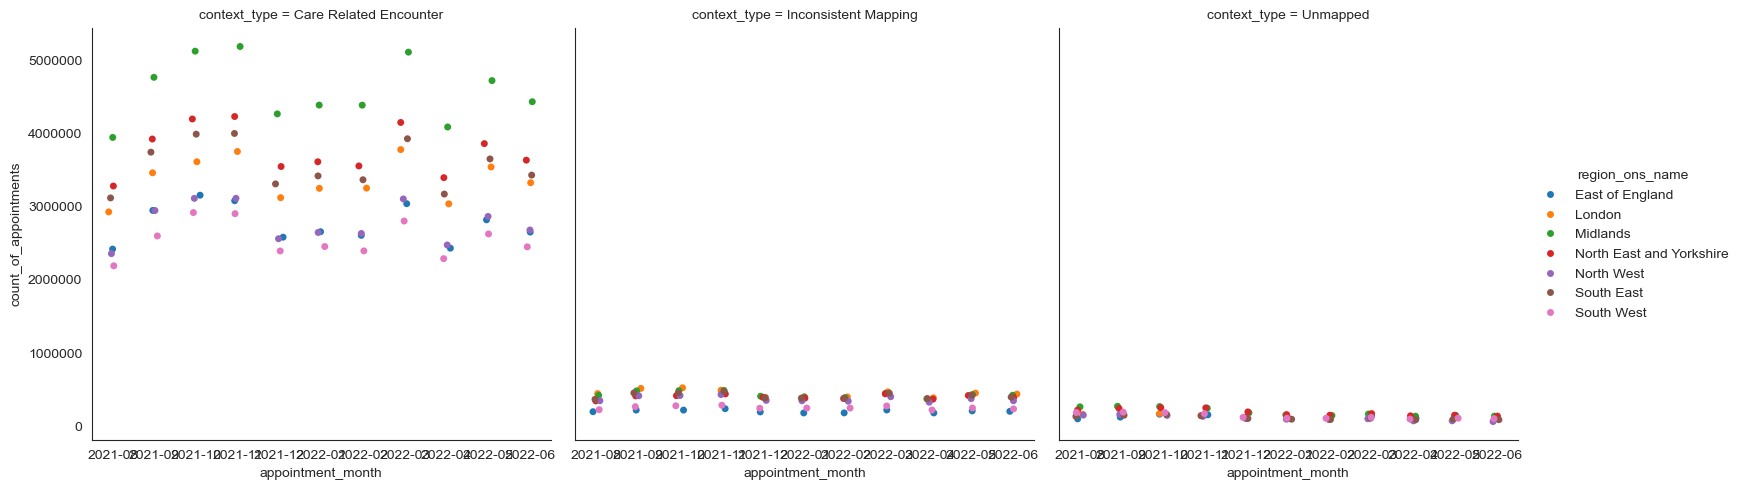

In [342]:
sns.catplot(data=nc_cont, x='appointment_month', y='count_of_appointments', \
            col='context_type', hue='region_ons_name', kind='strip')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

#### by 'service_setting'

Input of service settings other than General Practice is marginal

In [345]:
# Subset and group DataFrame for analysis
nc_sset = nc[['service_setting', 'appointment_month', 'region_ons_name', 'count_of_appointments']]\
.groupby(by=['service_setting', 'appointment_month', 'region_ons_name']).sum()

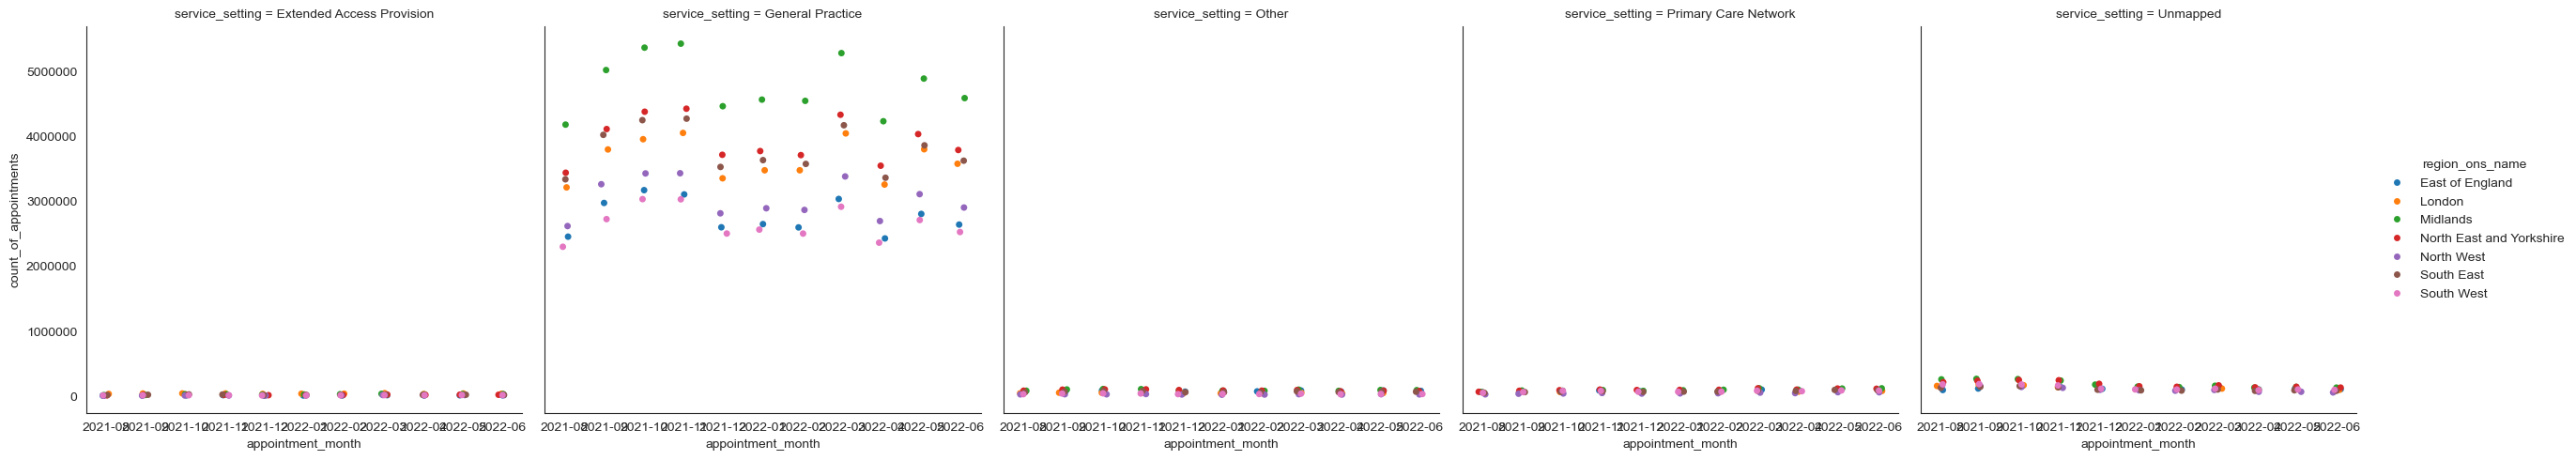

In [346]:
sns.catplot(data=nc_sset, x='appointment_month', y='count_of_appointments', \
            col='service_setting', hue='region_ons_name', kind='strip')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

#### 'national_category'

In [348]:
# Subset and group DataFrame for analysis
nc_nc_monthly = nc[['national_category_expl', 'appointment_month', 'count_of_appointments']]\
.groupby(by=['national_category_expl', 'appointment_month']).sum()

# reshape DataFrame for better readability
nc_nc_monthly = nc_nc_monthly.reset_index().pivot(values='count_of_appointments', columns='national_category_expl', index='appointment_month')


nc_nc_monthly

national_category_expl  General Consultation Acute  \
appointment_month                                    
2021-08                                    4280920   
2021-09                                    4834413   
2021-10                                    4843309   
2021-11                                    5265514   
2021-12                                    4689373   
2022-01                                    4787643   
2022-02                                    4767965   
2022-03                                    5581504   
2022-04                                    4548963   
2022-05                                    5208791   
2022-06                                    4882755   

national_category_expl  General Consultation Routine    Other  \
appointment_month                                               
2021-08                                      7756045  7750299   
2021-09                                      9060243  9075414   
2021-10                                      9256788  9521117   
2021-11                                      9778682  9475134   
2021-12                                      8123938  7836599   
2022-01                                      8645563  7891222   
2022-02                                      8565715  7731861   
2022-03                                     10074249  8934102   
2022-04                                      7998377  7249026   
2022-05                                      9320538  8251573   
2022-06                                      8691384  7774255   

national_category_expl  Planned Clinical Procedure  Unknown  
appointment_month                                            
2021-08                                    1701814  2363093  
2021-09                                    2770296  2782135  
2021-10                                    3870643  2811977  
2021-11                                    3019944  2865796  
2021-12                                    2102959  2387907  
2022-01                                    1957081  2353965  
2022-02                                    1956726  2332993  
2022-03                                    2281907  2723276  
2022-04                                    1868140  2248554  
2022-05                                    2141111  2573495  
2022-06                                    2032073  2447611

In [349]:
# Subset and group DataFrame for analysis
nc_nc_daily = nc[nc.day_of_week_type == 'working'][['appointment_date', 'national_category_expl', 'appointment_month', 'count_of_appointments']]\
.groupby(by=['appointment_date', 'national_category_expl', 'appointment_month']).sum()

# reshape DataFrame for better readability
nc_nc_daily = nc_nc_daily.reset_index()
#.pivot(values='count_of_appointments', columns='national_category_expl', index=['appointment_date', 'appointment_month']).reset_index(level=-1).groupby(by='appointment_month').mean().reset_index()

nc_nc_daily

appointment_date        national_category_expl appointment_month  \
0          2021-08-02    General Consultation Acute           2021-08   
1          2021-08-02  General Consultation Routine           2021-08   
2          2021-08-02                         Other           2021-08   
3          2021-08-02    Planned Clinical Procedure           2021-08   
4          2021-08-02                       Unknown           2021-08   
...               ...                           ...               ...   
1145       2022-06-30    General Consultation Acute           2022-06   
1146       2022-06-30  General Consultation Routine           2022-06   
1147       2022-06-30                         Other           2022-06   
1148       2022-06-30    Planned Clinical Procedure           2022-06   
1149       2022-06-30                       Unknown           2022-06   

      count_of_appointments  
0                    227451  
1                    390906  
2                    400960  
3                     82055  
4                    121396  
...                     ...  
1145                 227923  
1146                 413648  
1147                 368610  
1148                 100397  
1149                 116168  

[1150 rows x 4 columns]

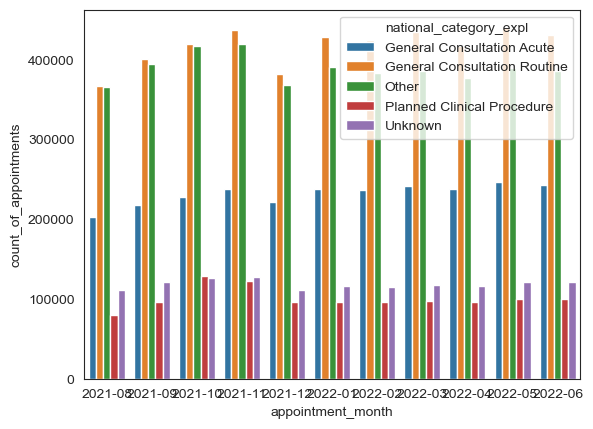

In [350]:
sns.barplot(data=nc_nc_daily, x='appointment_month', y='count_of_appointments', hue='national_category_expl', errorbar=None)

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

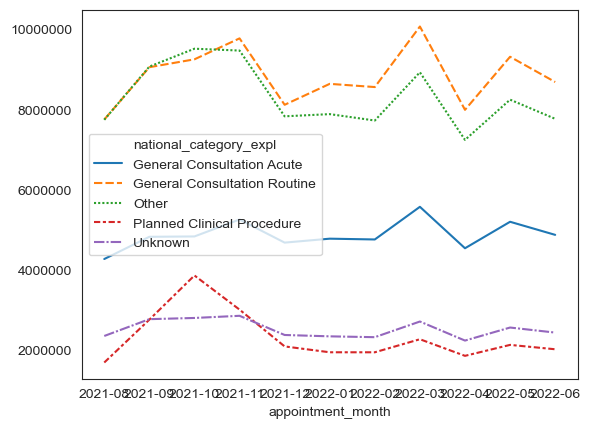

In [351]:
sns.lineplot(data=nc_nc_monthly)

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

In [352]:
nc_nc_monthly = nc[['national_category', 'count_of_appointments']]\
.groupby(by=['national_category']).sum().sort_values(by='count_of_appointments', ascending=False)
nc_nc_monthly.to_csv('nc.csv')

In [353]:
# Subset and group DataFrame for analysis
nc_nc_reg_monthly = nc[['national_category_expl', 'appointment_month', 'region_ons_name', 'count_of_appointments']]\
.groupby(by=['national_category_expl', 'appointment_month', 'region_ons_name']).sum().reset_index()

In [354]:
nc_nc_reg_monthly.columns

Index(['national_category_expl', 'appointment_month', 'region_ons_name',
       'count_of_appointments'],
      dtype='object')

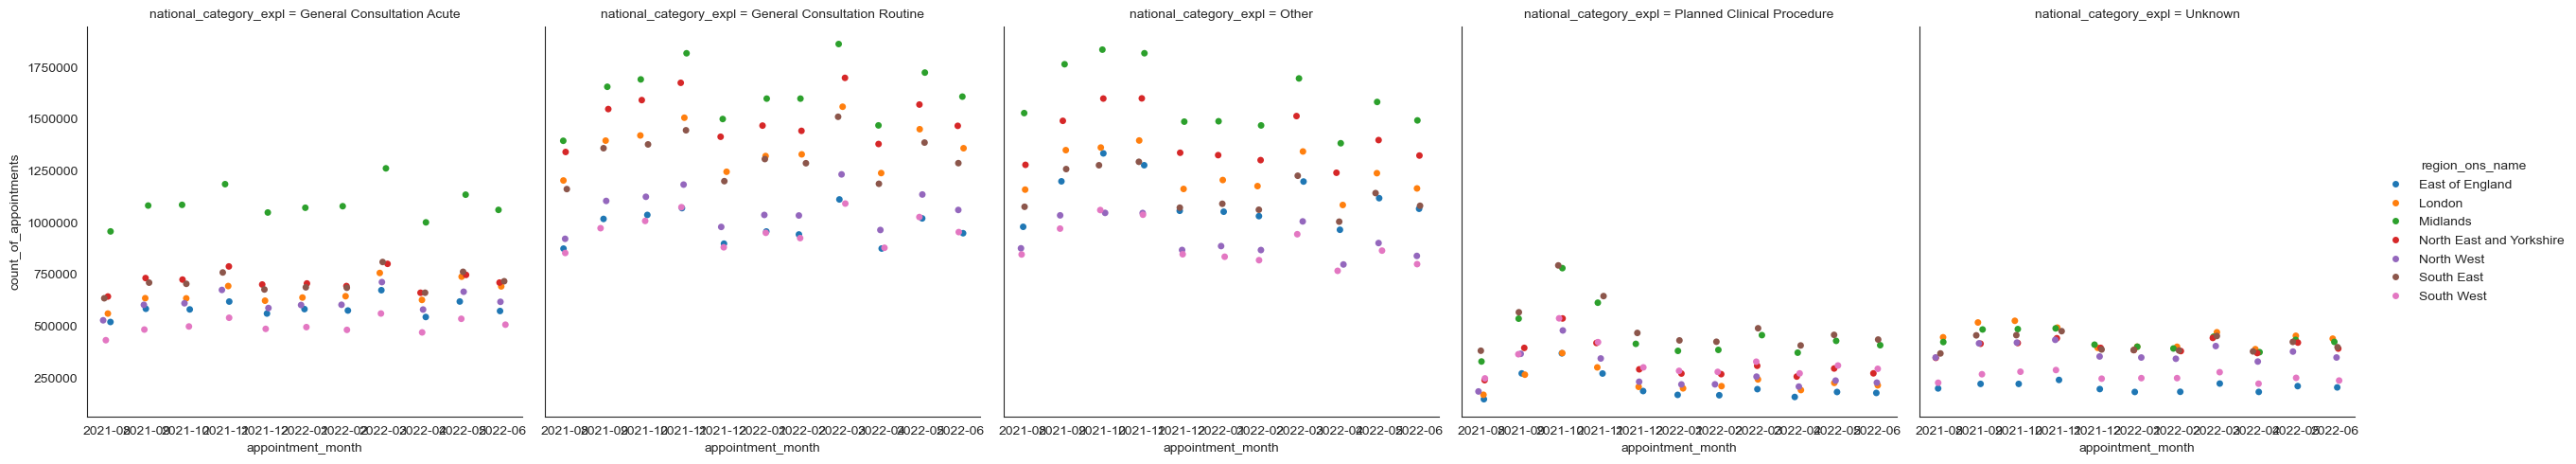

In [355]:
sns.catplot(data=nc_nc_reg_monthly, x='appointment_month', y='count_of_appointments', \
            col='national_category_expl', hue='region_ons_name', kind='strip')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

#   

# Explanatory Visualisations for Presentation

#### SUMMARY 1 

In [359]:
# Calculate DNA as a percentage of total appointments monthly (based on ar to cover the 11 months)

# Subset required columns from ar DataFrame
ar_df_missed_monthly = ar[ar.appointment_month >= '2021-08'][['appointment_month', 'appointment_status_est', 'count_of_appointments']]\
.groupby(by=['appointment_month', 'appointment_status_est']).sum()

# reset index
ar_df_missed_monthly = ar_df_missed_monthly.reset_index(level=-1)

# Pivot the DF
ar_df_missed_monthly = ar_df_missed_monthly.pivot(columns='appointment_status_est', values='count_of_appointments')

# Add Total column
ar_df_missed_monthly['Total'] = ar_df_missed_monthly['Attended_est'] + ar_df_missed_monthly['DNA_est']

# Add 'DNA_est_%' column equal to 'DNA' / 'Total'
ar_df_missed_monthly['DNA_est_%'] = round((ar_df_missed_monthly['DNA_est'] / ar_df_missed_monthly['Total']) * 100 , 1)

#view the output
ar_df_missed_monthly.head()

appointment_status_est  Attended_est  DNA_est     Total  DNA_est_%
appointment_month                                                 
2021-08                     22081765  1770406  23852171        7.4
2021-09                     25757066  2765435  28522501        9.7
2021-10                     27170506  3133328  30303834       10.3
2021-11                     27667665  2737405  30405070        9.0
2021-12                     22853483  2287293  25140776        9.1

In [360]:
# calculate daily average booked appointments on working days and group on monthly basis (based on nc to cover 11 months)
daily_avg_booked_app_monthly_wd = nc_dwt_daily[nc_dwt_daily.day_of_week_type == 'working'][['appointment_month', 'count_of_appointments']]\
.groupby(by='appointment_month').mean()
daily_avg_booked_app_monthly_wd['count_of_appointments'] = daily_avg_booked_app_monthly_wd['count_of_appointments'].astype(np.int64)
daily_avg_booked_app_monthly_wd.columns = ['daily_avg_booked_app_act']

daily_avg_booked_app_monthly_wd

daily_avg_booked_app_act
appointment_month                          
2021-08                             1129529
2021-09                             1233360
2021-10                             1321946
2021-11                             1345518
2021-12                             1182330
2022-01                             1272445
2022-02                             1259643
2022-03                             1278974
2022-04                             1247687
2022-05                             1300806
2022-06                             1283363

- Actual daily average attended appointments on working days available for 7 months covered by ar dataset only.
- To derive an estimate for the another 4 months (out of 11) covered in nc assume that missed appointments rate for working and weekends does not differ materially (see reconcilation for 7 months covered in ad).
- Daily average attended appointments are estimated based on avg daily booked and missed app rates.


In [362]:
# Calculate actual daily average attended appointments on working days (7 months)
daily_avg_booked_app_monthly_wd_act = ad[ad.day_of_week_type == 'working'][['appointment_date', 'appointment_month', 'count_of_appointments']]\
.groupby(by=['appointment_date', 'appointment_month']).sum().reset_index()[['appointment_month', 'count_of_appointments']]\
.groupby(by='appointment_month').mean()
daily_avg_booked_app_monthly_wd_act['count_of_appointments'] = daily_avg_booked_app_monthly_wd_act['count_of_appointments'].astype(np.int64)
daily_avg_booked_app_monthly_wd_act.columns = ['daily_avg_att_app_act']

daily_avg_booked_app_monthly_wd_act

daily_avg_att_app_act
appointment_month                       
2021-12                          1077079
2022-01                          1172308
2022-02                          1160613
2022-03                          1174629
2022-04                          1146101
2022-05                          1199637
2022-06                          1178878

Given differences are immaterial, proceed with the daily_avg_att_app_est

In [364]:
# prepare summary DataFrame to estimate daily average attended appointments on working days 
summary_df = pd.merge(daily_avg_booked_app_monthly_wd, ar_df_missed_monthly['DNA_est_%'], left_index=True, right_index=True)
summary_df['daily_avg_att_app_est'] = summary_df['daily_avg_booked_app_act'] * (1 - summary_df['DNA_est_%'] / 100)
summary_df = pd.merge(summary_df, daily_avg_booked_app_monthly_wd_act, left_index=True, right_index=True, how='outer')
summary_df['reconciliation_%'] = summary_df['daily_avg_att_app_est'] / summary_df['daily_avg_att_app_act']
summary_df.reset_index(inplace=True)

summary_df

appointment_month  daily_avg_booked_app_act  DNA_est_%  \
0            2021-08                   1129529        7.4   
1            2021-09                   1233360        9.7   
2            2021-10                   1321946       10.3   
3            2021-11                   1345518        9.0   
4            2021-12                   1182330        9.1   
5            2022-01                   1272445        8.0   
6            2022-02                   1259643        7.9   
7            2022-03                   1278974        8.2   
8            2022-04                   1247687        8.2   
9            2022-05                   1300806        7.8   
10           2022-06                   1283363        8.2   

    daily_avg_att_app_est  daily_avg_att_app_act  reconciliation_%  
0             1045943.854                    NaN               NaN  
1             1113724.080                    NaN               NaN  
2             1185785.562                    NaN               NaN  
3             1224421.380                    NaN               NaN  
4             1074737.970              1077079.0          0.997827  
5             1170649.400              1172308.0          0.998585  
6             1160131.203              1160613.0          0.999585  
7             1174098.132              1174629.0          0.999548  
8             1145376.666              1146101.0          0.999368  
9             1199343.132              1199637.0          0.999755  
10            1178127.234              1178878.0          0.999363

**Note:** We observe two clusters (working days/holidays) and seasonal trends. Recognising this and the variability in the working/calendar days ratio per month, in utilisation analysis, we focus on working-day daily averages to assess full capacity.

The average daily full capacity of 1,260,000 (rounded to 10,000), which is comparable with the 1,200,000 utilised for planning, is calculated as the daily average number of booked appointments on working days throughout 11 months.

[Text(0, 0.0, '0.0m'),
 Text(0, 200000.0, '0.2m'),
 Text(0, 400000.0, '0.4m'),
 Text(0, 600000.0, '0.6m'),
 Text(0, 800000.0, '0.8m'),
 Text(0, 1000000.0, '1.0m'),
 Text(0, 1200000.0, '1.2m'),
 Text(0, 1400000.0, '1.4m'),
 Text(0, 1600000.0, '1.6m'),
 Text(0, 1800000.0, '1.8m')]

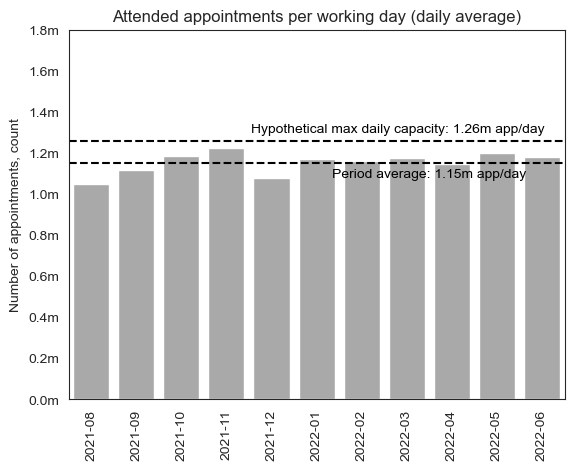

In [366]:
# Plot avg daily attended appointments per working day by month 
g = sns.barplot(data=summary_df, x='appointment_month', y='daily_avg_att_app_est', color='#A9A9A9')

# Add annotation line: avg daily booked appointments per working day during 11 months
plt.axhline(y=summary_df['daily_avg_booked_app_act'].mean(), color='k', linestyle='--')
plt.text(6.8, summary_df['daily_avg_booked_app_act'].mean() + 55000, \
         f"Hypothetical max daily capacity: {round(summary_df['daily_avg_booked_app_act'].mean()/1000000, 2)}m app/day", \
         fontsize=10, color='black', ha='center', va='center')

# Add annotation line: avg daily attended appointments per working day during 11 months (estimate)
plt.axhline(y=summary_df['daily_avg_att_app_est'].mean(), color='k', linestyle='--')
plt.text(7.5, summary_df['daily_avg_att_app_est'].mean() - 55000, \
         f"Period average: {round(summary_df['daily_avg_att_app_est'].mean()/1000000, 2)}m app/day", \
         fontsize=10, color='black', ha='center', va='center')

# formatting
plt.title('Attended appointments per working day (daily average)')
plt.ylabel('Number of appointments, count')
plt.xlabel('')
#plt.ticklabel_format(style='plain', axis='y')  
plt.xticks(rotation=90)
plt.ylim([0, 1800000])
plt.yticks(g.get_yticks())
ylabels = ['{:,.1f}'.format(x) + 'm' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels)

#### SUMMARY 2 

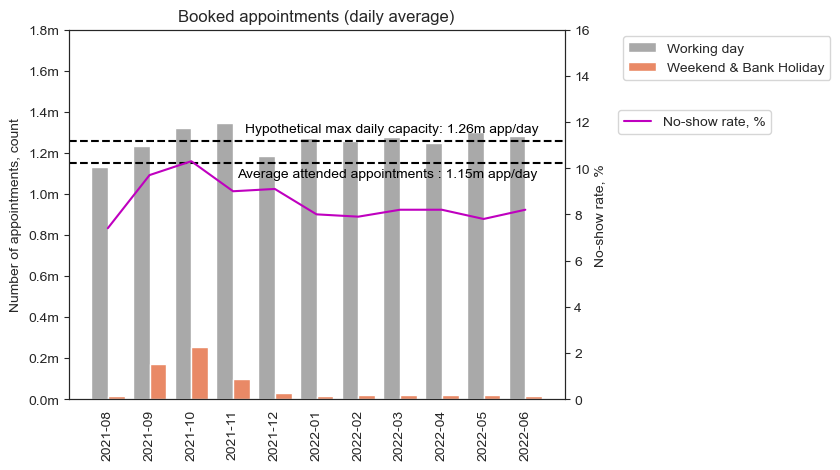

In [368]:
# create a plot with a secondary y-axis
fig, ax1 = plt.subplots()

palette = ['#A9A9A9', 'coral']

# plot booked appointments
g = sns.barplot(data=nc_dwt_daily, x='appointment_month', y='count_of_appointments', \
            hue='day_of_week_type', hue_order=['working', 'holiday'], estimator='mean', errorbar=None, palette=palette)

# Add annotation line: avg daily booked appointments per working day during 11 months
plt.axhline(y=summary_df['daily_avg_booked_app_act'].mean(), color='k', linestyle='--')
plt.text(6.8, summary_df['daily_avg_booked_app_act'].mean() + 55000, \
         f"Hypothetical max daily capacity: {round(summary_df['daily_avg_booked_app_act'].mean()/1000000, 2)}m app/day", \
         fontsize=10, color='black', ha='center', va='center')

# Add annotation line: avg daily attended appointments per working day during 11 months (estimate)
plt.axhline(y=summary_df['daily_avg_att_app_est'].mean(), color='k', linestyle='--')
plt.text(6.7, summary_df['daily_avg_att_app_est'].mean() - 55000, \
         f"Average attended appointments : {round(summary_df['daily_avg_att_app_est'].mean()/1000000, 2)}m app/day", \
         fontsize=10, color='black', ha='center', va='center')

# formatting 
plt.title('Booked appointments (daily average)')

# x axis formatting 
plt.xlabel('')  
plt.xticks(rotation=90)

# ax1 formatting 
ax1.set_ylabel('Number of appointments, count')
ax1.set_ylim([0, 1800000])
ax1.set_yticks(g.get_yticks())
ylabels = ['{:,.1f}'.format(x) + 'm' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels)

ax2 = ax1.twinx()

# plot missed app ratio 
sns.lineplot(data=summary_df, x='appointment_month', y='DNA_est_%', color='m')

# ax2 formatting 
ax2.set_ylabel('No-show rate, %')
ax2.set_ylim([0, 16])

# add legend
ax1.legend(['Working day', 'Weekend & Bank Holiday'], bbox_to_anchor=(1.55,1))
ax2.legend(['No-show rate, %'], bbox_to_anchor=(1.43,0.8))

plt.show()

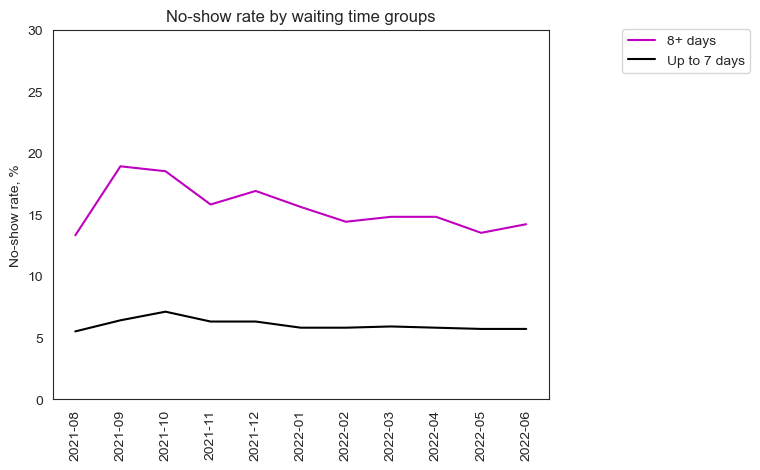

In [369]:
# plot average missed appointments rates by month and waiting time group  

palette = ['m', 'k']

sns.lineplot(data=ar_attest_wtggr_m, x='appointment_month', y='DNA_%', hue='time_between_book_and_appointment_gr', palette=palette,)

# set basic formatting  
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 1.0))


plt.title('No-show rate by waiting time groups')
plt.ylabel('No-show rate, %')
plt.xlabel('')
plt.ylim([0, 30])
plt.legend(bbox_to_anchor=(1.42, 1.02))

#### Slide 2 

[Text(0, 0.0, '0.0m'),
 Text(0, 200000.0, '0.2m'),
 Text(0, 400000.0, '0.4m'),
 Text(0, 600000.0, '0.6m'),
 Text(0, 800000.0, '0.8m'),
 Text(0, 1000000.0, '1.0m'),
 Text(0, 1200000.0, '1.2m'),
 Text(0, 1400000.0, '1.4m'),
 Text(0, 1600000.0, '1.6m'),
 Text(0, 1800000.0, '1.8m')]

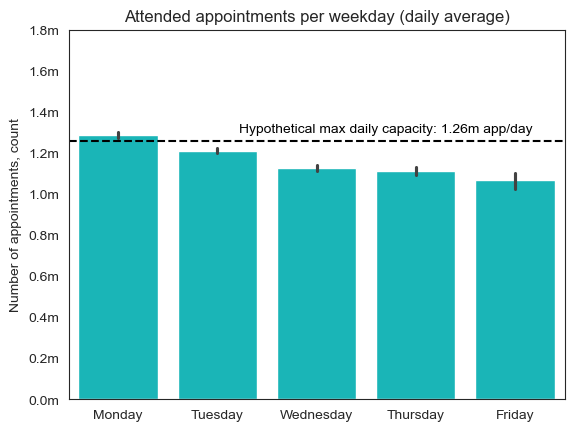

In [371]:
g = sns.barplot(data=ad_dwt_daily[ad_dwt_daily.day_of_week_type == 'working'], x='day_of_week', y='count_of_appointments', \
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], \
            estimator='mean', color='#00CED1')

# Add annotation line: avg daily booked appointments per working day during 11 months
plt.axhline(y=summary_df['daily_avg_booked_app_act'].mean(), color='k', linestyle='--')
plt.text(2.7, summary_df['daily_avg_booked_app_act'].mean() + 55000, \
         f"Hypothetical max daily capacity: {round(summary_df['daily_avg_booked_app_act'].mean()/1000000, 2)}m app/day", \
         fontsize=10, color='black', ha='center', va='center')

# change the y-axis format to non-scientific
plt.ticklabel_format(style='plain', axis='y')

plt.title('Attended appointments per weekday (daily average)')
plt.ylabel('Number of appointments, count')
plt.xlabel('')
plt.ylim([0, 1800000])
plt.yticks(g.get_yticks())
ylabels = ['{:,.1f}'.format(x) + 'm' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels)

#### Slide 3 

In [373]:
# Calculate DNA as a percentage of total appointments per set groups  
ar_df_desc_missed_app = ar[ar.appointment_month >= '2021-08'][['appointment_month', 'region_ons_code', 'hcp_type', 'region_ons_name', 'appointment_status', 'count_of_appointments']]\
.groupby(by=['appointment_month', 'region_ons_code', 'hcp_type', 'region_ons_name', 'appointment_status']).sum()

# reset index
ar_df_desc_missed_app = ar_df_desc_missed_app.reset_index(level=-1)

# pivot the DF
ar_df_desc_missed_app = ar_df_desc_missed_app.pivot(columns='appointment_status', values='count_of_appointments')

# add Total column
ar_df_desc_missed_app['Total'] = ar_df_desc_missed_app['Attended'] + ar_df_desc_missed_app['DNA'] + ar_df_desc_missed_app['Unknown']

# Add 'DNA_%' column equal to 'DNA' / 'Total'
ar_df_desc_missed_app['DNA_est_%'] = round(((ar_df_desc_missed_app['DNA'] + ar_df_desc_missed_app['Unknown']) / ar_df_desc_missed_app['Total']) * 100 , 1)

#view the output
ar_df_desc_missed_app

appointment_status                                                               Attended  \
appointment_month region_ons_code hcp_type             region_ons_name                      
2021-08           E40000003       GP                   London                     1991574   
                                  Other Practice staff London                     1184999   
                                  Unknown              London                       44379   
                  E40000005       GP                   South East                 1848984   
                                  Other Practice staff South East                 1450246   
...                                                                                   ...   
2022-06           E40000011       Other Practice staff Midlands                   2091882   
                                  Unknown              Midlands                    145382   
                  E40000012       GP                   North East and Yorkshire   1779773   
                                  Other Practice staff North East and Yorkshire   1938521   
                                  Unknown              North East and Yorkshire    140400   

appointment_status                                                                  DNA  \
appointment_month region_ons_code hcp_type             region_ons_name                    
2021-08           E40000003       GP                   London                     65185   
                                  Other Practice staff London                    115186   
                                  Unknown              London                      1024   
                  E40000005       GP                   South East                 41915   
                                  Other Practice staff South East                 92435   
...                                                                                 ...   
2022-06           E40000011       Other Practice staff Midlands                  154831   
                                  Unknown              Midlands                    4835   
                  E40000012       GP                   North East and Yorkshire   40803   
                                  Other Practice staff North East and Yorkshire  123320   
                                  Unknown              North East and Yorkshire    3450   

appointment_status                                                               Unknown  \
appointment_month region_ons_code hcp_type             region_ons_name                     
2021-08           E40000003       GP                   London                      68116   
                                  Other Practice staff London                      62351   
                                  Unknown              London                       8700   
                  E40000005       GP                   South East                  54150   
                                  Other Practice staff South East                  61064   
...                                                                                  ...   
2022-06           E40000011       Other Practice staff Midlands                    96114   
                                  Unknown              Midlands                    12494   
                  E40000012       GP                   North East and Yorkshire    41733   
                                  Other Practice staff North East and Yorkshire    90209   
                                  Unknown              North East and Yorkshire    10335   

appointment_status                                                                 Total  \
appointment_month region_ons_code hcp_type             region_ons_name                     
2021-08           E40000003       GP                   London                    2124875   
                                  Other Practice staff London                    1362536   
                                  Unknown

In [374]:
ar.columns

Index(['icb_ons_code', 'appointment_month', 'appointment_status', 'hcp_type',
       'appointment_mode', 'time_between_book_and_appointment',
       'count_of_appointments', 'region_ons_code', 'appointment_status_est',
       'time_between_book_and_appointment_n',
       'time_between_book_and_appointment_est',
       'time_between_book_and_appointment_gr', 'region_ons_name',
       'appointment_mode_expl'],
      dtype='object')

In [375]:
# Calculate WA time_between_book_and_appointment_n based on set groupping
ar_df_desc_w_time = weighted_average(ar[ar.appointment_month >= '2021-08'].copy(), 'time_between_book_and_appointment_n', \
                                     ['appointment_month', 'region_ons_code', 'hcp_type', 'region_ons_name'], 'time_between_book_and_appointment_avg')

# reset index to multi
ar_df_desc_w_time.set_index(['appointment_month', 'region_ons_code', 'hcp_type', 'region_ons_name'], inplace=True)

# view the output
ar_df_desc_w_time

count_of_appointments  \
appointment_month region_ons_code hcp_type             region_ons_name                                   
2021-08           E40000003       GP                   London                                  2124875   
                                  Other Practice staff London                                  1362536   
                                  Unknown              London                                    54103   
                  E40000005       GP                   South East                              1945049   
                                  Other Practice staff South East                              1603745   
...                                                                                                ...   
2022-06           E40000011       Other Practice staff Midlands                                2342827   
                                  Unknown              Midlands                                 162711   
                  E40000012       GP                   North East and Yorkshire                1862309   
                                  Other Practice staff North East and Yorkshire                2152050   
                                  Unknown              North East and Yorkshire                 154185   

                                                                                 time_between_book_and_appointment_avg  
appointment_month region_ons_code hcp_type             region_ons_name                                                  
2021-08           E40000003       GP                   London                                                 3.248384  
                                  Other Practice staff London                                                 5.571574  
                                  Unknown              London                                                 1.727021  
                  E40000005       GP                   South East                                             3.325345  
                                  Other Practice staff South East                                             7.565483  
...                                                                                                                ...  
2022-06           E40000011       Other Practice staff Midlands                                               8.033945  
                                  Unknown              Midlands                                               3.700309  
                  E40000012       GP                   North East and Yorkshire                               4.217559  
                                  Other Practice staff North East and Yorkshire                               8.148739  
                                  Unknown              North East and Yorkshire                               3.230360  

[231 rows x 2 columns]

In [376]:
# merge two tables 
ar_df_desc1 = pd.merge(ar_df_desc_missed_app, ar_df_desc_w_time, left_index=True, right_index=True, how='outer')

# drop unnecessary columns
ar_df_desc1.drop('count_of_appointments', inplace=True, axis=1)

# reset index
ar_df_desc1.reset_index(inplace=True)

# view the output
ar_df_desc1

appointment_month region_ons_code              hcp_type  \
0             2021-08       E40000003                    GP   
1             2021-08       E40000003  Other Practice staff   
2             2021-08       E40000003               Unknown   
3             2021-08       E40000005                    GP   
4             2021-08       E40000005  Other Practice staff   
..                ...             ...                   ...   
226           2022-06       E40000011  Other Practice staff   
227           2022-06       E40000011               Unknown   
228           2022-06       E40000012                    GP   
229           2022-06       E40000012  Other Practice staff   
230           2022-06       E40000012               Unknown   

              region_ons_name  Attended     DNA  Unknown    Total  DNA_est_%  \
0                      London   1991574   65185    68116  2124875        6.3   
1                      London   1184999  115186    62351  1362536       13.0   
2                      London     44379    1024     8700    54103       18.0   
3                  South East   1848984   41915    54150  1945049        4.9   
4                  South East   1450246   92435    61064  1603745        9.6   
..                        ...       ...     ...      ...      ...        ...   
226                  Midlands   2091882  154831    96114  2342827       10.7   
227                  Midlands    145382    4835    12494   162711       10.7   
228  North East and Yorkshire   1779773   40803    41733  1862309        4.4   
229  North East and Yorkshire   1938521  123320    90209  2152050        9.9   
230  North East and Yorkshire    140400    3450    10335   154185        8.9   

     time_between_book_and_appointment_avg  
0                                 3.248384  
1                                 5.571574  
2                                 1.727021  
3                                 3.325345  
4                                 7.565483  
..                                     ...  
226                               8.033945  
227                               3.700309  
228                               4.217559  
229                               8.148739  
230                               3.230360  

[231 rows x 10 columns]

In [377]:
# Add region_ons_name_expl to ar_df_desc1 applying mapping. 

# Create a dictionary with 'region_ons_code':'region_ons_name_expl' key:value pairs 
region_expl_mapping = {'E40000003': 'London',
                       'E40000005': 'Other',
                       'E40000006': 'Other',
                       'E40000007': 'Other',
                       'E40000010': 'Other',
                       'E40000011': 'Other',
                       'E40000012': 'Other'}

# create the 'region_ons_name_expl' column in the ar_df_desc1 DataFrame and populate it applying region_mapping
ar_df_desc1['region_ons_name_expl'] = ar_df_desc1['region_ons_code'].map(region_expl_mapping)

# sense check the output 
print(ar_df_desc1.region_ons_name_expl.nunique())

2


1. There is correlation between waiting times and % of missed appointments
2. In all practices independently of location waiting times and DNA_% are higher for Other Practice staff compared to GP 

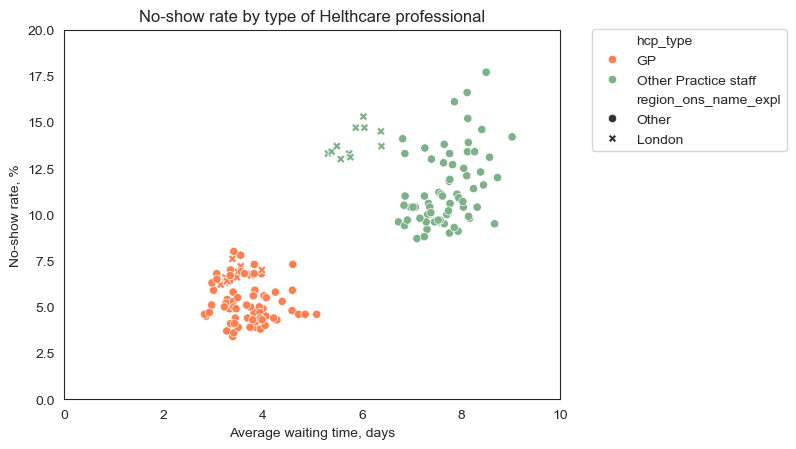

In [379]:
palette = ['coral', '#7EB08A']

g = sns.scatterplot(data=ar_df_desc1[ar_df_desc1.hcp_type != 'Unknown'], x='time_between_book_and_appointment_avg', y='DNA_est_%',  \
                hue='hcp_type', palette=palette, style='region_ons_name_expl', style_order=['Other', 'London'])

plt.title('No-show rate by type of Helthcare professional')
plt.ylabel('No-show rate, %')
plt.xlabel('Average waiting time, days')
plt.ylim([0, 20])
plt.xlim([0, 10])
plt.legend(bbox_to_anchor=(1.05, 1.02))

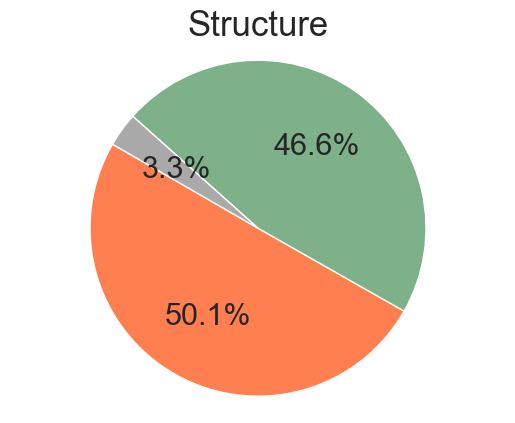

In [380]:
palette = ['coral', '#7EB08A', '#A9A9A9']

labels_values = ar_df_desc1[['hcp_type', 'Total']].groupby(by='hcp_type').sum()

labels = list(labels_values.index)
values = list(labels_values['Total'].values)
explode = (0, 0, 0) 

# Create pie chart
plt.pie(values, autopct='%1.1f%%', startangle=150, explode=explode, colors=palette, textprops={'fontsize': 22})

plt.axis('equal')
plt.title('Structure', fontsize=25)
plt.show()

In [381]:
# Calculate DNA as a percentage of total appointments per set groups  
ar_df_desc_missed_app = ar[ar.appointment_month >= '2021-08'][['appointment_month', 'region_ons_code', 'appointment_mode_expl', 'appointment_status', 'count_of_appointments']]\
.groupby(by=['appointment_month', 'region_ons_code', 'appointment_mode_expl', 'appointment_status']).sum()

# reset index
ar_df_desc_missed_app = ar_df_desc_missed_app.reset_index(level=-1)

# pivot the DF
ar_df_desc_missed_app = ar_df_desc_missed_app.pivot(columns='appointment_status', values='count_of_appointments')

# add Total column
ar_df_desc_missed_app['Total'] = ar_df_desc_missed_app['Attended'] + ar_df_desc_missed_app['DNA'] + ar_df_desc_missed_app['Unknown']

# Add 'DNA_%' column equal to 'DNA' / 'Total'
ar_df_desc_missed_app['DNA_exp_%'] = round(((ar_df_desc_missed_app['DNA'] + ar_df_desc_missed_app['Unknown']) / ar_df_desc_missed_app['Total']) * 100 , 1)

#view the output
ar_df_desc_missed_app

appointment_status                                       Attended     DNA  \
appointment_month region_ons_code appointment_mode_expl                     
2021-08           E40000003       Face-to-Face            1640633  131299   
                                  Other                    105615    5800   
                                  Telephone               1474704   44296   
                  E40000005       Face-to-Face            1835145  101928   
                                  Other                    106029    3150   
...                                                           ...     ...   
2022-06           E40000011       Other                    156639    6689   
                                  Telephone               1448043   32001   
                  E40000012       Face-to-Face            2660242  145841   
                                  Other                    156955    4949   
                                  Telephone               1041497   16783   

appointment_status                                       Unknown    Total  \
appointment_month region_ons_code appointment_mode_expl                     
2021-08           E40000003       Face-to-Face             72645  1844577   
                                  Other                    10834   122249   
                                  Telephone                55688  1574688   
                  E40000005       Face-to-Face             70495  2007568   
                                  Other                    12113   121292   
...                                                          ...      ...   
2022-06           E40000011       Other                    16823   180151   
                                  Telephone                39176  1519220   
                  E40000012       Face-to-Face            105312  2911395   
                                  Other                    11365   173269   
                                  Telephone                25600  1083880   

appointment_status                                       DNA_exp_%  
appointment_month region_ons_code appointment_mode_expl             
2021-08           E40000003       Face-to-Face                11.1  
                                  Other                       13.6  
                                  Telephone                    6.3  
                  E40000005       Face-to-Face                 8.6  
                                  Other                       12.6  
...                                                            ...  
2022-06           E40000011       Other                       13.1  
                                  Telephone                    4.7  
                  E40000012       Face-to-Face                 8.6  
                                  Other                        9.4  
                                  Telephone                    3.9  

[231 rows x 5 columns]

In [382]:
# Calculate WA time_between_book_and_appointment_n based on set groupping
ar_df_desc_w_time = weighted_average(ar[ar.appointment_month >= '2021-08'].copy(), 'time_between_book_and_appointment_n', \
                                     ['appointment_month', 'region_ons_code', 'appointment_mode_expl'], 'time_between_book_and_appointment_avg')

# reset index to multi
ar_df_desc_w_time.set_index(['appointment_month', 'region_ons_code', 'appointment_mode_expl'], inplace=True)

# view the output
ar_df_desc_w_time

count_of_appointments  \
appointment_month region_ons_code appointment_mode_expl                          
2021-08           E40000003       Face-to-Face                         1844577   
                                  Other                                 122249   
                                  Telephone                            1574688   
                  E40000005       Face-to-Face                         2007568   
                                  Other                                 121292   
...                                                                        ...   
2022-06           E40000011       Other                                 180151   
                                  Telephone                            1519220   
                  E40000012       Face-to-Face                         2911395   
                                  Other                                 173269   
                                  Telephone                            1083880   

                                                         time_between_book_and_appointment_avg  
appointment_month region_ons_code appointment_mode_expl                                         
2021-08           E40000003       Face-to-Face                                        4.987708  
                                  Other                                               3.515276  
                                  Telephone                                           3.148158  
                  E40000005       Face-to-Face                                        6.675802  
                                  Other                                               4.075751  
...                                                                                        ...  
2022-06           E40000011       Other                                               4.946772  
                                  Telephone                                           3.500386  
                  E40000012       Face-to-Face                                        7.104826  
                                  Other                                               4.470690  
                                  Telephone                                           4.086594  

[231 rows x 2 columns]

In [383]:
# merge two tables 
ar_df_desc2 = pd.merge(ar_df_desc_missed_app, ar_df_desc_w_time, left_index=True, right_index=True, how='outer')

# drop unnecessary columns
ar_df_desc2.drop('count_of_appointments', inplace=True, axis=1)

# reset index
ar_df_desc2.reset_index(inplace=True)

# view the output
ar_df_desc2.head()

appointment_month region_ons_code appointment_mode_expl  Attended     DNA  \
0           2021-08       E40000003          Face-to-Face   1640633  131299   
1           2021-08       E40000003                 Other    105615    5800   
2           2021-08       E40000003             Telephone   1474704   44296   
3           2021-08       E40000005          Face-to-Face   1835145  101928   
4           2021-08       E40000005                 Other    106029    3150   

   Unknown    Total  DNA_exp_%  time_between_book_and_appointment_avg  
0    72645  1844577       11.1                               4.987708  
1    10834   122249       13.6                               3.515276  
2    55688  1574688        6.3                               3.148158  
3    70495  2007568        8.6                               6.675802  
4    12113   121292       12.6                               4.075751

In [384]:
# Add region_ons_name_expl to ar_df_desc2 applying mapping. 

# Create a dictionary with 'region_ons_code':'region_ons_name_expl' key:value pairs 
region_expl_mapping = {'E40000003': 'London',
                       'E40000005': 'Other',
                       'E40000006': 'Other',
                       'E40000007': 'Other',
                       'E40000010': 'Other',
                       'E40000011': 'Other',
                       'E40000012': 'Other'}

# create the 'region_ons_name_expl' column in the ar_df_desc2 DataFrame and populate it applying region_mapping
ar_df_desc2['region_ons_name_expl'] = ar_df_desc2['region_ons_code'].map(region_expl_mapping)

# sense check the output 
print(ar_df_desc2.region_ons_name_expl.nunique())

2


In [385]:
# view the DF 
ar_df_desc2.head()

appointment_month region_ons_code appointment_mode_expl  Attended     DNA  \
0           2021-08       E40000003          Face-to-Face   1640633  131299   
1           2021-08       E40000003                 Other    105615    5800   
2           2021-08       E40000003             Telephone   1474704   44296   
3           2021-08       E40000005          Face-to-Face   1835145  101928   
4           2021-08       E40000005                 Other    106029    3150   

   Unknown    Total  DNA_exp_%  time_between_book_and_appointment_avg  \
0    72645  1844577       11.1                               4.987708   
1    10834   122249       13.6                               3.515276   
2    55688  1574688        6.3                               3.148158   
3    70495  2007568        8.6                               6.675802   
4    12113   121292       12.6                               4.075751   

  region_ons_name_expl  
0               London  
1               London  
2               London  
3                Other  
4                Other

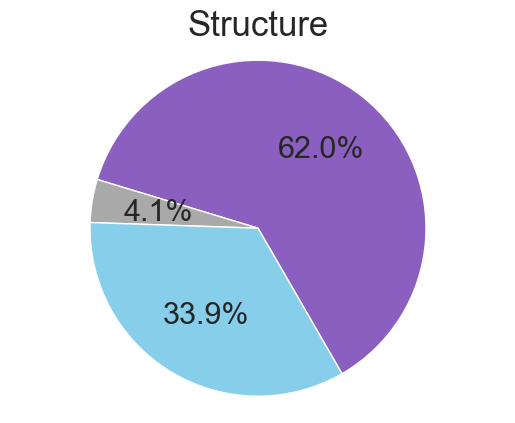

In [386]:
palette = ['#8B5FBF', '#A9A9A9', '#87CEEB']

# create a pie chart for appointment mode structure 
labels_values = ar_df_desc2[['appointment_mode_expl', 'Total']].groupby(by='appointment_mode_expl').sum()
labels = list(labels_values.index)
values = list(labels_values['Total'].values)
explode = (0, 0, 0) # explode the 1st slice

# Create pie chart
plt.pie(values, colors=palette, autopct='%1.1f%%', startangle=-60, explode=explode, textprops={'fontsize': 22})

plt.axis('equal')
plt.title('Structure', fontsize=25)
plt.show()

1. There is corrrelation between waiting times and % of missed appointments
2. In all practices independently of location waiting times and DNA_% are higher for Other Practice staff compared to GP 

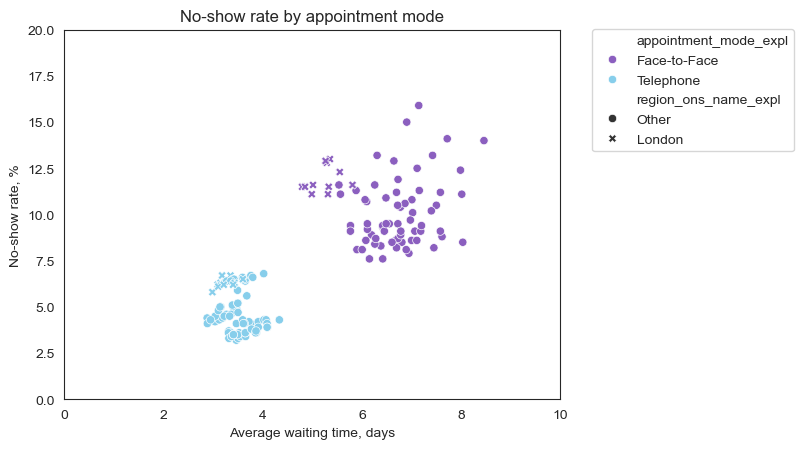

In [388]:
palette = ['#8B5FBF', '#87CEEB']

sns.scatterplot(data=ar_df_desc2[ar_df_desc2.appointment_mode_expl != 'Other'], x='time_between_book_and_appointment_avg', y='DNA_exp_%', \
                hue='appointment_mode_expl', style='region_ons_name_expl', palette=palette, style_order=['Other', 'London'])

plt.title('No-show rate by appointment mode')
plt.ylabel('No-show rate, %')
plt.xlabel('Average waiting time, days')
plt.ylim([0, 20])
plt.xlim([0, 10])
plt.legend(bbox_to_anchor=(1.05, 1.02))

#   